#**ALGORITHMIC TRADING INFRASTRUCTURE**

---

##0.REFERENCE

##1.CONTEXT



**FROM RESEARCH TO PRODUCTION: BUILDING ALGORITHMIC TRADING SYSTEMS THAT ACTUALLY WORK**

Welcome to the most important chapter in this book, and perhaps the most underrepresented topic in quantitative finance education. This is not a chapter about generating alpha, optimizing portfolios, or backtesting strategies. This is a chapter about the unglamorous but absolutely critical infrastructure that separates successful algorithmic trading operations from expensive failures. This is about the chasm between "my strategy has a good Sharpe ratio in backtest" and "my strategy safely manages real capital in live markets while satisfying regulatory requirements and surviving operational crises."

The quantitative finance industry has a dirty secret that most textbooks ignore: the vast majority of algorithmic trading failures are not caused by bad strategies but by bad infrastructure. Strategies fail because data feeds go down and the system does not handle the outage gracefully. Strategies fail because look-ahead bias creeps into feature calculations and backtest performance does not translate to live trading. Strategies fail because reconciliation breaks go undetected and positions drift away from targets. Strategies fail because no one thought to implement pre-trade risk checks and a bug sends orders that violate regulatory limits. Strategies fail because monitoring is inadequate and issues compound silently until they become catastrophic. These are not edge cases—these are the modal failure patterns in production algorithmic trading.

This notebook addresses these failure modes systematically by building a minimal but complete trading platform runtime simulation. You will not find sophisticated signal generation or advanced portfolio optimization here—those topics are covered elsewhere in this book. Instead, you will find the infrastructure required to operate any trading strategy safely and sustainably: service decomposition with clear contracts, event-driven architecture with audit trails, time semantics enforcement to prevent leakage, execution lifecycle management with realistic microstructure, reconciliation as the primary source of truth, comprehensive monitoring with runbook automation, governance-native artifact management, and multi-layered testing including chaos engineering.

Every design decision in this notebook reflects hard-won lessons from production trading systems. We use only NumPy and Python standard library, deliberately avoiding pandas and other convenience abstractions, because production systems must be transparent, portable, and auditable. We implement explicit validation gates at every service boundary because in production you trust nothing that comes from outside your control. We maintain decision identifiers that propagate from signals through orders to fills because regulatory examinations require complete audit trails. We include abstention logic because knowing when not to trade is often more valuable than knowing when to trade. We simulate realistic failures because systems that have not been tested under adversarial conditions will fail when those conditions inevitably occur.

The audience for this chapter is MBA and Master of Finance students who aspire to build or operate algorithmic trading systems, either within established institutions or as entrepreneurial ventures. You have studied portfolio theory, learned about factor models, perhaps even implemented some backtests. But you have likely never seen a complete picture of what it takes to run a trading strategy in production. You have never had to handle a data feed outage at three in the morning. You have never had to explain to a compliance officer why your system bought a particular security on a particular date. You have never had to conduct a post-incident review after a reconciliation break. You have never had to demonstrate to an investor that your infrastructure can scale from managing ten thousand dollars to managing ten million dollars without fundamental architectural changes.

This notebook gives you that experience in a compressed, controlled environment. You will build a system that ingests market data with realistic quality issues, computes features with explicit lags to prevent look-ahead bias, generates signals with confidence scoring and abstention logic, constructs portfolios with hard risk constraints, executes orders through a realistic state machine with partial fills and slippage, reconciles positions against broker truth, monitors system health across multiple dimensions, responds to alerts with predefined runbooks, logs every decision for audit trails, and packages every run into a governance artifact bundle. You will test this system not just with happy-path integration tests but also with chaos tests that inject feed outages, latency spikes, schema corruption, broker rejections, and reconciliation breaks.

By the end of this notebook, you will understand why professional trading operations look the way they do. You will understand why Goldman Sachs has separate teams for data engineering, feature platforms, signal research, portfolio construction, execution algorithms, and risk management. You will understand why regulatory compliance is not bureaucratic overhead but essential infrastructure. You will understand why investors care as much about operational discipline as they do about strategy performance. You will understand why most algorithmic trading startups fail not because their ideas are bad but because their execution capabilities are inadequate.

More importantly, you will have a concrete blueprint for building production-grade infrastructure yourself. The architecture patterns demonstrated here—service decomposition, event-driven communication, time semantics, execution microstructure, reconciliation discipline, monitoring rigor, governance completeness, testing comprehensiveness—scale naturally from this single-notebook simulation to distributed production systems managing institutional capital. The code you write here can evolve into the foundation of a real trading operation, whether you join an established firm and contribute to their platform or launch your own venture and need to demonstrate credibility to investors.

This is not easy material. Production infrastructure is complex because the real world is complex. But it is learnable, and it is essential. The students who master this material will build more robust systems, make fewer costly mistakes, sleep better at night, and ultimately have longer, more successful careers in quantitative finance. The students who skip this material in favor of chasing the latest machine learning technique or alternative data source will build fragile systems that work beautifully in notebooks and fail expensively in production.

Let us begin building infrastructure that actually works.


##2.LIBRARIES AND ENVIRONMENT

In [ ]:
# Cell 1 — Title, Scope, and Chapter Position

"""
CHAPTER 23: INFRASTRUCTURE & IMPLEMENTATION PATHWAYS
Foundations of Modern Algorithmic Trading — Alejandro Reynoso

SCOPE:
This notebook bridges the research-to-production gap by implementing a minimal,
governance-native trading platform runtime simulation. It demonstrates:

1. Service decomposition: ingestion → features → signals → portfolio/risk → execution → monitoring
2. Event-driven architecture with message bus simulation
3. Time semantics: event_time, processing_time, decision_time (the three clocks)
4. Execution lifecycle as state machine with partial fills/rejects
5. Reconciliation as primary truth
6. Monitoring, alerting, and runbook-style incident response
7. Artifact registry and run manifest for governance
8. Testing framework: unit, integration, chaos, replay
9. Production-minded contracts: schema validation, staleness, quality flags

WHAT IS BUILT:
- Synthetic market generator with controlled data quality issues
- Complete event-driven pipeline from ingestion to execution
- Deterministic replay capability
- Governance artifacts: logs, manifests, registries
- Testing harness with failure injection

WHAT IS POSTPONED:
- Chapter 24: Agentic assistants and LLM integration
- Chapter 25: Capstone integration and optimization
- Real broker connectivity (simulated only)
- Distributed systems (all in-memory)

AUDIENCE: MBA / Master of Finance / financial practitioners
PEDAGOGY: Formal, disciplined, minimal math, maximum clarity
"""

print("=" * 80)
print("CHAPTER 23: INFRASTRUCTURE & IMPLEMENTATION PATHWAYS")
print("=" * 80)
print("\nObjective: Build a production-minded trading platform runtime simulation")
print("Constraints: NumPy + stdlib only, no pandas, governance-native, deterministic")
print("\n" + "=" * 80)

In [19]:
# Cell 2 — Hard Constraints and Determinism Setup

import numpy as np
import json
import hashlib
from collections import deque, defaultdict
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, List, Any, Optional, Tuple
import itertools
import math

# Set global seed for determinism
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

# Configuration dictionary (production systems externalize this)
CONFIG = {
    "run_id": "run_20250101_001",
    "operator": "quant_team",
    "seed": GLOBAL_SEED,
    "universe_size": 10,
    "simulation_days": 5,
    "events_per_day": 100,
    "late_arrival_prob": 0.05,
    "missing_field_prob": 0.03,
    "staleness_threshold_sec": 300,
    "feature_lag": 1,
    "signal_abstention_threshold": 0.3,
    "max_instrument_weight": 0.2,
    "max_turnover": 0.5,
    "slippage_bps_base": 5.0,
    "partial_fill_prob": 0.1,
    "reject_prob": 0.05,
    "pretrade_price_band_pct": 0.05,
    "alert_latency_threshold_sec": 60,
    "reconciliation_tolerance": 1e-6,
}

# Hash the config for governance
def hash_dict(d: Dict) -> str:
    """Create deterministic hash of dictionary."""
    return hashlib.sha256(
        json.dumps(d, sort_keys=True).encode()
    ).hexdigest()[:16]

CONFIG_HASH = hash_dict(CONFIG)

# Simple logger helper
class Logger:
    def __init__(self):
        self.logs = []

    def log(self, level: str, component: str, message: str, **kwargs):
        entry = {
            "timestamp": datetime.now().isoformat(),
            "level": level,
            "component": component,
            "message": message,
            **kwargs
        }
        self.logs.append(entry)
        if level in ["ERROR", "CRITICAL"]:
            print(f"[{level}] {component}: {message}")

    def get_logs(self, component: Optional[str] = None, level: Optional[str] = None):
        filtered = self.logs
        if component:
            filtered = [log for log in filtered if log["component"] == component]
        if level:
            filtered = [log for log in filtered if log["level"] == level]
        return filtered

LOGGER = Logger()

# Create artifacts directory
ARTIFACTS_DIR = Path("./artifacts_ch23")
ARTIFACTS_DIR.mkdir(exist_ok=True)

print(f"Configuration loaded. Hash: {CONFIG_HASH}")
print(f"Global seed: {GLOBAL_SEED}")
print(f"Artifacts will be saved to: {ARTIFACTS_DIR}")
print(f"\nConfig summary:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration loaded. Hash: 4677b43602becc38
Global seed: 42
Artifacts will be saved to: artifacts_ch23

Config summary:
  run_id: run_20250101_001
  operator: quant_team
  seed: 42
  universe_size: 10
  simulation_days: 5
  events_per_day: 100
  late_arrival_prob: 0.05
  missing_field_prob: 0.03
  staleness_threshold_sec: 300
  feature_lag: 1
  signal_abstention_threshold: 0.3
  max_instrument_weight: 0.2
  max_turnover: 0.5
  slippage_bps_base: 5.0
  partial_fill_prob: 0.1
  reject_prob: 0.05
  pretrade_price_band_pct: 0.05
  alert_latency_threshold_sec: 60
  reconciliation_tolerance: 1e-06


##3.TIME SEMANTICS

###3.1.OVERVIEW



**Objective and Context**

This section establishes one of the most critical yet frequently misunderstood concepts in production algorithmic trading: the proper treatment of time. Unlike academic backtests where time is a simple incrementing index, production systems must distinguish between multiple temporal concepts and enforce rigorous semantics to prevent catastrophic errors. Time-related bugs are notoriously subtle—they pass all naive tests, produce plausible backtest results, and only reveal themselves in live trading when real money is at stake. This section builds the foundational time infrastructure that protects against these failures.

**The Three Clocks Framework**

The section introduces three distinct temporal concepts that every production trading system must track and manage:

- **Event Time**: When something actually happened in the real world, typically assigned by the market data provider or exchange. This represents the "true" timestamp of a market event like a trade or quote update.

- **Processing Time**: When our system received and began processing the event. This is always greater than or equal to event time (you cannot process something before it happens) and captures network latency, queuing delays, and system load.

- **Decision Time**: When our system made a trading decision based on available information. This must respect explicit lags to ensure we only use data that was actually available at the moment of decision, preventing look-ahead bias.

**Why This Matters**

Students often wonder why this complexity is necessary. The answer lies in understanding three common failure modes that proper time semantics prevent:

- **Look-Ahead Bias**: Using future information to make past decisions. This is the single most common reason why backtest performance fails to materialize in live trading. By enforcing that decision time can only use data with event time less than decision time minus lag, we guarantee temporal causality.

- **Stale Data Problems**: Acting on outdated information that no longer reflects market reality. By tracking processing time and rejecting events that arrive too late, we avoid making decisions based on information that the market has already moved past.

- **Ordering Violations**: Processing events out of sequence, which can corrupt state calculations like rolling features or position tracking. By enforcing monotonicity of event time within each instrument stream, we ensure consistent state evolution.

**Implementation Details**

The section implements several critical functions that production systems use constantly:

- **Monotonicity Validation**: Checks that event times are non-decreasing within each instrument stream. Out-of-order events indicate either provider issues or network reordering and must be handled explicitly rather than silently corrupting calculations.

- **Processing Time Validation**: Asserts that processing time is never before event time, catching clock synchronization issues and timestamp corruption early rather than letting them propagate through the system.

- **Staleness Computation**: Calculates how old an event is when we process it, measured as processing time minus event time. Events exceeding a staleness threshold are flagged or rejected because acting on them would be trading on stale information.

- **Lag Enforcement**: Ensures that when we make a decision at time T, we only use features computed from data with event time at most T minus lag. This explicit lag is how we prevent look-ahead bias in a verifiable, testable way.

**Pedagogical Insights**

This section teaches several deeper lessons about production system design:

- **Defensive Programming**: Production systems assume nothing. We do not trust that timestamps are correct, that clocks are synchronized, or that data arrives in order. We verify everything explicitly and fail loudly when assumptions are violated.

- **Explicit Over Implicit**: Rather than hoping that our code naturally respects temporal causality, we encode time semantics as explicit checks with assertion statements. If these checks fail, the system halts rather than producing incorrect results.

- **Testing Time Semantics**: The section includes explicit unit tests that verify time semantics work correctly. We test that monotonic sequences pass, non-monotonic sequences fail, processing before event time fails, and staleness calculations are accurate. These tests catch bugs immediately rather than letting them reach production.

**Real-World Application**

In production trading systems, time semantics violations are treated as critical incidents that trigger immediate investigation. A single out-of-order event, a staleness spike, or a processing-before-event-time anomaly could indicate:

- Data provider infrastructure issues requiring vendor escalation
- Network problems causing packet reordering or delays
- System clock drift requiring NTP reconfiguration
- Software bugs in timestamp handling requiring emergency patches
- Malicious data injection requiring security response

By establishing rigorous time semantics enforcement early in the pipeline, we create an early-warning system for these issues. The ingestion service (covered in the next section) will use these time semantic functions to validate every incoming event, ensuring that only temporally valid data enters the system.

**Connection to Later Sections**

The time semantics framework established here permeates every subsequent section. Feature calculations will explicitly enforce lags using these functions. Signal generation will timestamp decisions and verify they only use appropriately lagged features. Execution will track multiple timestamps throughout the order lifecycle. Reconciliation will use time-based windowing. Monitoring will measure staleness and detect timing anomalies. Replay testing will verify that time semantics are preserved across system restarts. This is not an isolated concern but rather foundational infrastructure that makes everything else possible.

Students who internalize the three-clocks framework will immediately recognize time-related bugs in production code, design better systems from the start, and avoid the expensive mistakes that plague less disciplined operations.

###3.2.CODE AND IMPLEMENTATION

In [2]:
# Cell 3 — Time Semantics: The Three Clocks

"""
THE THREE CLOCKS:
1. event_time: When the event occurred in the real world (market time)
2. processing_time: When we received/processed the event (system time)
3. decision_time: When we made a decision based on this event

CRITICAL RULES:
- event_time must be monotonic within a stream (or explicitly handled if not)
- processing_time >= event_time (cannot process before event occurs)
- staleness = processing_time - event_time (must be < threshold)
- decision_time uses only data with event_time <= decision_time - lag
"""

class TimeSemantics:
    """Enforces time semantics and prevents leakage."""

    @staticmethod
    def validate_event_time(event_time: datetime, last_event_time: Optional[datetime]) -> bool:
        """Check if event_time is monotonic."""
        if last_event_time is None:
            return True
        if event_time < last_event_time:
            LOGGER.log("WARNING", "TimeSemantics",
                      f"Non-monotonic event_time detected: {event_time} < {last_event_time}")
            return False
        return True

    @staticmethod
    def validate_processing_time(event_time: datetime, processing_time: datetime) -> bool:
        """Check if processing_time >= event_time."""
        if processing_time < event_time:
            LOGGER.log("ERROR", "TimeSemantics",
                      f"Processing time {processing_time} < event time {event_time}")
            return False
        return True

    @staticmethod
    def compute_staleness(event_time: datetime, processing_time: datetime) -> float:
        """Compute staleness in seconds."""
        return (processing_time - event_time).total_seconds()

    @staticmethod
    def is_stale(event_time: datetime, processing_time: datetime, threshold_sec: float) -> bool:
        """Check if event is too stale."""
        staleness = TimeSemantics.compute_staleness(event_time, processing_time)
        return staleness > threshold_sec

    @staticmethod
    def enforce_lag(decision_time: datetime, data_event_time: datetime, lag_seconds: float) -> bool:
        """Ensure data is lagged appropriately to prevent leakage."""
        return data_event_time <= decision_time - timedelta(seconds=lag_seconds)

# Test time semantics
base_time = datetime(2025, 1, 1, 9, 30, 0)
event_t1 = base_time
event_t2 = base_time + timedelta(seconds=10)
proc_t1 = base_time + timedelta(seconds=2)

assert TimeSemantics.validate_event_time(event_t1, None), "First event should be valid"
assert TimeSemantics.validate_event_time(event_t2, event_t1), "Monotonic time should be valid"
assert not TimeSemantics.validate_event_time(event_t1, event_t2), "Non-monotonic should fail"
assert TimeSemantics.validate_processing_time(event_t1, proc_t1), "Processing after event is valid"
assert not TimeSemantics.validate_processing_time(proc_t1, event_t1), "Processing before event is invalid"
assert TimeSemantics.compute_staleness(event_t1, proc_t1) == 2.0, "Staleness should be 2 seconds"

print("Time semantics validated successfully")
print(f"Staleness threshold: {CONFIG['staleness_threshold_sec']} seconds")
print(f"Feature lag: {CONFIG['feature_lag']} event(s)")

[ERROR] TimeSemantics: Processing time 2025-01-01 09:30:00 < event time 2025-01-01 09:30:02
Time semantics validated successfully
Staleness threshold: 300 seconds
Feature lag: 1 event(s)


/tmp/ipython-input-3630700785.py:56: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


##4.MINIMAL EVENT SCHEMA

###4.1.OVERVIEW


**Objective and Context**

This section establishes the communication contract and transport mechanism that enables loosely coupled services to work together reliably. In production trading systems, services cannot call each other's functions directly because that creates tight coupling, makes testing difficult, and prevents independent scaling. Instead, services communicate by publishing and consuming standardized events through a message bus. This section implements both the event schema that defines what information must be present in every message, and the message bus that routes these events between services. While we use a simple in-memory queue for educational purposes, the patterns demonstrated here scale directly to enterprise message brokers like Kafka or RabbitMQ.

**The Event Schema: A Universal Contract**

The section defines a rigorous event schema that every message in the system must satisfy. This is not optional metadata—this is the foundational contract that enables the entire system to operate:

- **Core Identity Fields**: Every event has a unique event identifier, a source indicating which service created it, and a schema version enabling evolution over time. These fields enable event tracking, debugging, and backward compatibility.

- **Temporal Fields**: Every event carries both event time (when it happened) and processing time (when we received it), implementing the three-clocks framework from the previous section. These timestamps enable staleness detection, ordering validation, and temporal analysis.

- **Routing and Context**: Events include instrument identifier for routing to appropriate handlers, payload containing event-specific data, and trace identifier for distributed tracing across services. These fields enable efficient processing and end-to-end observability.

- **Lineage and Quality**: Events carry an optional decision identifier linking effects back to causes, and quality flags indicating known issues like staleness or incompleteness. These fields enable audit trails and informed handling of degraded data.

**Why Schema Enforcement Matters**

Students might wonder why we need such elaborate structure when a simple dictionary would work. The answer becomes clear when considering production failure modes:

- **Schema Evolution**: Production systems evolve continuously. New fields are added, old fields deprecated, data types change. Without schema versioning, consumers cannot distinguish between old and new format events, leading to parsing failures and silent data corruption.

- **Validation at Boundaries**: The schema provides explicit validation logic that runs at every service boundary. Invalid events are rejected immediately with clear error messages rather than propagating through the system causing downstream failures that are difficult to diagnose.

- **Debugging and Audit**: When investigating production issues, operators need to know exactly what data was present in each event. The schema ensures complete information is always available, and the unique identifiers enable precise event lookup in logs.

- **Contract Testing**: Services can test against the schema independently without requiring other services to be running. Schema validation functions serve as executable contracts that both producers and consumers can verify against.

**The Message Bus: Decoupling Services**

The message bus implementation demonstrates several critical patterns for service-oriented architecture:

- **Publish-Subscribe Semantics**: Services publish events without knowing who will consume them. Consumers subscribe to event types without knowing who produced them. This decoupling allows services to be developed, deployed, and scaled independently.

- **Ordered Delivery**: Events are consumed in the order they were published, which is essential for maintaining consistent state in stateful services like feature calculators or position trackers.

- **Buffering and Backpressure**: The queue buffers events when consumers are slower than producers, preventing data loss during temporary load spikes. In production systems, this buffering also enables backpressure mechanisms to slow producers when consumers fall too far behind.

- **Observability Hooks**: The message bus logs every publish and consume operation, creating a complete record of system communication patterns. This logging enables debugging, performance analysis, and audit trail construction.

**Implementation Patterns**

The section demonstrates several implementation patterns that production systems use extensively:

- **Factory Methods**: The create event function encapsulates all schema requirements and generates valid events with proper defaults. This prevents producers from accidentally creating malformed events.

- **Validation Functions**: The validate event function checks all schema requirements and returns detailed error messages. This validation runs at ingestion boundaries, catching problems before they enter the system.

- **Type Safety Through Structure**: While we use Python dictionaries for simplicity, the schema could easily be implemented with dataclasses or Pydantic models for stronger type safety. The structural pattern remains the same.

- **Extensible Payload**: The payload field is a flexible dictionary that can contain event-specific data without requiring schema changes. This enables rapid iteration while maintaining schema stability.

**Real-World Scaling Considerations**

Students should understand how this simple implementation maps to production infrastructure:

- **Message Broker Replacement**: The in-memory deque can be replaced with Kafka, RabbitMQ, or AWS Kinesis without changing service logic. The publish and consume APIs remain identical, only the underlying transport changes.

- **Partitioning and Parallelism**: Production message buses partition events by instrument identifier, allowing parallel processing of different instruments while maintaining ordering guarantees within each partition.

- **Persistence and Replay**: Production buses persist events to disk, enabling replay for debugging, disaster recovery, and historical analysis. The section later demonstrates replay testing using this capability.

- **Schema Registry**: Production systems maintain a centralized schema registry (like Confluent Schema Registry) that enforces schema compatibility rules and enables schema evolution without breaking existing consumers.

**Testing the Communication Layer**

The section includes explicit validation of the event schema and message bus:

- **Schema Compliance**: Test events are created and validated, ensuring the schema enforcement logic actually works and catches violations.

- **Round-Trip Testing**: Events are published to the bus and consumed back, verifying that serialization and deserialization preserve all fields correctly.

- **Error Handling**: Invalid events are deliberately created and validation is verified to reject them with appropriate error messages.

**Pedagogical Takeaways**

This section teaches fundamental lessons about distributed system design:

- **Contracts Enable Independence**: Well-defined schemas allow teams to work on different services simultaneously without constant coordination. Each team knows exactly what to produce and what to expect from others.

- **Validation Is Not Optional**: Production systems validate at every boundary. The cost of validation is trivial compared to the cost of debugging data corruption that propagated through multiple services.

- **Observability From The Start**: Logging every event publication and consumption creates the foundation for understanding system behavior, debugging issues, and proving compliance with regulations.

- **Simple Abstractions Scale**: The message bus interface is intentionally simple—publish and consume. This simplicity makes it easy to replace the implementation as scale requirements grow, without rewriting service logic.

Students who master event-driven architecture will build more maintainable, scalable, and reliable systems throughout their careers, whether in finance or any other domain requiring distributed computation.

###4.2.CODE AND IMPLEMENTATION

In [3]:
# Cell 4 — Minimal Event Schema + In-Memory Message Bus

"""
EVENT SCHEMA:
Every event in the system follows a standard schema:
- event_type: str (e.g., 'quote', 'trade', 'bar', 'signal', 'order', 'fill')
- event_id: str (unique identifier)
- source: str (originating service)
- schema_version: str (for evolution compatibility)
- event_time: datetime (when event occurred)
- processing_time: datetime (when we received it)
- instrument_id: str
- payload: dict (event-specific data)
- trace_id: str (for distributed tracing)
- decision_id: Optional[str] (links to decision that caused this)
- quality_flags: List[str] (warnings/issues)
"""

class EventSchema:
    VERSION = "1.0.0"
    REQUIRED_FIELDS = [
        "event_type", "event_id", "source", "schema_version",
        "event_time", "processing_time", "instrument_id"
    ]

    @staticmethod
    def create_event(
        event_type: str,
        source: str,
        instrument_id: str,
        event_time: datetime,
        payload: Dict[str, Any],
        trace_id: Optional[str] = None,
        decision_id: Optional[str] = None,
        quality_flags: Optional[List[str]] = None
    ) -> Dict[str, Any]:
        """Create a valid event."""
        import uuid
        return {
            "event_type": event_type,
            "event_id": str(uuid.uuid4()),
            "source": source,
            "schema_version": EventSchema.VERSION,
            "event_time": event_time,
            "processing_time": datetime.utcnow(),
            "instrument_id": instrument_id,
            "payload": payload,
            "trace_id": trace_id or str(uuid.uuid4()),
            "decision_id": decision_id,
            "quality_flags": quality_flags or []
        }

    @staticmethod
    def validate(event: Dict[str, Any]) -> Tuple[bool, List[str]]:
        """Validate event schema."""
        errors = []

        # Check required fields
        for field in EventSchema.REQUIRED_FIELDS:
            if field not in event:
                errors.append(f"Missing required field: {field}")

        # Check schema version
        if event.get("schema_version") != EventSchema.VERSION:
            errors.append(f"Schema version mismatch: {event.get('schema_version')}")

        # Check time semantics
        if "event_time" in event and "processing_time" in event:
            if not TimeSemantics.validate_processing_time(
                event["event_time"], event["processing_time"]
            ):
                errors.append("Processing time before event time")

        return len(errors) == 0, errors

# In-memory message bus
class MessageBus:
    """Simple in-memory message bus using deque."""

    def __init__(self):
        self.queue = deque()
        self.published_count = 0
        self.consumed_count = 0

    def publish(self, event: Dict[str, Any]):
        """Publish event to bus."""
        self.queue.append(event)
        self.published_count += 1
        LOGGER.log("DEBUG", "MessageBus",
                  f"Published {event['event_type']} for {event['instrument_id']}")

    def consume(self, batch_size: int = 1) -> List[Dict[str, Any]]:
        """Consume events from bus."""
        events = []
        for _ in range(min(batch_size, len(self.queue))):
            if self.queue:
                events.append(self.queue.popleft())
                self.consumed_count += 1
        return events

    def peek(self, n: int = 1) -> List[Dict[str, Any]]:
        """Peek at next n events without consuming."""
        return list(itertools.islice(self.queue, n))

    def size(self) -> int:
        """Current queue size."""
        return len(self.queue)

# Initialize message bus
BUS = MessageBus()

# Test event creation and validation
test_event = EventSchema.create_event(
    event_type="test",
    source="test_generator",
    instrument_id="TEST_001",
    event_time=datetime.utcnow(),
    payload={"price": 100.0}
)

valid, errors = EventSchema.validate(test_event)
assert valid, f"Event validation failed: {errors}"
print(f"Event schema validated. Version: {EventSchema.VERSION}")
print(f"Sample event: {json.dumps({k: str(v) for k, v in test_event.items()}, indent=2)}")

Event schema validated. Version: 1.0.0
Sample event: {
  "event_type": "test",
  "event_id": "57e11d27-d16c-4c45-8148-a776fbafb4af",
  "source": "test_generator",
  "schema_version": "1.0.0",
  "event_time": "2025-12-31 14:14:26.804891",
  "processing_time": "2025-12-31 14:14:26.804986",
  "instrument_id": "TEST_001",
  "payload": "{'price': 100.0}",
  "trace_id": "a12f924f-8317-4d87-8563-74e9a157169c",
  "decision_id": "None",
  "quality_flags": "[]"
}


/tmp/ipython-input-1167640712.py:117: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  event_time=datetime.utcnow(),
/tmp/ipython-input-1167640712.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "processing_time": datetime.utcnow(),


##5.SYNTHETIC MARKET GENERATOR

###5.1.OVERVIEW



**Objective and Context**

This section implements a synthetic market data generator that serves two critical pedagogical purposes. First, it provides a controlled, deterministic source of market events that allows students to understand system behavior without the complexity and cost of real market data subscriptions. Second, and more importantly, it deliberately injects realistic data quality issues that production systems must handle gracefully. This is not a simplification—this is intentional preparation for production reality. Real market data feeds are messy, incomplete, delayed, occasionally corrupted, and subject to vendor-specific quirks. A trading system that assumes perfect data will fail immediately when confronted with actual market feeds. This section trains students to expect imperfection and design defensively from the start.

**Synthetic Market Design Principles**

The market generator creates price paths using geometric Brownian motion, the standard stochastic process taught in every quantitative finance course. However, the implementation goes well beyond textbook simulation:

- **Deterministic Seeding**: The generator uses a fixed random seed, ensuring that running the notebook multiple times produces identical market paths. This determinism is essential for debugging, testing, and demonstrating reproducibility to regulators or investors.

- **Realistic Microstructure**: Rather than generating abstract returns, the generator produces bar events with open, high, low, close, and volume fields that respect realistic relationships (high is above close, low is below close, etc.). This matches the actual data format that services will consume.

- **Instrument Universe**: The generator creates a small universe of synthetic instruments with heterogeneous volatilities, mimicking a real portfolio where different securities have different risk characteristics.

- **Temporal Realism**: Events are distributed across multiple simulated trading days with realistic spacing, rather than being uniformly distributed. This creates patterns similar to actual market data where certain times have higher activity.

**Controlled Data Quality Degradation**

The most valuable aspect of this section is the systematic injection of realistic data quality issues:

- **Late Arrivals**: A configurable percentage of events have their processing time delayed significantly beyond event time, simulating network latency, provider delays, or system processing backlogs. Production systems must detect and handle stale data explicitly rather than silently acting on outdated information.

- **Missing Fields**: Random fields are occasionally omitted from event payloads, simulating provider schema changes, transmission errors, or vendor bugs. Services must validate field presence explicitly rather than assuming complete data and crashing with cryptic errors when assumptions are violated.

- **Staleness Flags**: Events that exceed the staleness threshold are automatically flagged with quality warnings. This demonstrates how production systems mark degraded data for downstream services to handle appropriately, rather than treating all data equally regardless of quality.

- **Schema Violations**: By occasionally producing incomplete or malformed events, the generator creates opportunities to test validation logic that will be implemented in the ingestion service. Systems that pass tests with perfect data often fail catastrophically when confronted with real-world imperfection.

**Why Synthetic First, Real Data Later**

Students might question why we start with synthetic data when the goal is production trading. This design choice reflects several important principles:

- **Reproducibility**: Synthetic data with fixed seeds produces identical results every time the notebook runs. This reproducibility is essential for debugging, testing, and educational demonstration. Real data changes constantly, making it impossible to verify that code changes produce expected outcomes.

- **Cost and Access**: Real market data requires paid subscriptions, vendor agreements, and often institutional credentials. Starting with synthetic data removes these barriers, allowing any student anywhere to run the complete notebook and learn the concepts.

- **Controlled Scenarios**: Synthetic data allows us to create specific scenarios for testing, like volatility spikes, price gaps, or missing data periods. Real data contains whatever scenarios happen to occur in the historical period, which may not cover all failure modes we need to test.

- **Focus on Infrastructure**: By using synthetic data, we force attention onto the infrastructure patterns—validation, time semantics, state management, monitoring—rather than getting distracted by market analysis, factor research, or alpha generation. Those topics are covered elsewhere in the book.

**Event Stream Characteristics**

The generator produces a complete event stream with specific quantitative properties that students should verify:

- **Event Count**: Total events equal universe size times simulation days times events per day, demonstrating that the system can handle thousands of events across multiple instruments and time periods.

- **Quality Statistics**: The percentage of stale events and incomplete events matches configured probabilities, proving that the quality degradation logic works as specified. These statistics establish baseline expectations for the ingestion service to validate against.

- **Temporal Distribution**: Events span multiple days with realistic intraday spacing, creating natural boundaries for daily portfolio rebalancing and monitoring snapshots.

- **Cross-Sectional Properties**: Different instruments have different volatilities and price levels, ensuring that feature calculations and portfolio construction logic must handle heterogeneity rather than working only for uniform data.

**Sample Event Inspection**

The section prints a sample event showing its complete structure, allowing students to see exactly what information is available:

- All required schema fields are present and properly formatted
- Timestamps are realistic and respect causality (processing time after event time)
- Payload contains complete OHLC and volume data
- Quality flags indicate any known issues with the specific event
- Trace identifiers enable tracking this event through subsequent processing

**Connection to Production Data Adapters**

While the section uses synthetic data, the event format is identical to what a real data adapter would produce. Later in the notebook, an optional section demonstrates how to replace the synthetic generator with a yfinance adapter that fetches actual market data. The critical point is that all downstream services—ingestion, features, signals, portfolio, execution—work identically regardless of whether events come from synthetic generation or real market feeds. This separation of concerns allows independent development and testing of data acquisition versus data processing.

**Pedagogical Insights**

This section teaches several fundamental lessons about production system design:

- **Design for Imperfection**: Production systems assume data will be imperfect and design validation and handling logic accordingly. The mindset is not "if data is bad" but rather "when data is bad, what do we do?"

- **Observable Quality**: Rather than silently accepting whatever data arrives, production systems measure and report quality metrics continuously. The generator models this by tracking how many events are stale or incomplete.

- **Determinism Enables Testing**: Reproducible inputs enable meaningful tests. If running the same code twice produces different results due to random data, you cannot verify that bug fixes work or that refactoring preserves behavior.

- **Abstraction Boundaries**: By producing events in a standard schema rather than exposing internal generator implementation details, we create a clean boundary that enables later replacement with real data sources.

Students who understand why we deliberately inject data quality issues will build more robust systems that survive contact with production reality, rather than fragile systems that work only in idealized testing environments.

###5.2.CODE AND IMPLEMENTATION

In [4]:
# Cell 5 — Synthetic Market Generator (Streaming-Like)

"""
SYNTHETIC MARKET GENERATOR:
Generates a controlled stream of market events with known properties:
- N instruments with synthetic price paths (geometric Brownian motion)
- Events: bar data (OHLC) for simplicity
- Controlled data quality issues: late arrivals, missing fields
- Deterministic via seeded random
"""

class SyntheticMarketGenerator:
    """Generate synthetic market data stream."""

    def __init__(self, config: Dict[str, Any], seed: int):
        self.config = config
        self.rng = np.random.RandomState(seed)

        # Create universe
        self.instruments = [f"SYNTH_{i:03d}" for i in range(config["universe_size"])]

        # Initial prices
        self.initial_prices = {
            inst: 100.0 + self.rng.randn() * 10 for inst in self.instruments
        }

        # Volatility per instrument (annualized)
        self.volatilities = {
            inst: 0.15 + self.rng.rand() * 0.15 for inst in self.instruments
        }

        self.base_time = datetime(2025, 1, 1, 9, 30, 0)
        self.events_generated = 0

    def generate_stream(self) -> List[Dict[str, Any]]:
        """Generate full event stream."""
        events = []

        total_periods = self.config["simulation_days"] * self.config["events_per_day"]
        seconds_per_period = (6.5 * 3600) / self.config["events_per_day"]  # Trading day

        for period in range(total_periods):
            for inst in self.instruments:
                event_time = self.base_time + timedelta(seconds=period * seconds_per_period)

                # Generate price using GBM
                dt = 1.0 / 252 / self.config["events_per_day"]  # Time increment
                vol = self.volatilities[inst]
                drift = 0.0  # Neutral for simplicity

                prev_price = self.initial_prices[inst]
                shock = self.rng.randn()
                price = prev_price * np.exp(
                    (drift - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * shock
                )

                # Simple OHLC (price with small variations)
                spread_pct = 0.001
                high = price * (1 + spread_pct * abs(self.rng.randn()))
                low = price * (1 - spread_pct * abs(self.rng.randn()))
                open_price = prev_price
                close_price = price
                volume = int(10000 + self.rng.randn() * 2000)

                # Update for next period
                self.initial_prices[inst] = price

                # Create payload
                payload = {
                    "open": open_price,
                    "high": high,
                    "low": low,
                    "close": close_price,
                    "volume": volume
                }

                # Inject missing fields
                if self.rng.rand() < self.config["missing_field_prob"]:
                    del payload[self.rng.choice(list(payload.keys()))]

                # Late arrival simulation
                processing_time = event_time + timedelta(
                    seconds=self.rng.exponential(5)
                )

                if self.rng.rand() < self.config["late_arrival_prob"]:
                    processing_time += timedelta(seconds=self.rng.exponential(120))

                quality_flags = []
                if TimeSemantics.is_stale(
                    event_time, processing_time,
                    self.config["staleness_threshold_sec"]
                ):
                    quality_flags.append("STALE")

                if len(payload) < 5:
                    quality_flags.append("INCOMPLETE")

                event = {
                    "event_type": "bar",
                    "event_id": f"bar_{inst}_{period}",
                    "source": "synthetic_market",
                    "schema_version": EventSchema.VERSION,
                    "event_time": event_time,
                    "processing_time": processing_time,
                    "instrument_id": inst,
                    "payload": payload,
                    "trace_id": f"trace_{period}",
                    "decision_id": None,
                    "quality_flags": quality_flags
                }

                events.append(event)
                self.events_generated += 1

        return events

# Generate market events
market_gen = SyntheticMarketGenerator(CONFIG, GLOBAL_SEED)
market_events = market_gen.generate_stream()

print(f"Generated {len(market_events)} market events")
print(f"Instruments: {len(market_gen.instruments)}")
print(f"Time span: {market_events[0]['event_time']} to {market_events[-1]['event_time']}")
print(f"\nSample event:")
print(json.dumps({k: str(v) for k, v in market_events[0].items()}, indent=2))

# Count quality issues
stale_count = sum(1 for e in market_events if "STALE" in e.get("quality_flags", []))
incomplete_count = sum(1 for e in market_events if "INCOMPLETE" in e.get("quality_flags", []))
print(f"\nData quality issues injected:")
print(f"  Stale events: {stale_count} ({100*stale_count/len(market_events):.1f}%)")
print(f"  Incomplete events: {incomplete_count} ({100*incomplete_count/len(market_events):.1f}%)")

Generated 5000 market events
Instruments: 10
Time span: 2025-01-01 09:30:00 to 2025-01-02 17:56:06

Sample event:
{
  "event_type": "bar",
  "event_id": "bar_SYNTH_000_0",
  "source": "synthetic_market",
  "schema_version": "1.0.0",
  "event_time": "2025-01-01 09:30:00",
  "processing_time": "2025-01-01 09:30:00.237819",
  "instrument_id": "SYNTH_000",
  "payload": "{'open': 104.96714153011233, 'high': np.float64(105.16275623183046), 'low': np.float64(105.13191848408371), 'close': np.float64(105.1390183332344), 'volume': 7150}",
  "trace_id": "trace_0",
  "decision_id": "None",
  "quality_flags": "[]"
}

Data quality issues injected:
  Stale events: 29 (0.6%)
  Incomplete events: 149 (3.0%)


##6.INGESTION SERVICE

###6.1.OVERVIEW


**Objective and Context**

This section implements the ingestion service, which serves as the first line of defense in the trading platform. Its singular mission is to ensure that only valid, temporally consistent, high-quality data enters the system. This is not pedantic over-engineering—this is the difference between a system that degrades gracefully under stress and one that cascades into catastrophic failure when confronted with imperfect data. Production trading systems fail far more often from accepting bad data than from incorrect trading logic. The ingestion service embodies a fundamental principle: trust nothing that comes from outside your control boundary, validate everything explicitly, and fail loudly when assumptions are violated rather than silently propagating corruption through the system.

**The Validation Gate Architecture**

The ingestion service implements multiple sequential validation gates, each checking specific invariants and rejecting events that violate requirements:

- **Schema Validation**: Every event must contain all required fields with appropriate types. Missing fields, wrong types, or invalid schema versions are rejected immediately with clear error messages. This catches provider changes, transmission corruption, and integration bugs before they cause downstream failures.

- **Time Semantics Validation**: Events must have processing time after event time (you cannot process something before it happens), and event times must be monotonic within each instrument stream (events for the same instrument must arrive in temporal order, or be flagged for special handling). These checks prevent temporal causality violations that would corrupt feature calculations.

- **Duplicate Detection**: Every event has a unique identifier, and the ingestion service maintains a set of seen identifiers to reject duplicates. Duplicate events can arise from network retries, provider glitches, or message bus replay, and accepting them would double-count market moves or create position tracking errors.

- **Staleness Assessment**: Events with processing time significantly after event time are flagged as stale. The service uses the staleness threshold from configuration to determine what "significantly" means. Stale events may still be accepted but are marked with quality flags so downstream services can decide whether to use them.

- **Field Completeness Checks**: For specific event types like bars, required payload fields (open, high, low, close, volume) must all be present. Missing payload fields indicate provider issues or transmission errors and must be rejected to prevent calculations from using incomplete data.

- **Range Validation**: Prices must be positive, high must exceed low, and other domain-specific sanity checks are applied. These catches obvious corruption like negative prices or inverted OHLC relationships that would indicate serious data quality problems.

**Why Multiple Gates Rather Than One Omnibus Check**

Students might wonder why we implement many small validation functions rather than one large validation routine. This design reflects several production lessons:

- **Precise Error Reporting**: When validation fails, operators need to know exactly what was wrong—was it a schema issue, a timing problem, a duplicate, or a range violation? Separate gates produce specific error messages that enable rapid diagnosis and remediation.

- **Independent Evolution**: Different validation rules evolve at different rates. Schema validation is stable, but range checks might need adjustment as market conditions change. Separate gates can be modified independently without risking unintended interactions.

- **Selective Enforcement**: Some validation failures are fatal (schema violations) while others are warnings (staleness). Separate gates allow nuanced handling where some events are rejected, others are accepted with quality flags, and others trigger alerts but pass through.

- **Testing Granularity**: Each gate can be tested independently with targeted test cases. This produces more comprehensive test coverage than attempting to test all validation logic through a single function.

**Rejection Handling and Quarantine**

The ingestion service does not silently discard rejected events. Instead, it implements a quarantine system:

- **Comprehensive Logging**: Every rejected event is logged with its complete content and the specific rejection reasons. This creates an audit trail for operational review and debugging.

- **Rejection Metrics**: The service counts rejections by reason (schema violations, duplicates, staleness, missing fields, range errors). These metrics feed into monitoring dashboards and alert thresholds.

- **Quarantine Storage**: Rejected events are stored separately rather than discarded, allowing operators to review them manually, potentially fix systematic issues, and replay corrected data if appropriate.

- **Provider Escalation**: Persistent rejection patterns (like consistently missing fields from a specific provider) trigger alerts that operations teams use to escalate issues to data vendors.

**State Management for Validation**

The ingestion service maintains minimal state to support validation:

- **Seen Event IDs**: A set tracking all processed event identifiers to enable duplicate detection. In production systems, this would be a time-windowed cache rather than unbounded memory, but the pattern is identical.

- **Last Event Time Per Instrument**: A dictionary tracking the most recent event time for each instrument to enforce monotonicity. Out-of-order events indicate provider issues or network reordering that require investigation.

- **Rejection Statistics**: Counters tracking acceptance and rejection by reason, enabling real-time monitoring of data quality trends.

**Acceptance Rate as a Key Performance Indicator**

The section explicitly computes and reports the acceptance rate—the percentage of events that pass all validation gates. This metric is critical for production operations:

- **Baseline Establishment**: During initial deployment, the acceptance rate establishes what "normal" data quality looks like for each provider and instrument type.

- **Degradation Detection**: Significant drops in acceptance rate trigger alerts, indicating provider problems, network issues, or system bugs that require immediate investigation.

- **Provider Comparison**: When multiple providers supply similar data, acceptance rates enable quantitative comparison of data quality across vendors.

- **Contractual Enforcement**: Data provider agreements often include service level agreements around data quality. Acceptance rate metrics provide evidence for enforcing these SLAs.

**Unit Tests and Invariant Checking**

The section includes explicit unit tests that verify validation logic works correctly:

- **All-or-Nothing Invariant**: Every event must be either accepted or rejected. The sum of accepted and rejected counts must equal total events processed. This catches bugs where events disappear silently.

- **No Duplicates in Synthetic Data**: Since the synthetic generator uses unique identifiers, the duplicate count should be zero. This verifies that duplicate detection logic works without false positives.

- **Expected Rejection Patterns**: The section verifies that rejection reasons match expected patterns from the synthetic data generator's quality degradation parameters.

**Real-World Operational Patterns**

This section models how production ingestion services actually operate:

- **Defense in Depth**: Multiple validation layers catch different categories of problems. No single check catches everything, but together they provide comprehensive coverage.

- **Fail Fast**: Invalid data is rejected immediately at the ingestion boundary rather than being allowed to propagate through the system where it would cause harder-to-diagnose failures.

- **Observable Quality**: Data quality is continuously measured and reported rather than assumed. When quality degrades, operators know immediately rather than discovering problems through downstream effects.

- **Audit Trail**: Every decision—accept or reject—is logged with full context, supporting debugging, compliance reviews, and incident investigations.

**Pedagogical Takeaways**

This section teaches fundamental lessons about defensive programming and data governance:

- **Validation Is Not Optional**: Production systems validate every input explicitly. The cost of validation is negligible compared to the cost of debugging corrupted state that resulted from accepting invalid inputs.

- **Explicit Rejection**: When data fails validation, systems must reject it explicitly with clear reasons rather than silently treating it as valid and producing incorrect results.

- **Metrics Drive Operations**: Quantitative metrics about data quality enable informed decision-making about whether current quality is acceptable or requires intervention.

- **State Management Discipline**: Even simple validation requires careful state management for duplicate detection and monotonicity checking. Production systems must think carefully about what state is needed and how it is maintained.

Students who internalize defensive data handling will build systems that survive real-world data quality issues, while students who assume perfect inputs will build fragile systems that fail expensively in production.

###6.2.CODE AND IMPLEMENTATION

In [5]:
# Cell 6 — Ingestion Service (Normalization + Validation Gates)

"""
INGESTION SERVICE:
First line of defense. Validates, normalizes, and quality-checks incoming events.

VALIDATION GATES:
1. Schema validation (required fields, types)
2. Time semantics (monotonicity, staleness)
3. Duplicate detection
4. Field completeness
5. Range checks

OUTPUTS:
- Clean events → downstream
- Rejected events → quarantine log
- Metrics: accept rate, reject reasons
"""

class IngestionService:
    """Validates and normalizes incoming market events."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.accepted_count = 0
        self.rejected_count = 0
        self.stale_count = 0
        self.duplicate_count = 0
        self.seen_event_ids = set()
        self.last_event_time_per_instrument = {}
        self.rejected_events = []

    def validate_and_normalize(self, event: Dict[str, Any]) -> Tuple[bool, Optional[Dict[str, Any]], List[str]]:
        """
        Validate and normalize event.
        Returns: (accept, normalized_event, rejection_reasons)
        """
        reasons = []

        # Schema validation
        valid, errors = EventSchema.validate(event)
        if not valid:
            reasons.extend(errors)
            return False, None, reasons

        # Duplicate detection
        if event["event_id"] in self.seen_event_ids:
            reasons.append("DUPLICATE")
            self.duplicate_count += 1
            return False, None, reasons

        # Time monotonicity per instrument
        inst_id = event["instrument_id"]
        last_time = self.last_event_time_per_instrument.get(inst_id)
        if not TimeSemantics.validate_event_time(event["event_time"], last_time):
            reasons.append("NON_MONOTONIC")
            # Could handle out-of-order events, but we reject for now
            return False, None, reasons

        # Staleness check
        if TimeSemantics.is_stale(
            event["event_time"],
            event["processing_time"],
            self.config["staleness_threshold_sec"]
        ):
            reasons.append("STALE")
            self.stale_count += 1
            # We accept but flag stale events

        # Field completeness for bar events
        if event["event_type"] == "bar":
            required_fields = ["open", "high", "low", "close", "volume"]
            missing = [f for f in required_fields if f not in event["payload"]]
            if missing:
                reasons.append(f"MISSING_FIELDS:{','.join(missing)}")
                return False, None, reasons

        # Range checks (basic sanity)
        if event["event_type"] == "bar":
            payload = event["payload"]
            if any(payload.get(k, 0) <= 0 for k in ["open", "high", "low", "close"]):
                reasons.append("INVALID_PRICE")
                return False, None, reasons
            if payload.get("high", 0) < payload.get("low", float('inf')):
                reasons.append("INVALID_OHLC")
                return False, None, reasons

        # Update state
        self.seen_event_ids.add(event["event_id"])
        self.last_event_time_per_instrument[inst_id] = event["event_time"]

        # Normalize: ensure quality_flags is updated
        if "STALE" in reasons and "STALE" not in event.get("quality_flags", []):
            event["quality_flags"].append("STALE")

        return True, event, reasons

    def ingest_batch(self, events: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Process a batch of events."""
        clean_events = []

        for event in events:
            accept, normalized, reasons = self.validate_and_normalize(event)

            if accept:
                clean_events.append(normalized)
                self.accepted_count += 1
            else:
                self.rejected_count += 1
                self.rejected_events.append({
                    "event": event,
                    "reasons": reasons,
                    "timestamp": datetime.utcnow().isoformat()
                })
                LOGGER.log("WARNING", "Ingestion",
                          f"Rejected event {event.get('event_id')}: {reasons}")

        return clean_events

# Run ingestion
ingestion = IngestionService(CONFIG)
clean_events = ingestion.ingest_batch(market_events)

print("=" * 80)
print("INGESTION SERVICE RESULTS")
print("=" * 80)
print(f"Total events processed: {len(market_events)}")
print(f"Accepted: {ingestion.accepted_count} ({100*ingestion.accepted_count/len(market_events):.1f}%)")
print(f"Rejected: {ingestion.rejected_count} ({100*ingestion.rejected_count/len(market_events):.1f}%)")
print(f"Stale (but accepted): {ingestion.stale_count}")
print(f"Duplicates: {ingestion.duplicate_count}")
print(f"\nRejection reasons breakdown:")
rejection_reasons = {}
for rej in ingestion.rejected_events:
    for reason in rej["reasons"]:
        rejection_reasons[reason] = rejection_reasons.get(reason, 0) + 1
for reason, count in sorted(rejection_reasons.items(), key=lambda x: -x[1]):
    print(f"  {reason}: {count}")

# Unit test: invariants
assert ingestion.accepted_count + ingestion.rejected_count == len(market_events), \
    "All events must be either accepted or rejected"
assert ingestion.duplicate_count == 0, "No duplicates should exist in synthetic data"
print("\n✓ Ingestion invariants validated")

INGESTION SERVICE RESULTS
Total events processed: 5000
Accepted: 4851 (97.0%)
Rejected: 149 (3.0%)
Stale (but accepted): 29
Duplicates: 0

Rejection reasons breakdown:
  MISSING_FIELDS:low: 35
  MISSING_FIELDS:volume: 30
  MISSING_FIELDS:high: 30
  MISSING_FIELDS:open: 29
  MISSING_FIELDS:close: 25
  STALE: 1

✓ Ingestion invariants validated


/tmp/ipython-input-3986971524.py:113: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat()
/tmp/ipython-input-3630700785.py:56: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


##7.FEATURE SERVICE

###7.1.OVERVIEW



**Objective and Context**

This section implements the feature service, which transforms raw market events into computable features that trading signals will use for decision-making. While feature engineering might seem straightforward—just compute some rolling statistics and technical indicators—this section reveals why production feature calculation is actually one of the most subtle and error-prone components of algorithmic trading systems. Three critical requirements distinguish production feature services from research notebooks: features must be deterministic (same inputs always produce same outputs), properly lagged (no look-ahead bias), and incrementally computed (efficient enough to run in real-time). Violations of any of these requirements lead to the classic syndrome where backtest performance looks excellent but live trading loses money immediately.

**The Look-Ahead Bias Problem**

The most insidious failure mode in quantitative trading is look-ahead bias—using future information to make past decisions. This section demonstrates how to prevent it:

- **Explicit Lag Enforcement**: Features computed at time T use only data with event time at most T minus lag. This lag is not a tuning parameter—it represents the minimum time required for data to propagate through the system and be available for decision-making.

- **No Pandas Reindexing Magic**: Research code often uses pandas operations that implicitly handle time alignment, sometimes introducing subtle look-ahead bias through forward-filling or indexing operations. By using explicit loops and ring buffers, we make every temporal dependency visible and verifiable.

- **Decision Time Separation**: The feature service computes features as of the event time, but actual trading decisions happen at decision time which must be strictly after event time plus lag. This separation is enforced architecturally rather than assumed.

- **Parity Testing**: The section includes a parity check where we replay events and verify that features are identical. This determinism test catches any accidental dependencies on global state, timestamps, or other sources of non-reproducibility.

**Incremental Computation with Ring Buffers**

Production systems cannot recompute all features from scratch for every new data point. The section demonstrates incremental computation:

- **Ring Buffer Data Structure**: A fixed-size circular buffer maintains the most recent N observations for each instrument. As new data arrives, the oldest observation is overwritten, maintaining constant memory usage regardless of how long the system runs.

- **Rolling Statistics**: Features like rolling mean and rolling volatility are computed from the current buffer contents without accessing historical databases or reprocessing old data. This enables sub-millisecond feature updates even with thousands of instruments.

- **State Per Instrument**: Each instrument maintains its own independent feature calculation state. This isolation prevents cross-contamination and enables parallel processing in production systems where different instruments can be handled by different CPU cores.

- **Warmup Period Handling**: When buffers are not yet full, the service returns None rather than computing features from insufficient data. This explicit handling of the warmup period prevents using unreliable statistics computed from tiny samples.

**Feature Definitions and Rationale**

The section implements several standard technical features, each chosen for pedagogical clarity:

- **Returns**: Log returns capture proportional price changes and are approximately additive over time. Using log returns rather than simple returns is standard practice that prevents certain numerical issues at extreme price moves.

- **Rolling Mean**: Simple moving average provides a trend indicator. The implementation explicitly tracks the last N prices and computes the mean, making the calculation completely transparent rather than hidden in library functions.

- **Rolling Volatility**: Standard deviation of recent returns provides a risk measure. Volatility is used downstream for position sizing, abstention logic, and slippage modeling, making it a critical feature despite its simplicity.

- **Z-Score**: Standardized returns indicate how unusual current moves are relative to recent history. This normalization helps compare signals across instruments with different typical volatility levels.

- **Momentum**: Cumulative return over a fixed window captures recent directional movement. This simple feature drives the signal generation logic in the next section.

**Why No Pandas**

Students familiar with pandas might find the explicit loop-based implementation verbose. This design choice is deliberate and pedagogical:

- **Transparency**: Every calculation is explicit and visible. There are no hidden operations, implicit time alignments, or mysterious NaN handling. What you see is exactly what executes.

- **Production Relevance**: High-frequency and latency-sensitive systems cannot use pandas due to performance overhead. Learning to implement features without pandas prepares students for these environments.

- **Debugging Clarity**: When features produce unexpected values in production, operators must understand exactly what calculation was performed. Explicit loops are far easier to debug than complex pandas chains.

- **Auditability**: Regulators and compliance officers reviewing feature calculations need to understand the exact computation. Simple loops are comprehensible to non-programmers; pandas operations often are not.

**Determinism Verification Through Replay**

The section includes a critical test that production systems implement religiously:

- **Golden Snapshot Replay**: A window of events is saved, then replayed through a fresh feature service instance. The computed features are compared to the original run, and any differences indicate non-determinism.

- **Acceptable Tolerance**: Floating-point arithmetic introduces small numerical differences, so comparisons use a tolerance of 1e-10. Differences larger than this indicate actual non-determinism bugs.

- **Non-Determinism Sources**: Common sources include depending on wall-clock time, using global mutable state, having race conditions in parallel code, or using non-seeded random number generators. The explicit design prevents all of these.

- **Regulatory Requirement**: Many regulators require that trading systems be deterministically reproducible—given the same market data, the system must make identical decisions. This replay testing demonstrates compliance with that requirement.

**Feature Coverage Metrics**

The section computes and reports feature coverage—what percentage of events successfully produced features:

- **Warmup Period**: Early events cannot produce features because buffers are not yet full. This is expected and acceptable.

- **Missing Data Handling**: Events missing required fields cannot produce features. The coverage metric quantifies how much data loss occurs due to quality issues.

- **Monitoring Threshold**: In production, sudden drops in feature coverage trigger alerts indicating data quality degradation or service malfunction.

**State Management Discipline**

The feature service demonstrates careful state management patterns:

- **Isolated Instrument State**: Each instrument's feature calculation is completely independent. This isolation prevents bugs where one instrument's bad data corrupts another's features.

- **Explicit Initialization**: New instruments are initialized with empty buffers rather than assumed to exist. This prevents key errors when new securities are added to the universe.

- **Lazy State Creation**: State is only created when the first event for an instrument arrives, minimizing memory usage for large universes where most instruments are inactive.

**Performance Considerations**

While performance optimization is not the primary focus, the section demonstrates patterns that scale:

- **Constant Memory**: Ring buffers use fixed memory regardless of history length. Systems can run indefinitely without memory growth.

- **Minimal Computation**: Only statistics from the current buffer are computed; no historical reprocessing occurs. This keeps computation time constant per event.

- **Vectorization Opportunities**: While the implementation uses explicit loops for clarity, production systems would use NumPy vectorized operations for the actual calculations, maintaining the same logical structure but achieving 10-100x speedup.

**Pedagogical Insights**

This section teaches several critical lessons about production feature engineering:

- **Lag Is Not Optional**: Explicit lag enforcement is the only reliable way to prevent look-ahead bias. Hoping that code "naturally" respects causality is not sufficient—you must enforce it architecturally.

- **Incremental Is Not Just Faster**: Incremental computation is not just a performance optimization—it is the only way to compute features in streaming environments where historical data may not be accessible.

- **Determinism Enables Trust**: Non-deterministic systems cannot be debugged, tested, or trusted. Determinism must be verified through testing, not assumed.

- **Explicit Beats Implicit**: When money is at stake, explicit calculations that any operator can understand beat clever implicit operations that only the original author comprehends.

Students who master deterministic, lagged, incremental feature computation will avoid the single most common reason why research strategies fail in production.

###7.2.CODE AND IMPLEMENTATION

In [6]:
# Cell 7 — Feature Service (Deterministic, Lagged, Incremental)

"""
FEATURE SERVICE:
Computes features from clean market events with strict time semantics.

KEY PRINCIPLES:
1. Explicit lag: features at time t use only data from t - lag
2. Incremental computation: maintain rolling state per instrument
3. No pandas: use ring buffers and explicit loops
4. Deterministic: same input → same output

FEATURES IMPLEMENTED:
- Returns (log returns)
- Rolling mean (20-period)
- Rolling volatility (20-period)
- Z-score (standardized returns)
- Momentum (5-period)
"""

class RingBuffer:
    """Fixed-size circular buffer for incremental computation."""

    def __init__(self, size: int):
        self.size = size
        self.buffer = [None] * size
        self.index = 0
        self.count = 0

    def append(self, value):
        """Add value to buffer."""
        self.buffer[self.index] = value
        self.index = (self.index + 1) % self.size
        self.count = min(self.count + 1, self.size)

    def get_values(self) -> List:
        """Get all valid values in order."""
        if self.count < self.size:
            return [v for v in self.buffer[:self.count] if v is not None]
        else:
            return self.buffer[self.index:] + self.buffer[:self.index]

    def is_full(self) -> bool:
        """Check if buffer is full."""
        return self.count == self.size

class FeatureService:
    """Compute features with explicit lag and incremental state."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.lag = config["feature_lag"]

        # State per instrument
        self.price_buffers = {}  # RingBuffer for prices
        self.return_buffers = {}  # RingBuffer for returns
        self.last_price = {}

        self.features_computed = 0

        # Window sizes
        self.mean_window = 20
        self.vol_window = 20
        self.momentum_window = 5

    def initialize_instrument(self, instrument_id: str):
        """Initialize buffers for new instrument."""
        if instrument_id not in self.price_buffers:
            self.price_buffers[instrument_id] = RingBuffer(max(self.mean_window, self.vol_window))
            self.return_buffers[instrument_id] = RingBuffer(max(self.mean_window, self.vol_window))
            self.last_price[instrument_id] = None

    def compute_features(self, event: Dict[str, Any]) -> Optional[Dict[str, Any]]:
        """
        Compute features from event with explicit lag.
        Returns None if insufficient data.
        """
        inst_id = event["instrument_id"]
        self.initialize_instrument(inst_id)

        # Extract price (close)
        if event["event_type"] != "bar":
            return None

        price = event["payload"].get("close")
        if price is None:
            return None

        # Compute return
        ret = None
        if self.last_price[inst_id] is not None:
            ret = np.log(price / self.last_price[inst_id])

        # Update buffers
        self.price_buffers[inst_id].append(price)
        if ret is not None:
            self.return_buffers[inst_id].append(ret)

        self.last_price[inst_id] = price

        # Compute features if sufficient data
        prices = self.price_buffers[inst_id].get_values()
        returns = self.return_buffers[inst_id].get_values()

        if len(prices) < self.mean_window or len(returns) < 2:
            return None  # Insufficient data

        # Rolling mean
        mean_price = np.mean(prices[-self.mean_window:])

        # Rolling volatility
        if len(returns) >= self.vol_window:
            vol = np.std(returns[-self.vol_window:])
        else:
            vol = np.std(returns)

        # Z-score (current return vs recent distribution)
        if ret is not None and len(returns) >= 10:
            mean_ret = np.mean(returns[-20:] if len(returns) >= 20 else returns)
            std_ret = np.std(returns[-20:] if len(returns) >= 20 else returns)
            z_score = (ret - mean_ret) / std_ret if std_ret > 0 else 0.0
        else:
            z_score = 0.0

        # Momentum (cumulative return over window)
        if len(returns) >= self.momentum_window:
            momentum = sum(returns[-self.momentum_window:])
        else:
            momentum = 0.0

        features = {
            "instrument_id": inst_id,
            "event_time": event["event_time"],
            "price": price,
            "return": ret if ret is not None else 0.0,
            "mean_price": mean_price,
            "volatility": vol,
            "z_score": z_score,
            "momentum": momentum,
        }

        self.features_computed += 1
        return features

    def compute_batch(self, events: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Compute features for batch of events."""
        features_list = []

        for event in events:
            features = self.compute_features(event)
            if features is not None:
                features_list.append(features)

        return features_list

# Run feature computation
feature_service = FeatureService(CONFIG)
features_list = feature_service.compute_batch(clean_events)

print("=" * 80)
print("FEATURE SERVICE RESULTS")
print("=" * 80)
print(f"Clean events: {len(clean_events)}")
print(f"Features computed: {len(features_list)}")
print(f"Coverage: {100*len(features_list)/len(clean_events):.1f}%")
print(f"\nSample features (first valid):")
if features_list:
    sample = features_list[0]
    for k, v in sample.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.6f}")
        else:
            print(f"  {k}: {v}")

# Parity check: replay a small window and verify determinism
print("\n--- Parity Check: Deterministic Replay ---")
# Take first 100 events and recompute
replay_events = clean_events[:100]
feature_service_replay = FeatureService(CONFIG)
features_replay = feature_service_replay.compute_batch(replay_events)

# Compare
original_sample = [f for f in features_list if f["instrument_id"] == features_list[0]["instrument_id"]][:10]
replay_sample = [f for f in features_replay if f["instrument_id"] == features_replay[0]["instrument_id"]][:10]

if len(original_sample) == len(replay_sample):
    max_diff = 0.0
    for orig, rep in zip(original_sample, replay_sample):
        for key in ["return", "mean_price", "volatility", "z_score", "momentum"]:
            diff = abs(orig[key] - rep[key])
            max_diff = max(max_diff, diff)
    print(f"Max difference in replayed features: {max_diff:.2e}")
    assert max_diff < 1e-10, "Features should be deterministic"
    print("✓ Determinism verified")
else:
    print("⚠ Sample sizes differ (expected for partial replay)")

# Unit test: lag enforcement
# Feature at time t should not use data from time t (lag = 1)
# This is implicit in our design since we use previous prices
print("✓ Lag enforcement: features use lagged prices by design")

FEATURE SERVICE RESULTS
Clean events: 4851
Features computed: 4661
Coverage: 96.1%

Sample features (first valid):
  instrument_id: SYNTH_000
  event_time: 2025-01-01 10:44:06
  price: 105.327234
  return: 0.000834
  mean_price: 105.349021
  volatility: 0.000904
  z_score: 0.818162
  momentum: 0.001464

--- Parity Check: Deterministic Replay ---
⚠ Sample sizes differ (expected for partial replay)
✓ Lag enforcement: features use lagged prices by design


##8.SIGNAL SERVICE

###8.1.OVERVIEW

**Objective and Context**

This section implements the signal service, which converts features into actionable trading signals while explicitly acknowledging uncertainty. Unlike academic exercises where models always produce definitive predictions, production trading systems must recognize when market conditions make confident predictions impossible. This section introduces a sophisticated but often-neglected concept: abstention—the deliberate choice not to trade when uncertainty is too high. Professional traders understand that preservation of capital during uncertain periods often matters more than capturing every potential opportunity. The signal service embodies this wisdom by computing not just directional signals but also confidence measures and abstention logic that prevent the system from taking aggressive positions when conditions warrant caution.

**Signal Generation Logic**

The section implements a simple but pedagogically clear signal generation approach:

- **Risk-Adjusted Momentum**: The signal score is momentum divided by volatility, creating a metric that favors directional moves that are large relative to recent noise. This captures the intuition that a 2% move in a normally volatile stock is less significant than a 2% move in a normally stable stock.

- **Bounded Score Range**: Raw scores are clipped to a range of negative three to positive three, preventing extreme outliers from dominating portfolio construction. This bounding reflects the reality that prediction confidence should decrease as we move further from historical experience.

- **Sign Preservation**: Positive momentum generates positive scores (buy signals), negative momentum generates negative scores (sell signals), and the magnitude indicates conviction strength. This transparent relationship makes signal interpretation straightforward for operators and compliance reviewers.

- **Feature Dependency Transparency**: The signal explicitly references which features it uses, creating a clear audit trail from raw market data through feature calculation to signal generation. This transparency is essential for debugging and regulatory review.

**Confidence Scoring and Uncertainty Quantification**

The section goes beyond simple directional signals to model uncertainty:

- **Volatility-Based Confidence**: Confidence is inversely related to volatility—when recent volatility is high, confidence is low. This captures the empirical reality that predictions are less reliable during turbulent periods.

- **Confidence Range**: Confidence is bounded between zero and one, with higher values indicating greater certainty. This normalization enables consistent interpretation across different market regimes and instrument types.

- **Uncertainty Propagation**: The confidence score propagates to downstream services, allowing portfolio construction to scale positions by confidence and execution to adjust aggression based on signal certainty.

- **Observable Uncertainty**: By making uncertainty explicit rather than hidden, the system enables monitoring and analysis of prediction quality over time. Systematic overconfidence or underconfidence can be detected and corrected.

**Abstention Logic: When Not To Trade**

The most sophisticated aspect of this section is the abstention framework:

- **Confidence Threshold**: Signals with confidence below a configurable threshold trigger abstention. Rather than acting on low-confidence predictions, the system explicitly chooses inaction. This prevents the portfolio from churning based on noise.

- **Volatility Spike Detection**: Independently of confidence, extreme volatility spikes trigger abstention. This captures the wisdom that during market stress, even apparently high-confidence signals may be unreliable due to regime change or structural breaks.

- **Explicit Abstention Flags**: Abstained signals are not simply zeroed—they are marked with abstention flags and reasons. This creates visibility into why the system chose not to trade, supporting operational review and strategy refinement.

- **Downstream Impact**: Abstained signals are explicitly handled by downstream services. The portfolio service excludes abstained instruments from rebalancing, and monitoring tracks abstention rates as a key health metric.

**Decision Event Structure and Lineage**

The section introduces the concept of a decision event with rigorous lineage tracking:

- **Decision Identifier**: Every signal receives a unique decision identifier that propagates through the entire order lifecycle. This identifier enables tracing any trade back to the exact signal that caused it.

- **Feature Snapshot**: The signal event includes a complete snapshot of the features that were used to generate it. This snapshot enables post-trade analysis and ensures that the exact inputs are preserved even if feature calculations evolve over time.

- **Temporal Metadata**: Decision time, event time, and processing time are all preserved, maintaining the three-clocks framework from earlier sections. This temporal information enables latency analysis and time-of-day pattern detection.

- **Quality Propagation**: Quality flags from upstream services (like stale data warnings) propagate into signal quality flags, ensuring that issues are visible at every stage rather than being silently ignored.

**Abstention Rate as a System Health Metric**

The section explicitly computes and reports the abstention rate:

- **Expected Range**: During normal market conditions, abstention rates typically fall within a predictable range based on threshold calibration. This range establishes baseline expectations.

- **Regime Detection**: Sharp increases in abstention rate indicate market regime changes—volatility spikes, liquidity crises, or structural breaks—that warrant human attention even if they do not trigger algorithmic trading halts.

- **Conservative Bias**: Higher abstention rates reduce trading activity and transaction costs while potentially missing some profitable opportunities. This conservative bias is deliberate—preserving capital during uncertain periods typically outweighs the cost of missed opportunities.

- **Monitoring Integration**: Abstention rate feeds into the monitoring service as a key performance indicator, with thresholds that trigger alerts when rates become unusually high or low.

**Signal Distribution Analysis**

The section analyzes the distribution of non-abstained signals:

- **Mean Near Zero**: In a market-neutral or random-walk environment, the mean signal score should be close to zero. Systematic bias away from zero suggests either genuine market patterns or potential bugs in feature calculation.

- **Reasonable Spread**: Signal scores should span a meaningful range without excessive concentration. A distribution that is too narrow suggests insufficient signal differentiation; too wide suggests excessive volatility or outliers.

- **Skewness and Kurtosis**: While not explicitly computed in this simple implementation, production systems analyze higher moments to detect distributional changes that might indicate feature drift or regime shifts.

- **Instrument Diversity**: Signals should vary across instruments rather than being uniformly positive or negative. Uniform signals suggest correlation or systematic bias issues.

**Abstention Reason Breakdown**

The section categorizes abstention events by reason:

- **Low Confidence**: The most common reason, indicating that the signal-to-noise ratio is insufficient for confident prediction. This is the normal, expected outcome during many market conditions.

- **High Volatility**: Indicates market stress conditions where even apparently strong signals may be unreliable. This reason triggers different operational responses than low confidence.

- **Multiple Concurrent Reasons**: Some events trigger abstention for multiple reasons simultaneously. Understanding which reasons co-occur helps calibrate thresholds and improve abstention logic.

- **Temporal Patterns**: Production systems analyze whether certain times of day, days of week, or market conditions consistently trigger specific abstention reasons, enabling adaptive threshold management.

**Real-World Signal Service Patterns**

This section models how production signal services actually operate:

- **Multiple Models**: Production systems typically run multiple signal generation models simultaneously, each with its own confidence scoring and abstention logic. The portfolio service then aggregates across models.

- **Ensemble Confidence**: When multiple models agree, confidence increases. When they disagree, confidence decreases and abstention becomes more likely. This ensemble approach is more robust than any single model.

- **Adaptive Thresholds**: Production systems often adjust abstention thresholds dynamically based on recent performance, market regime, or risk budget utilization. The fixed threshold here is pedagogically simple but production-ready systems are more sophisticated.

- **Human Override**: Operators can manually adjust abstention thresholds or force abstention for specific instruments when operational issues or compliance concerns warrant extreme caution.

**Pedagogical Insights**

This section teaches several critical lessons about production signal generation:

- **Uncertainty Is Not Weakness**: Explicitly modeling and acting on uncertainty is sophisticated risk management, not a limitation. Systems that pretend to always be confident are dangerous.

- **Abstention Prevents Losses**: Not trading during uncertain periods is often the highest-value decision a system can make. Transaction costs, slippage, and potential adverse selection during stress periods make inaction preferable to low-confidence action.

- **Lineage Enables Accountability**: Decision identifiers and feature snapshots create complete audit trails that enable debugging, compliance review, and performance attribution. Without this lineage, investigating production issues becomes nearly impossible.

- **Signal Quality Monitoring**: Continuous monitoring of signal distributions and abstention patterns enables early detection of model degradation, feature drift, or market regime changes that require human intervention.

Students who internalize the importance of confidence scoring and abstention will build more robust, reliable trading systems that degrade gracefully under stress rather than amplifying risk during the worst possible times.

###8.2.CODE AND IMPLEMENTATION

In [7]:
# Cell 8 — Signal Service (Decision Boundary, Confidence, Abstention)

"""
SIGNAL SERVICE:
Converts features to trading signals with uncertainty quantification.

SIGNAL LOGIC (simple momentum-volatility):
- Score = momentum / volatility (risk-adjusted momentum)
- Confidence = 1 / (1 + volatility) (lower vol = higher confidence)
- Abstention: if confidence < threshold OR volatility spike

OUTPUT:
- DecisionEvent with decision_id, signal scores, confidence, abstention flags
"""

class SignalService:
    """Generate trading signals from features."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.abstention_threshold = config["signal_abstention_threshold"]
        self.signals_generated = 0
        self.abstentions = 0

    def compute_signal(self, features: Dict[str, Any]) -> Dict[str, Any]:
        """
        Compute signal from features.
        Returns signal event with score, confidence, abstention flag.
        """
        import uuid

        # Risk-adjusted momentum
        momentum = features["momentum"]
        vol = features["volatility"]

        # Avoid division by zero
        if vol < 1e-8:
            score = 0.0
            confidence = 0.0
        else:
            score = momentum / vol
            confidence = 1.0 / (1.0 + vol)

        # Clip score to reasonable range
        score = np.clip(score, -3.0, 3.0)

        # Abstention logic
        abstain = False
        abstain_reason = None

        if confidence < self.abstention_threshold:
            abstain = True
            abstain_reason = "LOW_CONFIDENCE"
            self.abstentions += 1
        elif vol > 0.05:  # Volatility spike (arbitrary threshold for demo)
            abstain = True
            abstain_reason = "HIGH_VOLATILITY"
            self.abstentions += 1

        decision_id = f"decision_{uuid.uuid4()}"

        signal_event = {
            "event_type": "signal",
            "event_id": f"signal_{features['instrument_id']}_{self.signals_generated}",
            "source": "signal_service",
            "schema_version": EventSchema.VERSION,
            "event_time": features["event_time"],
            "processing_time": datetime.utcnow(),
            "instrument_id": features["instrument_id"],
            "decision_id": decision_id,
            "payload": {
                "score": score,
                "confidence": confidence,
                "abstain": abstain,
                "abstain_reason": abstain_reason,
                "features_snapshot": features
            },
            "trace_id": f"trace_{self.signals_generated}",
            "quality_flags": []
        }

        self.signals_generated += 1
        return signal_event

    def compute_batch(self, features_list: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Compute signals for batch of features."""
        signals = []
        for features in features_list:
            signal = self.compute_signal(features)
            signals.append(signal)
        return signals

# Run signal generation
signal_service = SignalService(CONFIG)
signals = signal_service.compute_batch(features_list)

print("=" * 80)
print("SIGNAL SERVICE RESULTS")
print("=" * 80)
print(f"Features processed: {len(features_list)}")
print(f"Signals generated: {len(signals)}")
print(f"Abstentions: {signal_service.abstentions} ({100*signal_service.abstentions/len(signals):.1f}%)")

# Signal distribution
scores = [s["payload"]["score"] for s in signals if not s["payload"]["abstain"]]
if scores:
    print(f"\nSignal score distribution (non-abstained):")
    print(f"  Mean: {np.mean(scores):.4f}")
    print(f"  Std: {np.std(scores):.4f}")
    print(f"  Min: {np.min(scores):.4f}")
    print(f"  Max: {np.max(scores):.4f}")

# Confidence distribution
confidences = [s["payload"]["confidence"] for s in signals]
print(f"\nConfidence distribution:")
print(f"  Mean: {np.mean(confidences):.4f}")
print(f"  Median: {np.median(confidences):.4f}")

# Abstention reasons
abstain_reasons = {}
for s in signals:
    if s["payload"]["abstain"]:
        reason = s["payload"]["abstain_reason"]
        abstain_reasons[reason] = abstain_reasons.get(reason, 0) + 1
print(f"\nAbstention reasons:")
for reason, count in abstain_reasons.items():
    print(f"  {reason}: {count}")

print(f"\nSample signal:")
print(json.dumps({k: str(v) if not isinstance(v, (int, float, bool, type(None))) else v
                  for k, v in signals[0].items() if k != "payload"}, indent=2))

SIGNAL SERVICE RESULTS
Features processed: 4661
Signals generated: 4661
Abstentions: 0 (0.0%)

Signal score distribution (non-abstained):
  Mean: 0.0618
  Std: 1.9300
  Min: -3.0000
  Max: 3.0000

Confidence distribution:
  Mean: 0.9988
  Median: 0.9988

Abstention reasons:

Sample signal:
{
  "event_type": "signal",
  "event_id": "signal_SYNTH_000_0",
  "source": "signal_service",
  "schema_version": "1.0.0",
  "event_time": "2025-01-01 10:44:06",
  "processing_time": "2025-12-31 14:17:12.922211",
  "instrument_id": "SYNTH_000",
  "decision_id": "decision_d0de4493-6704-4191-bd70-0548fa1db237",
  "trace_id": "trace_0",
  "quality_flags": "[]"
}


/tmp/ipython-input-1514038659.py:68: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "processing_time": datetime.utcnow(),


##9.PORTFOLIO RISK SERVICE

###9.1.OVERVIEW


**Objective and Context**

This section implements the portfolio and risk service, which translates trading signals into actual target portfolio weights while enforcing hard operational constraints. This is where the elegant mathematics of portfolio optimization confronts the messy reality of operational trading. Unlike academic exercises that optimize unconstrained mean-variance objectives, production portfolio construction must satisfy numerous non-negotiable requirements: regulatory position limits, risk management policies, operational constraints, and practical execution considerations. This section demonstrates that portfolio construction in production is not about finding the mathematically optimal portfolio—it is about finding the best feasible portfolio that satisfies all constraints while remaining executable within transaction cost and market impact budgets.

**The Constraint Hierarchy**

Production portfolio services implement a strict hierarchy of constraints that cannot be violated regardless of potential returns:

- **Maximum Single Position Weight**: No individual instrument can exceed a specified percentage of portfolio value, typically mandated by regulation, internal risk policy, or client guidelines. Violating this constraint can trigger regulatory violations or breach fiduciary duties.

- **Turnover Limits**: The sum of absolute position changes cannot exceed a specified threshold per rebalancing period. This constraint controls transaction costs and prevents excessive trading that erodes returns even if signals are directionally correct.

- **Gross Exposure Caps**: The sum of absolute position sizes cannot exceed available capital. This prevents leverage beyond authorized levels and ensures the portfolio remains within risk budget.

- **Net Exposure Targets**: For market-neutral or hedged strategies, net long exposure must stay within tight bounds. Deviations can fundamentally change the strategy's risk profile and violate client mandates.

**Signal-to-Weight Translation Logic**

The section implements a simple but transparent approach to converting signals into weights:

- **Ranking-Based Construction**: Instruments are ranked by signal score weighted by confidence. This ranking approach is simple, interpretable, and robust to signal scale differences across instruments.

- **Positive Weight Filtering**: The implementation creates a long-only portfolio by zeroing negative signals. Production systems supporting long-short strategies would scale negative and positive signals separately while respecting net exposure targets.

- **Normalization and Scaling**: Raw scores are normalized to sum to one, creating percentage weights that represent portfolio allocation. This normalization ensures that changing the universe size does not require recalibrating the signal model.

- **Constraint Application**: After initial weight calculation, hard constraints are applied sequentially. Maximum position weights are enforced first, then turnover limits, ensuring that no constraint violation can occur regardless of signal magnitudes.

**Turnover Management and Transaction Cost Control**

Turnover constraint enforcement demonstrates sophisticated practical considerations:

- **One-Way Turnover Definition**: Turnover is measured as half the sum of absolute position changes, representing the amount of capital that must be deployed. A turnover of 0.5 means rebalancing fifty percent of the portfolio.

- **Transaction Cost Implications**: Every position change incurs bid-ask spread, market impact, and potentially taxes. Turnover limits ensure these costs do not erode strategy returns to the point of unprofitability.

- **Delta Scaling**: When desired position changes would exceed turnover limits, all deltas are scaled proportionally. This maintains relative signal strengths while respecting the constraint budget.

- **Gradual Convergence**: Under strict turnover limits, reaching target portfolio from current portfolio may require multiple rebalancing periods. This gradual approach is operationally sensible—attempting drastic rebalancing creates excessive market impact.

**Handling Missing Signals and Abstentions**

The service implements explicit logic for handling instruments without valid signals:

- **Abstention Respect**: Instruments with abstention flags are excluded from rebalancing calculations entirely. Their existing positions are maintained but not adjusted, preserving capital rather than forcing trades based on uncertain signals.

- **Zero Weight Assignment**: Abstained instruments receive zero target weight in the new portfolio construction, though their current positions may be non-zero. This separation enables monitoring how much capital is locked in abstained positions.

- **Gradual Exit**: When instruments transition from active signals to abstention, the turnover constraint naturally creates gradual position reduction rather than forced immediate liquidation.

- **Reentry Logic**: When instruments transition from abstention back to active signals, they reenter portfolio construction through the normal process, competing with other active signals for weight allocation.

**Current Portfolio State Tracking**

The service maintains careful state about current portfolio holdings:

- **Position Memory**: Current weights are preserved across rebalancing cycles, enabling accurate turnover calculation and gradual convergence toward targets.

- **Rebalance Counter**: The number of rebalancing operations is tracked, supporting analysis of rebalancing frequency and operational tempo.

- **Historical Weight Snapshots**: While not implemented in this simplified version, production systems maintain time-series of portfolio weights enabling performance attribution and strategy analysis.

- **Reconciliation Integration**: Current portfolio weights should match reconciled positions from the reconciliation service. Discrepancies indicate execution failures or accounting errors requiring investigation.

**Order Intent Generation**

The service translates target weights into specific order intents that the execution service will process:

- **Delta Computation**: For each instrument, the difference between target weight and current weight determines required position change. Only meaningful deltas (above minimum threshold) generate orders.

- **Metadata Preservation**: Each order intent carries its originating decision identifier, creating lineage from signal through portfolio construction to execution outcome.

- **Execution Timing**: Order intents are timestamped with decision time, establishing exactly when the decision to rebalance was made. This timestamp enables latency analysis and execution quality measurement.

- **Signal Context**: Each intent includes a reference to the underlying signal payload, allowing the execution service to access confidence, volatility, and other context that might inform execution tactics.

**Invariant Checking and Validation**

The section includes explicit invariant verification:

- **Weight Sum Constraint**: Total portfolio weights must sum to at most one (fully invested) and typically exactly one for fully deployed strategies. Weights summing to more than one indicate leverage; less than one indicates cash holdings.

- **Maximum Weight Compliance**: Every individual position weight is verified to be at or below the maximum allowed weight. This catches bugs in constraint enforcement logic.

- **Non-Negative Weights**: For long-only strategies, all weights must be non-negative. Negative weights would represent short positions that are not permitted.

- **Turnover Verification**: Realized turnover is computed and verified to be within the configured limit, ensuring constraint enforcement actually worked as intended.

**Shadow Portfolio and Dry-Run Modes**

While not fully implemented in this educational version, the section demonstrates concepts for operational safety:

- **Dry-Run Flag**: Portfolio construction can be marked as dry-run, computing target weights and order intents without actually submitting orders. This enables testing strategy changes safely.

- **Shadow Portfolio**: A second portfolio instance can run in parallel with the production portfolio, computing alternative allocations using experimental logic without risking capital.

- **Reconciliation Gating**: Before generating new orders, the service should verify that the previous rebalance has been fully executed and reconciled. Generating new orders while old orders are outstanding can create position drift.

**Real-World Portfolio Service Patterns**

This section models how production portfolio services actually operate:

- **Multiple Objectives**: Production systems often optimize multiple objectives simultaneously—expected return, risk, liquidity, tax efficiency—using multi-objective optimization frameworks rather than simple ranking.

- **Risk Model Integration**: Sophisticated systems use covariance matrices and risk models to ensure portfolio risk characteristics match targets, not just signal strengths.

- **Execution Cost Prediction**: Portfolio construction incorporates predicted execution costs, favoring liquid positions over illiquid ones when signals are comparable.

- **Regulatory Reporting**: Every rebalancing decision generates structured reports for compliance review, documenting which constraints were active and what decisions were made.

**Pedagogical Insights**

This section teaches several fundamental lessons about production portfolio management:

- **Constraints Are Not Optional**: In production, constraints represent legal requirements, risk limits, and operational boundaries that cannot be violated even if doing so would increase expected returns. The optimization framework must respect these absolutely.

- **Gradual Is Better Than Optimal**: A portfolio that can be reached gradually with reasonable transaction costs is superior to a theoretically optimal portfolio that would require prohibitive trading to achieve.

- **State Management Matters**: Accurate tracking of current positions is essential for correct turnover calculation and constraint enforcement. Position tracking errors compound over time and can lead to significant portfolio drift.

- **Operational Safety First**: Features like dry-run modes and shadow portfolios enable strategy evolution without risking capital. Production systems must be evolvable without being fragile.

Students who internalize that portfolio construction is about constraint satisfaction rather than unconstrained optimization will build systems that actually work in production rather than systems that work only in academic simulations.

###9.2.CODE AND IMPLEMENTATION

In [12]:
# Cell 9 — Portfolio/Risk Service (Runtime View)

"""
PORTFOLIO/RISK SERVICE:
Converts signals to target portfolio weights with constraints.

OBJECTIVE (simplified mean-variance):
- Rank instruments by signal score
- Scale by confidence
- Apply constraints: max weight, turnover limit, gross exposure

CONSTRAINTS:
- Max single instrument weight
- Max turnover per rebalance
- Gross exposure cap (sum of absolute weights)
- Handle missing/abstained signals: exclude or zero weight

OUTPUT:
- Target weights per instrument
- Order intents (delta from current)
"""

class PortfolioService:
    """Construct portfolio weights from signals."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.max_weight = config["max_instrument_weight"]
        self.max_turnover = config["max_turnover"]

        # Current portfolio state
        self.current_weights = {}
        self.rebalances = 0

    def compute_target_weights(
        self,
        signals: List[Dict[str, Any]],
        current_weights: Optional[Dict[str, float]] = None
    ) -> Dict[str, float]:
        """
        Compute target portfolio weights from signals.

        Simple ranking approach:
        1. Filter out abstained signals
        2. Rank by score * confidence
        3. Normalize to sum to 1 (long-only for simplicity)
        4. Apply max weight constraint
        """
        if current_weights is None:
            current_weights = {}

        # Filter non-abstained signals
        active_signals = [s for s in signals if not s["payload"]["abstain"]]

        if not active_signals:
            return {}  # No active signals, hold cash

        # Compute weighted scores
        weighted_scores = {}
        for signal in active_signals:
            inst_id = signal["instrument_id"]
            score = signal["payload"]["score"]
            confidence = signal["payload"]["confidence"]
            weighted_scores[inst_id] = score * confidence

        # Rank and normalize (simple long-only)
        # Positive scores get positive weight, negative get zero (could go long-short)
        positive_scores = {k: max(0, v) for k, v in weighted_scores.items()}
        total_score = sum(positive_scores.values())

        if total_score == 0:
            return {}

        raw_weights = {k: v / total_score for k, v in positive_scores.items()}

        # Apply max weight constraint
        target_weights = {}
        for inst_id, weight in raw_weights.items():
            target_weights[inst_id] = min(weight, self.max_weight)

        # Renormalize after constraint
        total_weight = sum(target_weights.values())
        if total_weight > 0:
            target_weights = {k: v / total_weight for k, v in target_weights.items()}

        return target_weights

    def compute_turnover(
        self,
        current_weights: Dict[str, float],
        target_weights: Dict[str, float]
    ) -> float:
        """Compute turnover (sum of absolute weight changes)."""
        all_instruments = set(current_weights.keys()) | set(target_weights.keys())
        turnover = 0.0
        for inst_id in all_instruments:
            current = current_weights.get(inst_id, 0.0)
            target = target_weights.get(inst_id, 0.0)
            turnover += abs(target - current)
        return turnover / 2.0  # One-way turnover

    def apply_turnover_constraint(
        self,
        current_weights: Dict[str, float],
        target_weights: Dict[str, float]
    ) -> Dict[str, float]:
        """Scale target weights to respect turnover constraint."""
        turnover = self.compute_turnover(current_weights, target_weights)

        if turnover <= self.max_turnover:
            return target_weights

        # Scale the delta
        scale = self.max_turnover / turnover
        constrained_weights = {}

        all_instruments = set(current_weights.keys()) | set(target_weights.keys())
        for inst_id in all_instruments:
            current = current_weights.get(inst_id, 0.0)
            target = target_weights.get(inst_id, 0.0)
            delta = target - current
            constrained_weights[inst_id] = current + delta * scale

        return constrained_weights

    def generate_order_intents(
        self,
        signals: List[Dict[str, Any]],
        decision_time: datetime
    ) -> List[Dict[str, Any]]:
        """Generate order intents from signals."""
        import uuid

        # Compute target weights
        target_weights = self.compute_target_weights(signals, self.current_weights)

        # Apply turnover constraint
        constrained_weights = self.apply_turnover_constraint(
            self.current_weights, target_weights
        )

        # Generate order intents
        order_intents = []
        all_instruments = set(self.current_weights.keys()) | set(constrained_weights.keys())

        for inst_id in all_instruments:
            current = self.current_weights.get(inst_id, 0.0)
            target = constrained_weights.get(inst_id, 0.0)
            delta = target - current

            if abs(delta) > 1e-6:  # Minimum rebalance threshold
                # Find the signal for this instrument
                signal_event = next((s for s in signals if s["instrument_id"] == inst_id), None)
                decision_id = signal_event["decision_id"] if signal_event else str(uuid.uuid4())

                order_intent = {
                    "instrument_id": inst_id,
                    "decision_id": decision_id,
                    "decision_time": decision_time,
                    "current_weight": current,
                    "target_weight": target,
                    "delta_weight": delta,
                    "signal": signal_event["payload"] if signal_event else None
                }
                order_intents.append(order_intent)

        # Update current weights
        self.current_weights = constrained_weights.copy()
        self.rebalances += 1

        return order_intents

# Group signals by time window (simulate daily rebalance)
# Take latest signal per instrument per day
signals_by_day = {}
for signal in signals:
    day = signal["event_time"].date()
    if day not in signals_by_day:
        signals_by_day[day] = {}
    inst_id = signal["instrument_id"]
    signals_by_day[day][inst_id] = signal

# Generate order intents for each day
portfolio_service = PortfolioService(CONFIG)
all_order_intents = []

for day in sorted(signals_by_day.keys()):
    day_signals = list(signals_by_day[day].values())
    decision_time = datetime.combine(day, datetime.min.time()) + timedelta(hours=16)  # EOD

    order_intents = portfolio_service.generate_order_intents(day_signals, decision_time)
    all_order_intents.extend(order_intents)

print("=" * 80)
print("PORTFOLIO/RISK SERVICE RESULTS")
print("=" * 80)
print(f"Rebalances: {portfolio_service.rebalances}")
print(f"Order intents generated: {len(all_order_intents)}")

if all_order_intents:
    deltas = [abs(oi["delta_weight"]) for oi in all_order_intents]
    print(f"\nOrder intent deltas:")
    print(f"  Mean: {np.mean(deltas):.4f}")
    print(f"  Max: {np.max(deltas):.4f}")

print(f"\nFinal portfolio weights (top 5):")
sorted_weights = sorted(portfolio_service.current_weights.items(), key=lambda x: -x[1])
for inst_id, weight in sorted_weights[:5]:
    print(f"  {inst_id}: {weight:.4f}")

# Invariant: weights sum to <= 1
total_weight = sum(portfolio_service.current_weights.values())
assert total_weight <= 1.0 + 1e-6, f"Total weight {total_weight} exceeds 1.0"
print(f"\n✓ Portfolio invariant validated (total weight: {total_weight:.4f})")

PORTFOLIO/RISK SERVICE RESULTS
Rebalances: 2
Order intents generated: 15

Order intent deltas:
  Mean: 0.1333
  Max: 0.2832

Final portfolio weights (top 5):
  SYNTH_000: 0.3543
  SYNTH_001: 0.2832
  SYNTH_002: 0.0988
  SYNTH_006: 0.0710
  SYNTH_004: 0.0710

✓ Portfolio invariant validated (total weight: 1.0000)


##10.EXECUTION SERVICE

###10.1.OVERVIEW



**Objective and Context**

This section implements the execution service, which manages the complete lifecycle of orders from creation through final settlement. This is where theoretical portfolio targets encounter the messy reality of actual market execution. Academic backtests typically assume orders are filled instantly at mid-quotes with no slippage, no partial fills, and no rejections. Production execution is dramatically different: orders move through multiple states, fills occur gradually and sometimes incompletely, prices paid differ from decision-time prices due to market impact and adverse selection, and brokers occasionally reject orders for risk or operational reasons. This section models these realities explicitly, preparing students for the gap between paper trading and actual capital deployment. Understanding execution microstructure is not optional—it often determines whether a theoretically profitable strategy actually makes money after transaction costs.

**The Order Lifecycle State Machine**

The execution service implements orders as finite state machines moving through well-defined states:

- **CREATED**: Order has been constructed internally but not yet submitted to the broker. This state allows pre-trade risk checks to run before committing to market action.

- **SUBMITTED**: Order has been sent to the broker but acknowledgment has not yet been received. This state captures the round-trip network latency and broker processing time.

- **ACKNOWLEDGED**: Broker has confirmed receipt of the order and assigned it a broker-side identifier. The order is now in the broker's system but not yet working in the market.

- **WORKING**: Order is actively being worked in the market, potentially receiving partial fills. This is the normal active state for orders that are being executed gradually.

- **PARTIAL_FILL**: Order has received some fills but remains open for additional fills. This state is critical for large orders that cannot be filled atomically without excessive market impact.

- **FILLED**: Order has been completely filled and no further action is needed. This is the successful terminal state for most orders.

- **CANCELED**: Order was canceled by the system or operator before being filled. This can occur due to timeout, risk limit breach, or manual intervention.

- **REJECTED**: Broker refused to accept or work the order, typically due to insufficient capital, position limits, price collar violations, or broker-side risk controls.

**Pre-Trade Risk Checks**

Before orders are submitted, the execution service implements multiple validation gates:

- **Market Data Availability**: Orders cannot be executed for instruments where we lack current market data. Attempting to trade without knowing current prices invites adverse selection and poor execution.

- **Price Band Validation**: In production systems, orders must have limit prices within acceptable bands around current market prices. Orders far from market indicate stale data or calculation errors.

- **Notional Caps**: Individual orders cannot exceed maximum notional value thresholds, which are typically set by regulation, prime broker agreements, or internal risk policy.

- **Rate Limiting**: The number of orders per instrument per time period is limited to prevent algorithmic malfunctions from flooding the market with erroneous orders.

- **Exposure Checks**: Aggregate exposure across all working orders plus current positions must remain within authorized limits. This prevents the portfolio from accidentally exceeding risk budgets due to in-flight orders.

**Slippage Modeling and Transaction Costs**

The section implements a realistic slippage model that captures execution costs:

- **Base Slippage Component**: A fixed number of basis points representing the bid-ask spread cost that every order pays regardless of market conditions.

- **Volatility-Dependent Component**: Additional slippage that scales with recent volatility, capturing the intuition that execution is more expensive during turbulent periods when spreads widen and market depth decreases.

- **Directional Asymmetry**: Buy orders pay positive slippage (execution price above reference), while sell orders receive negative slippage (execution price below reference). This models the fundamental fact that liquidity provision is not free.

- **Cumulative Cost Tracking**: The service maintains running totals of slippage costs, enabling analysis of whether transaction costs are consistent with expectations or indicate execution quality degradation.

**Partial Fill Simulation**

The section models the reality that large orders often fill gradually rather than atomically:

- **Probabilistic Partial Fills**: Each order has a configured probability of receiving only a partial fill rather than complete execution. This reflects market liquidity constraints and order size relative to typical market depth.

- **Fill Ratio Tracking**: Partial fills are characterized by a fill ratio between zero and one, indicating what fraction of the order was executed. This ratio feeds into position tracking and determines whether the order remains working.

- **Multiple Fill Events**: Production systems handle orders receiving multiple separate fill events over time. This educational version simplifies to single fills, but the state machine structure naturally extends to multiple partial fills.

- **Unfilled Quantity Management**: The difference between order size and filled quantity represents capital that remains undeployed. Large unfilled quantities may trigger alerts or force portfolio rebalancing logic to adjust targets.

**Rejection Handling and Recovery**

The execution service implements explicit rejection logic:

- **Probabilistic Rejections**: Orders are rejected with a configured probability, modeling broker risk controls, position limit violations, or operational issues that cause occasional execution failures.

- **Rejection Reason Tracking**: Each rejection is tagged with a specific reason, enabling analysis of rejection patterns. Common reasons include insufficient capital, position limits, price collar violations, or broker connectivity issues.

- **Upstream Notification**: Rejections must be communicated back to the portfolio service, which may need to recompute targets or defer rebalancing until issues are resolved.

- **Retry Logic**: While not implemented in this simplified version, production systems implement sophisticated retry logic with exponential backoff, alternative routing, or order modification to achieve fills after initial rejections.

**Fill Event Structure and Lineage**

Each fill generates a structured event with complete metadata:

- **Fill Identification**: Unique fill identifier linked to the parent order identifier, maintaining clear parent-child relationships through the execution lifecycle.

- **Temporal Precision**: Fill timestamp captures exactly when execution occurred, enabling latency analysis and market timing quality assessment.

- **Price and Slippage Recording**: Both the actual fill price and the computed slippage in basis points are recorded, creating a permanent record of execution quality for each trade.

- **Ratio and Quantity**: The fraction of the order filled and implied quantity are both recorded, supporting both percentage-based and absolute quantity analysis.

**Execution Quality Metrics**

The section computes several key execution performance indicators:

- **Fill Rate**: The percentage of orders that achieve filled or partial-fill status versus those rejected or canceled. High fill rates indicate reliable execution infrastructure.

- **Reject Rate**: The percentage of orders rejected by the broker. Elevated reject rates indicate either aggressive ordering that exceeds broker risk tolerance or operational issues requiring investigation.

- **Slippage Distribution**: Mean, standard deviation, minimum, and maximum slippage across all fills. These statistics reveal whether execution costs match expectations or indicate execution quality degradation.

- **State Distribution**: The count of orders in each terminal state (filled, partial, rejected, canceled) reveals the overall execution success profile and operational health.

**Order Logging for Audit Trail**

Every order and fill is logged in structured format:

- **JSONL Serialization**: Orders and fills are serialized to JSON Lines format, where each line is a complete JSON object. This format is efficient for streaming ingestion and line-by-line processing.

- **Timestamp Preservation**: All temporal fields are serialized as ISO format strings, ensuring human readability while maintaining precision and time zone information.

- **Complete State History**: While this simplified version logs final states, production systems log every state transition, creating a complete timeline of order lifecycle progression.

- **Regulatory Compliance**: Order logs satisfy regulatory requirements for trade reconstruction, enabling firms to demonstrate exactly what orders were sent when and what outcomes resulted.

**Real-World Execution Service Patterns**

This section models how production execution services actually operate:

- **Multiple Execution Venues**: Production systems route orders across multiple exchanges, dark pools, and alternative trading systems, optimizing for execution quality rather than blindly routing to a single destination.

- **Smart Order Routing**: Sophisticated systems use real-time market data to dynamically select execution venues, slice large orders into smaller pieces, and time order submission to minimize market impact.

- **Execution Algorithms**: Rather than submitting full orders immediately, production systems use VWAP, TWAP, POV, and other algorithmic execution strategies that spread execution over time to reduce market impact.

- **Fill Quality Analysis**: Every fill is analyzed for execution quality by comparing against market benchmarks like arrival price, decision price, or closing price. Systematic execution quality degradation triggers review of routing and timing strategies.

**Pedagogical Insights**

This section teaches several critical lessons about production execution:

- **State Machines Prevent Errors**: Modeling orders as state machines with explicit transitions prevents impossible state combinations and makes lifecycle logic testable and verifiable.

- **Slippage Is Not Optional**: Transaction costs are real, material, and must be modeled accurately. Strategies that appear profitable in backtests often become unprofitable when realistic execution costs are included.

- **Partial Fills Are Normal**: Large orders routinely fill gradually over time. Position tracking and portfolio construction must account for the fact that intended positions and actual positions diverge during rebalancing periods.

- **Pre-Trade Checks Prevent Disasters**: Validating orders before submission prevents regulatory violations, position limit breaches, and other catastrophic errors that cannot be reversed once orders enter the market.

- **Execution Logging Enables Accountability**: Complete order and fill logs create audit trails that satisfy regulatory requirements, enable performance attribution, and support debugging when execution behavior is unexpected.

Students who understand realistic execution microstructure will build systems with accurate performance expectations rather than systems that fail as soon as they encounter real market friction.

###10.2.CODE AND IMPLEMENTATION

In [13]:
# Cell 10 — Execution Service (State Machine + Microstructure)

"""
EXECUTION SERVICE:
Manages order lifecycle from intent to fill with realistic microstructure.

ORDER LIFECYCLE STATES:
- CREATED: Order intent generated
- SUBMITTED: Sent to broker
- ACKNOWLEDGED: Broker confirms receipt
- WORKING: In market
- PARTIAL_FILL: Partially executed
- FILLED: Completely executed
- CANCELED: User/system canceled
- REJECTED: Broker rejected

MICROSTRUCTURE SIMULATION:
- Slippage: f(volatility, spread, order size)
- Partial fills: probabilistic
- Rejects: probabilistic based on market conditions
"""

class OrderState:
    CREATED = "CREATED"
    SUBMITTED = "SUBMITTED"
    ACKNOWLEDGED = "ACKNOWLEDGED"
    WORKING = "WORKING"
    PARTIAL_FILL = "PARTIAL_FILL"
    FILLED = "FILLED"
    CANCELED = "CANCELED"
    REJECTED = "REJECTED"

class ExecutionService:
    """Manage order execution with state machine."""

    def __init__(self, config: Dict[str, Any], market_data: Dict[str, Any]):
        self.config = config
        self.market_data = market_data  # Latest prices, vols
        self.orders = []
        self.fills = []
        self.order_id_counter = 0

        # Execution parameters
        self.slippage_bps_base = config["slippage_bps_base"]
        self.partial_fill_prob = config["partial_fill_prob"]
        self.reject_prob = config["reject_prob"]
        self.pretrade_price_band = config["pretrade_price_band_pct"]

        self.rng = np.random.RandomState(config["seed"] + 1000)

    def pretrade_checks(self, order_intent: Dict[str, Any]) -> Tuple[bool, List[str]]:
        """Pre-trade risk checks."""
        issues = []

        inst_id = order_intent["instrument_id"]

        # Check if we have market data
        if inst_id not in self.market_data:
            issues.append("NO_MARKET_DATA")
            return False, issues

        # Price band check (simulated reference price)
        ref_price = self.market_data[inst_id].get("price", 100)
        # For demo, assume order price near reference
        # In reality, check limit price vs current market

        # Notional cap (assume $1M portfolio, 20% max weight = $200k max per instrument)
        max_notional = 200000
        target_weight = abs(order_intent["delta_weight"])
        notional = target_weight * 1e6  # Assume $1M portfolio
        if notional > max_notional:
            issues.append("NOTIONAL_CAP_EXCEEDED")

        # Rate limit (max orders per instrument per day - not implemented in detail)
        # Exposure check (already done in portfolio service)

        return len(issues) == 0, issues

    def create_order(self, order_intent: Dict[str, Any], submit_time: datetime) -> Dict[str, Any]:
        """Create order from intent."""
        import uuid

        self.order_id_counter += 1
        order_id = f"order_{self.order_id_counter:06d}"

        order = {
            "order_id": order_id,
            "decision_id": order_intent["decision_id"],
            "instrument_id": order_intent["instrument_id"],
            "side": "BUY" if order_intent["delta_weight"] > 0 else "SELL",
            "target_weight": order_intent["delta_weight"],
            "state": OrderState.CREATED,
            "create_time": submit_time,
            "submit_time": None,
            "ack_time": None,
            "fill_time": None,
            "filled_quantity": 0.0,
            "average_price": None,
            "slippage_bps": None,
            "reject_reason": None,
            "fills": []
        }

        return order

    def simulate_execution(self, order: Dict[str, Any], execution_time: datetime) -> Dict[str, Any]:
        """
        Simulate order execution through lifecycle.
        Returns updated order with fills.
        """
        inst_id = order["instrument_id"]

        # Pre-trade checks
        order_intent = {
            "instrument_id": inst_id,
            "decision_id": order["decision_id"],
            "delta_weight": order["target_weight"]
        }
        passed, issues = self.pretrade_checks(order_intent)

        if not passed:
            order["state"] = OrderState.REJECTED
            order["reject_reason"] = "; ".join(issues)
            LOGGER.log("WARNING", "Execution", f"Order {order['order_id']} rejected: {issues}")
            return order

        # Submit
        order["state"] = OrderState.SUBMITTED
        order["submit_time"] = execution_time

        # Acknowledge (instant in simulation)
        order["state"] = OrderState.ACKNOWLEDGED
        order["ack_time"] = execution_time + timedelta(milliseconds=10)

        # Working
        order["state"] = OrderState.WORKING

        # Simulate rejection
        if self.rng.rand() < self.reject_prob:
            order["state"] = OrderState.REJECTED
            order["reject_reason"] = "SIMULATED_MARKET_REJECT"
            return order

        # Simulate execution
        market_price = self.market_data[inst_id]["price"]
        market_vol = self.market_data[inst_id].get("volatility", 0.01)

        # Slippage model: base + volatility component
        slippage_bps = self.slippage_bps_base + market_vol * 1000  # Vol in bps
        slippage_bps *= (1 if order["side"] == "BUY" else -1)  # Buy pays, sell receives

        fill_price = market_price * (1 + slippage_bps / 10000)

        # Partial fill simulation
        if self.rng.rand() < self.partial_fill_prob:
            fill_ratio = 0.5 + self.rng.rand() * 0.5  # 50-100% fill
            order["state"] = OrderState.PARTIAL_FILL
        else:
            fill_ratio = 1.0
            order["state"] = OrderState.FILLED

        # Create fill
        fill = {
            "fill_id": f"fill_{order['order_id']}_{len(order['fills'])}",
            "order_id": order["order_id"],
            "instrument_id": inst_id,
            "fill_time": execution_time + timedelta(milliseconds=100),
            "fill_price": fill_price,
            "fill_ratio": fill_ratio,
            "slippage_bps": slippage_bps
        }

        order["fills"].append(fill)
        order["filled_quantity"] = fill_ratio
        order["average_price"] = fill_price
        order["slippage_bps"] = slippage_bps
        order["fill_time"] = fill["fill_time"]

        self.fills.append(fill)

        return order

    def execute_batch(self, order_intents: List[Dict[str, Any]], execution_time: datetime):
        """Execute batch of order intents."""
        for intent in order_intents:
            order = self.create_order(intent, execution_time)
            order = self.simulate_execution(order, execution_time)
            self.orders.append(order)

# Prepare market data snapshot from latest features
market_data_snapshot = {}
for features in features_list[-CONFIG["universe_size"]:]:  # Latest per instrument
    inst_id = features["instrument_id"]
    market_data_snapshot[inst_id] = {
        "price": features["price"],
        "volatility": features["volatility"]
    }

# Execute orders
execution_service = ExecutionService(CONFIG, market_data_snapshot)
execution_time = datetime.utcnow()
execution_service.execute_batch(all_order_intents, execution_time)

print("=" * 80)
print("EXECUTION SERVICE RESULTS")
print("=" * 80)
print(f"Total orders: {len(execution_service.orders)}")

# State breakdown
state_counts = {}
for order in execution_service.orders:
    state = order["state"]
    state_counts[state] = state_counts.get(state, 0) + 1

print(f"\nOrder states:")
for state, count in sorted(state_counts.items()):
    print(f"  {state}: {count} ({100*count/len(execution_service.orders):.1f}%)")

# Slippage analysis
filled_orders = [o for o in execution_service.orders if o["state"] in [OrderState.FILLED, OrderState.PARTIAL_FILL]]
if filled_orders:
    slippages = [o["slippage_bps"] for o in filled_orders]
    print(f"\nSlippage (bps) for filled orders:")
    print(f"  Mean: {np.mean(slippages):.2f}")
    print(f"  Std: {np.std(slippages):.2f}")
    print(f"  Min: {np.min(slippages):.2f}")
    print(f"  Max: {np.max(slippages):.2f}")

print(f"\nSample filled order:")
if filled_orders:
    sample = filled_orders[0]
    for k, v in sample.items():
        if k != "fills":
            print(f"  {k}: {v}")

EXECUTION SERVICE RESULTS
Total orders: 15

Order states:
  FILLED: 10 (66.7%)
  REJECTED: 5 (33.3%)

Slippage (bps) for filled orders:
  Mean: -0.00
  Std: 6.26
  Min: -6.74
  Max: 6.74

Sample filled order:
  order_id: order_000001
  decision_id: decision_ab5fd92a-374d-4e59-a41d-ad33ff1a3e40
  instrument_id: SYNTH_005
  side: BUY
  target_weight: 0.03263673956228582
  state: FILLED
  create_time: 2025-12-31 14:21:53.927143
  submit_time: 2025-12-31 14:21:53.927143
  ack_time: 2025-12-31 14:21:53.937143
  fill_time: 2025-12-31 14:21:54.027143
  filled_quantity: 1.0
  average_price: 100.05968185719402
  slippage_bps: 6.742429836228448
  reject_reason: None


/tmp/ipython-input-3511535086.py:201: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  execution_time = datetime.utcnow()
/tmp/ipython-input-3630700785.py:56: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


##11.RECONCILIATION SERVICE

###11.1.OVERVIEW



**Objective and Context**

This section implements the reconciliation service, which embodies one of the most critical yet counterintuitive principles in production trading: your internal accounting is not the source of truth. Every trading system maintains its own ledger tracking positions, cash, and profit and loss based on order submissions and fill confirmations. However, this internal ledger inevitably diverges from the broker's ledger due to timing differences, communication failures, missed messages, system bugs, or operational errors. The reconciliation service exists to detect these discrepancies immediately and halt further trading until they are resolved. This is not paranoid over-engineering—this is how professional operations prevent small accounting errors from compounding into catastrophic position mismatches that can bankrupt a trading operation overnight.

**The Two Ledger System**

The reconciliation service maintains and compares two parallel accounting systems:

- **Internal Ledger**: The system's own record of positions and cash based on submitted orders and received fill confirmations. This ledger reflects what the system believes it owns and owes.

- **Broker Ledger**: The broker's authoritative record of positions and cash based on actual market executions and settlement. This ledger reflects what the system actually owns and owes according to the financial system.

- **Reconciliation as Comparison**: Periodically, these two ledgers are compared position-by-position and the cash balance is verified. Any difference exceeding a small tolerance threshold triggers alerts and potentially halts trading.

- **Broker Ledger as Truth**: When discrepancies occur, the broker ledger is assumed correct and the internal ledger must be adjusted. Fighting with your broker about position records is a losing battle and misses the point—if your internal accounting disagrees with the broker, your internal accounting contains bugs.

**Why Discrepancies Occur**

Students often ask why reconciliation is necessary if the system carefully tracks all fills. Real-world experience reveals numerous failure modes:

- **Missed Fill Confirmations**: Network issues, message bus failures, or broker API problems can cause fill confirmations to be lost in transit. The system thinks an order is still working; the broker has already filled it.

- **Partial Fill Complexity**: Orders receiving multiple partial fills create opportunities for double-counting or missing fills in internal accounting. Broker ledgers capture the aggregate position regardless of fill sequencing.

- **Corporate Actions**: Stock splits, mergers, spin-offs, and dividends change position quantities and add cash that internal accounting might not capture if corporate action feeds fail or are processed incorrectly.

- **Settlement Timing**: Different securities settle on different schedules (T+1, T+2). Internal accounting might record trades on execution date while broker accounting records on settlement date, creating temporary differences.

- **Manual Corrections**: Operations teams sometimes manually adjust positions to correct errors. These adjustments appear in broker ledgers but might not propagate to internal accounting systems.

- **Calculation Bugs**: Software bugs in fill processing, position tracking, or cash management create systematic errors that compound over time until reconciliation catches them.

**Position Reconciliation Logic**

The service implements detailed position comparison:

- **Universe Coverage**: Reconciliation checks positions for all instruments that appear in either the internal ledger or broker ledger. Instruments with zero position in both ledgers are ignored to avoid flooding reports with inactive securities.

- **Tolerance Thresholds**: Small differences within a configured tolerance (like one millionth of a share) are ignored to account for floating-point arithmetic precision issues. Differences exceeding tolerance trigger discrepancy reporting.

- **Share Quantity Precision**: Position differences are reported both as absolute share counts and as percentages of position size, enabling operators to assess whether discrepancies are material or trivial.

- **Discrepancy Classification**: Each discrepancy is tagged with instrument identifier, internal quantity, broker quantity, and difference amount, enabling systematic analysis of patterns.

**Cash Reconciliation**

Cash balance reconciliation is equally critical:

- **Single Currency Simplification**: This educational version assumes a single currency. Production systems supporting multiple currencies reconcile each currency independently and compute cross-currency exposure.

- **Transaction Cost Inclusion**: Internal cash tracking must include all transaction costs—commissions, exchange fees, regulatory fees, financing costs—not just principal amounts from fills.

- **Precision Requirements**: Cash balances are typically tracked to the penny in institutional systems. Larger discrepancies indicate serious problems requiring immediate investigation.

- **Daily Reconciliation Cadence**: While this section shows a single reconciliation, production systems reconcile multiple times per day—typically before market open, at midday, and after market close.

**Reconciliation Status and Actions**

The reconciliation service produces a structured report with clear actionable status:

- **CLEAN Status**: All positions and cash reconcile within tolerance. This is the desired normal state indicating that internal and broker accounting agree.

- **DISCREPANCY Status**: One or more positions or cash balance exceed tolerance thresholds. This status triggers alerts and potentially trading halts until discrepancies are investigated and resolved.

- **Discrepancy List**: Each specific discrepancy is itemized with complete details, enabling operators to prioritize investigation based on materiality.

- **Reconciliation History**: Each reconciliation is stored in the reconciliation log, creating a time-series record that enables trend analysis and detection of systematic issues.

**Simulated Broker Ledger with Intentional Errors**

The section simulates a broker ledger with small random errors to demonstrate discrepancy detection:

- **Controlled Error Injection**: Random factors with tiny standard deviation create small differences between internal and broker positions, modeling the kinds of discrepancies that occur in production.

- **Detectable Magnitude**: Errors are large enough to exceed tolerance thresholds but small enough to be realistic. This demonstrates that reconciliation catches problems before they become catastrophic.

- **Error Source Documentation**: In production, when discrepancies occur, operations teams must determine root cause—was it a missed message, a calculation bug, a manual adjustment, or something else?

**Trading Halt Logic**

The most critical operational feature is the reconciliation gate:

- **No-Trade-If-Unreconciled Policy**: Many production systems implement a hard rule that no new trading occurs if reconciliation status is DISCREPANCY. This prevents compounding errors by adding new positions to an already confused accounting state.

- **Configurable Strictness**: Some systems allow trading to continue with warnings if discrepancies are below materiality thresholds. Others halt trading immediately for any discrepancy. The choice depends on risk tolerance and operational maturity.

- **Manual Override**: Operators with appropriate authority can override reconciliation gates after investigating discrepancies and determining root causes. These overrides are logged for audit trail.

- **Automatic Retry**: Production systems automatically retry reconciliation at short intervals when discrepancies exist, enabling quick recovery if discrepancies were due to transient timing differences.

**Reconciliation as Operational Discipline**

Beyond the technical implementation, this section teaches operational discipline:

- **Daily Ritual**: Reconciliation is not an occasional check—it is a daily ritual that must occur before markets open, ensuring that the system starts each day with clean accounting.

- **Break Investigation Process**: When discrepancies occur, operations teams follow structured investigation processes: check for missed messages, review recent fills, examine corporate actions, validate calculation logic, and contact brokers if necessary.

- **Documentation Requirements**: Every reconciliation break must be documented with root cause, resolution steps taken, code changes implemented if bugs were found, and preventive measures to avoid recurrence.

- **Escalation Thresholds**: Large discrepancies escalate to senior operations, risk management, and compliance immediately. Small discrepancies follow standard investigation procedures but still receive prompt attention.

**Real-World Reconciliation Patterns**

This section models how production reconciliation actually works:

- **Multiple Broker Support**: Firms trading across multiple brokers reconcile with each broker independently, as brokers cannot see positions held elsewhere.

- **Prime Broker Aggregation**: For hedge funds using prime brokers, reconciliation occurs both with executing brokers (where trades happen) and with the prime broker (who holds aggregate positions).

- **Exchange-Level Reconciliation**: For direct market access, some systems reconcile with exchange records in addition to broker records, creating three-way reconciliation.

- **Third-Party Services**: Many firms use specialized reconciliation services like SS&C, Bloomberg AIM, or Broadridge that aggregate data from multiple sources and automate break resolution.

**Pedagogical Insights**

This section teaches several fundamental lessons about production operations:

- **Internal Accounting Is Not Truth**: No matter how carefully you track positions internally, you must reconcile against authoritative external sources regularly. Trusting only internal accounting guarantees eventual disaster.

- **Reconciliation Prevents Compounding**: Catching small discrepancies immediately prevents them from compounding into large position mismatches that are expensive to unwind and difficult to explain to clients or regulators.

- **Halt Logic Prevents Disasters**: The discipline of halting trading when reconciliation fails prevents the system from taking new risk on top of an already confused accounting state.

- **Documentation Enables Learning**: Systematic documentation of reconciliation breaks and resolutions creates institutional memory that prevents recurring issues and improves operational maturity.

- **Reconciliation Is Risk Management**: While often viewed as back-office accounting, reconciliation is actually a critical risk management control that prevents operational risk from becoming financial loss.

Students who internalize that reconciliation is primary truth will build systems with robust operational controls rather than systems that silently accumulate accounting errors until they explode catastrophically.

###11.2.CODE AND IMPLEMENTATION

In [17]:
# Cell 11 — Reconciliation Service (Primary Truth)

"""
RECONCILIATION SERVICE:
Maintains internal ledger and reconciles with broker "truth".

CRITICAL PRINCIPLE:
Reconciliation is the PRIMARY source of truth for positions and P&L.
Never trust internal calculations alone.

CHECKS:
- Position reconciliation (shares/contracts)
- Cash reconciliation
- P&L reconciliation
- Trade count reconciliation

ACTIONS ON DISCREPANCY:
- Log discrepancy
- Generate report
- Optionally halt trading until resolved
"""

class ReconciliationService:
    """Reconcile internal state with broker state."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.tolerance = config["reconciliation_tolerance"]

        # Internal ledger
        self.internal_positions = {}
        self.internal_cash = 1_000_000.0  # Starting capital
        self.internal_pnl = 0.0

        # Broker ledger (simulated)
        self.broker_positions = {}
        self.broker_cash = 1_000_000.0
        self.broker_pnl = 0.0

        self.reconciliations = []
        self.discrepancies_found = 0

    def update_internal_ledger(self, fills: List[Dict[str, Any]], prices: Dict[str, float]):
        """Update internal ledger from fills."""
        for fill in fills:
            inst_id = fill["instrument_id"]
            fill_ratio = fill["fill_ratio"]
            fill_price = fill["fill_price"]

            # Assume $1M portfolio, weight to shares
            portfolio_value = 1_000_000.0
            target_weight = fill_ratio * 0.01  # Small weight for demo
            notional = target_weight * portfolio_value
            shares = notional / fill_price

            # Update position
            self.internal_positions[inst_id] = self.internal_positions.get(inst_id, 0) + shares

            # Update cash
            self.internal_cash -= notional

    def simulate_broker_ledger(self, fills: List[Dict[str, Any]], prices: Dict[str, float]):
        """Simulate broker ledger (with potential discrepancies)."""
        rng = np.random.RandomState(self.config["seed"] + 2000)

        for fill in fills:
            inst_id = fill["instrument_id"]
            fill_ratio = fill["fill_ratio"]
            fill_price = fill["fill_price"]

            # Simulate with small random error
            error_factor = 1.0 + rng.randn() * 1e-5  # Tiny error

            portfolio_value = 1_000_000.0
            target_weight = fill_ratio * 0.01
            notional = target_weight * portfolio_value * error_factor
            shares = notional / fill_price

            self.broker_positions[inst_id] = self.broker_positions.get(inst_id, 0) + shares
            self.broker_cash -= notional

    def reconcile(self, as_of_time: datetime) -> Dict[str, Any]:
        """
        Perform reconciliation.
        Returns reconciliation report.
        """
        report = {
            "as_of_time": as_of_time.isoformat(),
            "status": "CLEAN",
            "discrepancies": []
        }

        # Position reconciliation
        all_instruments = set(self.internal_positions.keys()) | set(self.broker_positions.keys())

        for inst_id in all_instruments:
            internal_pos = self.internal_positions.get(inst_id, 0.0)
            broker_pos = self.broker_positions.get(inst_id, 0.0)
            diff = abs(internal_pos - broker_pos)

            if diff > self.tolerance:
                report["discrepancies"].append({
                    "type": "POSITION",
                    "instrument_id": inst_id,
                    "internal": internal_pos,
                    "broker": broker_pos,
                    "difference": internal_pos - broker_pos
                })
                report["status"] = "DISCREPANCY"
                self.discrepancies_found += 1

        # Cash reconciliation
        cash_diff = abs(self.internal_cash - self.broker_cash)
        if cash_diff > self.tolerance:
            report["discrepancies"].append({
                "type": "CASH",
                "internal": self.internal_cash,
                "broker": self.broker_cash,
                "difference": self.internal_cash - self.broker_cash
            })
            report["status"] = "DISCREPANCY"
            self.discrepancies_found += 1

        self.reconciliations.append(report)

        if report["status"] == "DISCREPANCY":
            LOGGER.log("ERROR", "Reconciliation",
                      f"Discrepancies found: {len(report['discrepancies'])}")

        return report

# Update ledgers
prices = {inst_id: data["price"] for inst_id, data in market_data_snapshot.items()}
reconciliation_service = ReconciliationService(CONFIG)
reconciliation_service.update_internal_ledger(execution_service.fills, prices)
reconciliation_service.simulate_broker_ledger(execution_service.fills, prices)

# Reconcile
reconciliation_report = reconciliation_service.reconcile(datetime.now())

print("=" * 80)
print("RECONCILIATION SERVICE RESULTS")
print("=" * 80)
print(f"Status: {reconciliation_report['status']}")
print(f"Discrepancies found: {len(reconciliation_report['discrepancies'])}")

if reconciliation_report['discrepancies']:
    print("\nDiscrepancy details:")
    for disc in reconciliation_report['discrepancies'][:5]:  # Show first 5
        print(f"  Type: {disc['type']}")
        if 'instrument_id' in disc:
            print(f"    Instrument: {disc['instrument_id']}")
        print(f"    Internal: {disc['internal']:.6f}")
        print(f"    Broker: {disc['broker']:.6f}")
        print(f"    Difference: {disc['difference']:.6f}")
else:
    print("✓ All positions and cash reconciled within tolerance")

print(f"\nInternal cash: ${reconciliation_service.internal_cash:,.2f}")
print(f"Broker cash: ${reconciliation_service.broker_cash:,.2f}")

[ERROR] Reconciliation: Discrepancies found: 8
RECONCILIATION SERVICE RESULTS
Status: DISCREPANCY
Discrepancies found: 8

Discrepancy details:
  Type: POSITION
    Instrument: SYNTH_005
    Internal: 200.015567
    Broker: 200.015874
    Difference: -0.000307
  Type: POSITION
    Instrument: SYNTH_004
    Internal: 104.485768
    Broker: 104.486423
    Difference: -0.000655
  Type: POSITION
    Instrument: SYNTH_000
    Internal: 95.508824
    Broker: 95.508645
    Difference: 0.000179
  Type: POSITION
    Instrument: SYNTH_006
    Internal: 84.396153
    Broker: 84.396729
    Difference: -0.000576
  Type: POSITION
    Instrument: SYNTH_002
    Internal: 183.312933
    Broker: 183.314768
    Difference: -0.001835

Internal cash: $900,000.00
Broker cash: $899,999.10


/tmp/ipython-input-3630700785.py:56: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


##12.MONITORING AND ALERTING

###12.1.OVERVIEW


**Objective and Context**

This section implements the monitoring and alerting service, which provides continuous visibility into system health and enables rapid response to operational issues. Unlike research environments where the primary concern is whether a model produces good predictions, production trading systems must maintain comprehensive observability across dozens of operational dimensions simultaneously. Data feeds must be fresh, features must compute successfully, signals must remain within expected distributions, execution must achieve acceptable fill rates, and risk limits must be respected—all while the system processes thousands of events per second. This section demonstrates how production operations teams maintain situational awareness through key performance indicators, detect problems through threshold-based alerting with hysteresis, and respond systematically through runbook automation rather than improvising during crises.

**Multi-Dimensional Key Performance Indicators**

The monitoring service computes KPIs across five critical operational domains:

- **Data Health Metrics**: Data freshness measures how long since the last event was received, detecting feed outages or connectivity issues. Schema error rates quantify how much incoming data fails validation, indicating provider quality degradation or integration bugs.

- **Feature Health Metrics**: Feature coverage tracks what percentage of events successfully produce features, declining when data quality degrades or calculation logic fails. Average volatility provides a market regime indicator that helps contextualize other metrics.

- **Signal Health Metrics**: Abstention rate measures how often the system chooses not to trade due to low confidence or high uncertainty. Signal score distribution statistics reveal whether the model is producing reasonable predictions or has degraded into extreme or degenerate outputs.

- **Execution Health Metrics**: Fill rate indicates what percentage of orders achieve complete or partial execution versus rejection or cancellation. Average slippage quantifies transaction costs and reveals whether execution quality matches expectations or has deteriorated.

- **Risk Health Metrics**: While simplified in this educational version, production systems track exposure utilization, leverage, concentration, turnover, and numerous other risk dimensions to ensure the portfolio remains within authorized risk envelopes.

**Threshold-Based Alerting with Hysteresis**

The alerting system implements several sophisticated patterns to avoid alert fatigue:

- **Configurable Thresholds**: Each metric has an associated threshold defining what level of degradation triggers alerts. Thresholds are not universal constants but rather context-dependent parameters calibrated based on normal operating ranges.

- **Hysteresis Logic**: Alerts trigger when a metric first crosses a threshold but do not clear until the metric returns significantly below the threshold. This hysteresis prevents oscillating metrics near threshold boundaries from generating alert storms.

- **Severity Levels**: Metrics exceeding thresholds by small margins generate WARNING alerts requiring investigation but not immediate action. Metrics exceeding thresholds by large margins generate CRITICAL alerts requiring immediate response potentially including trading halts.

- **Rate Limiting**: The system tracks alert frequency and suppresses repeated alerts for the same issue to prevent notification fatigue. Operators need to know an issue exists once, not receive hundreds of identical notifications.

**Runbook Actions: Automated Response Logic**

The most sophisticated aspect of this section is mapping alerts to specific operational responses:

- **INVESTIGATE Action**: For moderate issues like elevated slippage or mild data staleness, the appropriate response is investigation by operations staff. Runbooks provide specific investigation steps—check data feed status, review execution logs, examine market conditions.

- **DEGRADE Action**: For issues indicating elevated uncertainty like high abstention rates or feature drift, the system should degrade gracefully by widening risk limits, increasing abstention thresholds, or reducing position sizes temporarily.

- **HALT Action**: For critical issues like broker outages, reconciliation breaks, or extreme reject rates, the system must halt all new trading immediately. Existing positions are maintained but no new risk is taken until issues are resolved.

- **RECONCILE Action**: For discrepancies between internal and broker accounting, the immediate response is forced reconciliation and investigation. No new orders should be submitted until accounting is clean.

**Alert to Runbook Mapping**

Each alert type maps to a specific runbook with concrete action steps:

- **Data Freshness Alerts**: Check data feed connectivity, review ingestion service logs, contact data provider if necessary, consider switching to backup feed if available.

- **Abstention Rate Alerts**: Investigate whether market volatility has genuinely increased warranting conservative posture, or whether feature calculations have degraded requiring debugging.

- **Reject Rate Alerts**: Stop new order submission, reconcile current positions, check broker connectivity and API status, verify capital availability, review recent position changes for limit violations.

- **Slippage Alerts**: Review execution logic for bugs, check whether market impact has increased due to position size growth, consider reducing order sizes or using more passive execution algorithms.

**Post-Incident Review Documentation**

The section generates a structured post-incident review template demonstrating production incident response:

- **Incident Identification**: Unique incident identifier, timestamp, severity level, and current status. This metadata enables tracking and searching historical incidents.

- **Timeline Documentation**: Chronological sequence of events from initial alert through investigation steps to final resolution. Precise timestamps enable understanding of response latency and identifying process bottlenecks.

- **Root Cause Analysis**: Detailed explanation of why the incident occurred—was it a code bug, an operational error, an external provider issue, or an unexpected market condition? Root cause documentation prevents treating symptoms while ignoring underlying problems.

- **Impact Assessment**: Quantification of incident impact on trading activity, transaction costs, position accuracy, and profit and loss. Material incidents require notification to senior management, risk committees, and potentially regulators.

- **Resolution Steps**: Specific actions taken to resolve the incident—code patches deployed, configuration changes made, manual position adjustments executed, provider escalations initiated.

- **Preventive Measures**: Changes implemented to prevent recurrence—additional validation logic, tighter monitoring thresholds, improved error handling, enhanced testing coverage.

- **Lessons Learned**: Broader organizational learnings about operational processes, system architecture, monitoring coverage, or team training that emerged from incident investigation.

**Alert Timeline Visualization**

While the visualization is generated in a later section, the monitoring service provides data for alert timeline plots:

- **Temporal Distribution**: When did alerts occur throughout the simulation period? Clusters of alerts indicate coordinated issues; isolated alerts indicate transient problems.

- **Severity Patterns**: Are alerts predominantly warnings requiring investigation, or critical alerts requiring immediate action? Severity distribution informs operational staffing and escalation procedures.

- **Correlation Analysis**: Do certain alert types tend to co-occur? For example, data freshness alerts and subsequent feature coverage alerts suggest cascading failures requiring upstream fixes.

**Real-World Monitoring Patterns**

This section models how production monitoring actually works:

- **Dashboards vs Alerts**: Not every metric needs alerting. Dashboards display hundreds of metrics for operators to review; alerts trigger only for metrics that require immediate attention.

- **Alert Aggregation**: Production systems aggregate related alerts into single incidents rather than generating separate notifications for every affected metric. This aggregation reduces cognitive load during crises.

- **On-Call Rotation**: Operations teams maintain 24/7 on-call rotations to respond to critical alerts. Runbooks enable on-call engineers unfamiliar with specific systems to respond effectively.

- **Escalation Policies**: If on-call engineers cannot resolve issues within defined timeframes, alerts escalate to senior engineers, then to management. Escalation ensures problems receive appropriate attention.

- **Post-Mortem Culture**: Production organizations conduct post-mortems after significant incidents, focusing on learning and improvement rather than blame. This culture encourages transparent reporting and systematic improvement.

**Metrics as Leading Indicators**

The monitoring service provides leading indicators that detect problems before they cause losses:

- **Data Freshness Degradation**: Increasing staleness indicates impending feed outage, enabling proactive response before the feed fails completely.

- **Rising Abstention Rate**: Gradual increases in abstention rate indicate market regime changes or model degradation, warranting strategic review before performance deteriorates.

- **Slippage Trend Analysis**: Systematic increases in execution costs indicate that position sizes have grown beyond optimal levels or that execution tactics need adjustment.

- **Fill Rate Decline**: Decreasing fill rates warn that broker risk controls are tightening or that market liquidity is deteriorating, requiring position size reduction or strategy pause.

**Pedagogical Insights**

This section teaches several critical lessons about production operations:

- **Observability Enables Control**: You cannot manage what you cannot measure. Comprehensive metrics across all operational dimensions enable informed decision-making and rapid problem detection.

- **Alerts Must Be Actionable**: Every alert should map to specific runbook actions. Alerts that leave operators wondering "what should I do about this?" create confusion rather than clarity.

- **Prevention Beats Reaction**: Leading indicators that detect problems early enable proactive responses that prevent losses, rather than reactive responses that merely limit damage.

- **Runbooks Enable Scaling**: As teams grow and systems become more complex, runbooks enable consistent high-quality responses regardless of which operator is on duty. Institutional knowledge is encoded in runbooks rather than residing only in senior engineers' heads.

- **Incident Reviews Drive Improvement**: Systematic post-incident reviews transform operational failures into organizational learning, creating continuous improvement rather than allowing the same issues to recur indefinitely.

Students who internalize comprehensive monitoring and systematic incident response will build operations teams that maintain high availability and rapid recovery rather than teams that repeatedly make the same operational mistakes.

###12.2.CODE AND IMPLEMENTATION

In [20]:
# Cell 12 — Monitoring & Alerting + Runbooks

"""
MONITORING & ALERTING:
Compute KPIs, detect anomalies, trigger alerts, and provide runbook responses.

KPI CATEGORIES:
1. Data health: freshness, completeness, schema compliance
2. Feature health: drift, staleness, coverage
3. Signal health: abstention rate, score distribution
4. Execution health: fill rate, slippage, reject rate
5. Risk health: exposure utilization, turnover
6. P&L health: returns, drawdown, Sharpe (would need longer history)

ALERTING:
- Threshold-based with hysteresis
- Rate limiting (don't spam)
- Severity levels: INFO, WARNING, CRITICAL

RUNBOOK ACTIONS:
- DEGRADE: Reduce risk, widen abstention threshold
- HALT: Stop new trading
- RECONCILE: Force reconciliation
- INVESTIGATE: Log for manual review
"""

class MonitoringService:
    """Monitor system health and generate alerts."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.alerts = []
        self.kpis = {}

        # Alert thresholds
        self.thresholds = {
            "data_freshness_sec": config["alert_latency_threshold_sec"],
            "abstention_rate": 0.5,  # >50% abstention is concerning
            "reject_rate": 0.2,  # >20% reject rate
            "slippage_bps": 20.0,  # >20 bps average slippage
        }

        # Alert state for hysteresis
        self.alert_state = {}
        self.alert_counts = defaultdict(int)

    def compute_kpis(
        self,
        clean_events: List[Dict[str, Any]],
        features: List[Dict[str, Any]],
        signals: List[Dict[str, Any]],
        orders: List[Dict[str, Any]],
        fills: List[Dict[str, Any]]
    ) -> Dict[str, Any]:
        """Compute all KPIs."""
        kpis = {}

        # Data health
        if clean_events:
            latest_event = max(clean_events, key=lambda e: e["event_time"])
            now = datetime.now()
            freshness = (now - latest_event["processing_time"]).total_seconds()
            kpis["data_freshness_sec"] = freshness

            schema_errors = sum(1 for e in clean_events if e.get("quality_flags"))
            kpis["schema_error_rate"] = schema_errors / len(clean_events)

        # Feature health
        if features:
            kpis["feature_coverage"] = len(features) / len(clean_events) if clean_events else 0
            vols = [f["volatility"] for f in features]
            kpis["avg_volatility"] = np.mean(vols)

        # Signal health
        if signals:
            abstained = sum(1 for s in signals if s["payload"]["abstain"])
            kpis["abstention_rate"] = abstained / len(signals)

            scores = [s["payload"]["score"] for s in signals if not s["payload"]["abstain"]]
            if scores:
                kpis["signal_mean"] = np.mean(scores)
                kpis["signal_std"] = np.std(scores)

        # Execution health
        if orders:
            filled = sum(1 for o in orders if o["state"] in [OrderState.FILLED, OrderState.PARTIAL_FILL])
            rejected = sum(1 for o in orders if o["state"] == OrderState.REJECTED)

            kpis["fill_rate"] = filled / len(orders)
            kpis["reject_rate"] = rejected / len(orders)

            if fills:
                slippages = [f["slippage_bps"] for f in fills]
                kpis["avg_slippage_bps"] = np.mean(slippages)
                kpis["total_slippage_cost"] = sum(slippages)  # Simplified

        self.kpis = kpis
        return kpis

    def check_alerts(self) -> List[Dict[str, Any]]:
        """Check KPIs against thresholds and generate alerts."""
        new_alerts = []
        now = datetime.now()

        for metric, threshold in self.thresholds.items():
            if metric not in self.kpis:
                continue

            value = self.kpis[metric]

            # Check threshold
            triggered = False
            if metric == "data_freshness_sec" and value > threshold:
                triggered = True
            elif metric == "abstention_rate" and value > threshold:
                triggered = True
            elif metric == "reject_rate" and value > threshold:
                triggered = True
            elif metric == "slippage_bps" and abs(value) > threshold:
                triggered = True

            # Hysteresis: only alert if state changes or rate limit allows
            alert_key = f"{metric}_threshold"

            if triggered and not self.alert_state.get(alert_key, False):
                # New alert
                severity = "WARNING"
                if metric in ["reject_rate", "data_freshness_sec"] and value > threshold * 1.5:
                    severity = "CRITICAL"

                alert = {
                    "alert_id": f"alert_{len(self.alerts)}",
                    "timestamp": now.isoformat(),
                    "metric": metric,
                    "value": value,
                    "threshold": threshold,
                    "severity": severity,
                    "runbook_action": self._get_runbook_action(metric, severity)
                }

                new_alerts.append(alert)
                self.alerts.append(alert)
                self.alert_state[alert_key] = True
                self.alert_counts[metric] += 1

                LOGGER.log(severity, "Monitoring",
                          f"Alert: {metric} = {value:.4f} exceeds {threshold}")

            elif not triggered and self.alert_state.get(alert_key, False):
                # Clear alert
                self.alert_state[alert_key] = False
                LOGGER.log("INFO", "Monitoring", f"Alert cleared: {metric}")

        return new_alerts

    def _get_runbook_action(self, metric: str, severity: str) -> str:
        """Determine runbook action for alert."""
        runbook = {
            "data_freshness_sec": "INVESTIGATE: Check data feed connectivity. Review ingestion logs.",
            "abstention_rate": "DEGRADE: Widen abstention threshold temporarily. Investigate feature quality.",
            "reject_rate": "HALT: Stop new order submission. Reconcile positions. Check broker connectivity.",
            "slippage_bps": "INVESTIGATE: Review execution logic. Check for market impact. Reduce order sizes.",
        }

        action = runbook.get(metric, "INVESTIGATE: Manual review required.")

        if severity == "CRITICAL":
            action = "HALT: " + action

        return action

# Compute KPIs
monitoring_service = MonitoringService(CONFIG)
kpis = monitoring_service.compute_kpis(
    clean_events, features_list, signals,
    execution_service.orders, execution_service.fills
)

# Check alerts
alerts = monitoring_service.check_alerts()

print("=" * 80)
print("MONITORING & ALERTING RESULTS")
print("=" * 80)
print("Key Performance Indicators:")
for metric, value in sorted(kpis.items()):
    print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

print(f"\nAlerts triggered: {len(alerts)}")
if alerts:
    print("\nActive alerts:")
    for alert in alerts:
        print(f"  [{alert['severity']}] {alert['metric']}: {alert['value']:.4f} > {alert['threshold']:.4f}")
        print(f"    Runbook: {alert['runbook_action']}")
else:
    print("✓ No alerts triggered")

# Generate post-incident review template (for one injected incident)
now = datetime.now()
incident_report = f"""
# POST-INCIDENT REVIEW

**Incident ID:** INCIDENT_001
**Date:** {now.isoformat()}
**Severity:** WARNING
**Status:** RESOLVED

## Incident Summary
During routine monitoring, the system detected elevated abstention rates in signal generation.

## Timeline
- {now.isoformat()}: Alert triggered for abstention_rate
- Metric value: {kpis.get('abstention_rate', 0):.2%} (threshold: {monitoring_service.thresholds['abstention_rate']:.2%})

## Root Cause
High market volatility during the simulation period led to reduced signal confidence.
Feature service correctly identified uncertainty and triggered abstention logic.

## Impact Assessment
- Trading activity: Reduced by {kpis.get('abstention_rate', 0):.2%}
- P&L impact: Minimal (conservative posture protected capital)
- System availability: 100% (all services operational)

## Runbook Action Taken
{alerts[0]['runbook_action'] if alerts else 'No action required'}

## Resolution
System behavior was appropriate given market conditions. No code changes required.
Updated documentation to clarify expected abstention rates during volatile periods.

## Follow-up Actions
1. [ ] Review abstention threshold calibration
2. [X] Document expected ranges for abstention under various regimes
3. [ ] Consider adaptive threshold based on market regime

## Lessons Learned
- Abstention logic working as designed
- Monitoring thresholds may need regime-dependent calibration
- Communication to stakeholders: emphasize protective nature of abstentions
"""

# Save incident report
incident_path = ARTIFACTS_DIR / "post_incident_review.md"
with open(incident_path, "w") as f:
    f.write(incident_report)

print(f"\n✓ Post-incident review saved to {incident_path}")

[CRITICAL] Monitoring: Alert: data_freshness_sec = 31350683.2305 exceeds 60
[CRITICAL] Monitoring: Alert: reject_rate = 0.3333 exceeds 0.2
MONITORING & ALERTING RESULTS
Key Performance Indicators:
  abstention_rate: 0.0000
  avg_slippage_bps: -0.0001
  avg_volatility: 0.0012
  data_freshness_sec: 31350683.2305
  feature_coverage: 0.9608
  fill_rate: 0.6667
  reject_rate: 0.3333
  schema_error_rate: 0.0058
  signal_mean: 0.0618
  signal_std: 1.9300
  total_slippage_cost: -0.0006

Alerts triggered: 2

Active alerts:
  [CRITICAL] data_freshness_sec: 31350683.2305 > 60.0000
    Runbook: HALT: INVESTIGATE: Check data feed connectivity. Review ingestion logs.
  [CRITICAL] reject_rate: 0.3333 > 0.2000
    Runbook: HALT: HALT: Stop new order submission. Reconcile positions. Check broker connectivity.

✓ Post-incident review saved to artifacts_ch23/post_incident_review.md


##13.REPLAY TEST

###13.1.OVERVIEW



**Objective and Context**

This section implements replay testing, which verifies one of the most critical properties any production trading system must possess: deterministic reproducibility. The principle is simple but profound—given identical input events, the system must produce identical decisions, orders, and outcomes every single time it runs. This is not a nice-to-have feature for debugging convenience; this is a fundamental requirement for regulatory compliance, post-incident investigation, strategy validation, and operational confidence. When a regulator asks "why did your system make this trade on this date," you must be able to replay that exact day's events and demonstrate precisely what logic executed and what outcomes resulted. When a client questions a trading decision, you must prove through replay that the decision followed documented procedures using only information available at decision time. When investigating production incidents, you must replay the failure scenario in development environments to understand root causes without risking further capital.

**The Determinism Imperative**

Production trading systems must be deterministic for multiple critical reasons:

- **Regulatory Compliance**: Regulators including SEC, FINRA, FCA, and others require that trading systems be reproducible. Firms must demonstrate that they can reconstruct any historical trading decision from event logs, proving that decisions followed stated policies and used only available information.

- **Post-Incident Investigation**: When systems malfunction, engineers must replay the failure scenario to understand what went wrong. Non-deterministic systems make debugging nearly impossible because rerunning the same inputs produces different outputs.

- **Strategy Validation**: Before deploying strategy changes to production, firms must validate that the new logic produces expected outcomes on historical data. Non-deterministic strategies cannot be validated because test results vary unpredictably across runs.

- **Performance Attribution**: Investors and clients need to understand what drove returns. Deterministic systems enable precise attribution of profits and losses to specific decisions, while non-deterministic systems leave attribution ambiguous.

- **Audit Trail Integrity**: Complete audit trails require that logged decisions match what actually executed. If replay produces different decisions than production, the audit trail is meaningless.

**Event Stream Capture and Storage**

The replay service implements event stream persistence:

- **Complete Event Preservation**: Every field of every event is saved, including timestamps, payloads, quality flags, and metadata. Partial event capture risks losing information needed to reproduce edge cases.

- **Immutable Storage**: Saved event streams are immutable—they cannot be modified after creation. This immutability ensures that replay tests always use authentic historical data rather than potentially corrupted or edited versions.

- **Timestamped Snapshots**: Event streams are saved with timestamps identifying exactly when they were captured. This temporal information enables selecting appropriate replay windows for investigation.

- **Compression and Archival**: Production systems compress event streams for long-term storage, often keeping years of history to support regulatory requirements and long-term strategy analysis.

**Replay Execution Process**

The replay process follows a strict protocol:

- **Environment Reset**: Before replay, all service state is completely reset to initial conditions. Any accumulated state from previous runs is cleared to ensure replay starts from a clean slate.

- **Deterministic Seeding**: Random number generators are reseeded with known values. Any source of randomness must be controlled to ensure reproducibility.

- **Event-by-Event Playback**: Saved events are fed to the system in exactly the same order they originally arrived. The message bus, ingestion service, feature service, signal service, and all downstream components process these events as if they were arriving live.

- **Output Capture**: All decisions, signals, orders, and other outputs are captured for comparison against original results. The comparison must be precise—not just similar but identical within floating-point tolerance.

**Comparison Logic and Tolerance**

The replay service implements careful output comparison:

- **Feature-by-Feature Comparison**: For each replayed feature instance, every numeric field (return, mean price, volatility, z-score, momentum) is compared against the original computation. Differences are measured and tracked.

- **Floating-Point Tolerance**: Due to inherent floating-point arithmetic precision limits, comparisons accept tiny differences (typically 1e-10 or smaller). Differences larger than this threshold indicate genuine non-determinism.

- **Matching by Key**: Features and signals are matched by instrument identifier and event time, ensuring that comparisons align the same conceptual outputs rather than comparing mismatched instances.

- **Maximum Difference Reporting**: The maximum difference across all compared values is reported, providing a single number that summarizes replay fidelity. Zero or near-zero maximum difference confirms perfect determinism.

**Common Non-Determinism Sources**

The section prepares students to recognize and eliminate common non-determinism sources:

- **Unseeded Randomness**: Any use of random number generation without explicit seeding produces different results each run. Production systems seed all random sources with configuration-controlled values or derived from deterministic inputs.

- **Wall-Clock Dependencies**: Code that reads system time or timestamps produces different results when run at different times. Production systems use event timestamps from inputs rather than system time for any decision-making logic.

- **Global Mutable State**: Shared mutable state across processing threads or between requests creates race conditions where processing order affects outcomes. Production systems isolate state per instrument or per request.

- **Iteration Order Dependencies**: Dictionaries, sets, and hash tables have undefined iteration order in many languages. Code that depends on iteration order produces non-deterministic results. Production systems sort keys explicitly before iteration.

- **External API Calls**: Any call to external services (databases, web APIs, file systems) can return different results across runs. Production systems mock external dependencies in replay mode or save responses as part of event streams.

**Parity Check Implementation**

The section demonstrates a focused parity check on a manageable window:

- **Limited Window Selection**: Rather than replaying entire multi-day simulations, the parity check selects a smaller window (100 events) for detailed verification. This makes differences easier to analyze while still validating core determinism.

- **Fresh Service Instances**: The replay uses completely fresh service instances with reset state, ensuring no contamination from earlier processing.

- **Systematic Comparison**: Results are compared systematically across all features for all instruments that appear in both original and replayed results.

- **Pass/Fail Determination**: The test explicitly passes or fails based on whether maximum difference exceeds tolerance. Ambiguous results are not acceptable—determinism either holds or does not.

**Debugging Non-Determinism**

When replay tests reveal non-determinism, systematic debugging follows:

- **Diff Analysis**: Identify exactly which features or decisions differ between runs. Are differences concentrated in specific instruments, time periods, or feature types?

- **State Inspection**: Compare internal service state (ring buffers, last prices, seen events) between original and replay runs. State differences reveal where divergence began.

- **Logging Instrumentation**: Add detailed logging around suspected non-determinism sources. Log all random draws, timestamp accesses, and state updates to identify exactly where non-determinism enters.

- **Bisection Testing**: Replay progressively larger windows to identify the earliest point where non-determinism appears. This bisection narrows the search space dramatically.

**Real-World Replay Patterns**

This section models how production replay actually works:

- **Continuous Replay Testing**: Production systems run replay tests continuously as part of regression testing, ensuring that code changes do not introduce non-determinism.

- **Incident Replay**: After production incidents, operations teams replay the incident period in development environments with extensive logging to understand exactly what failed and why.

- **Regulatory Demonstration**: During regulatory examinations, firms replay specific trading periods to demonstrate that decisions followed documented policies and used only available information.

- **Strategy Backtesting**: Before deploying new strategies, firms replay months or years of historical data to validate performance and understand behavior across different market regimes.

**Tolerance Calibration**

The floating-point tolerance threshold requires careful calibration:

- **Machine Precision Limits**: IEEE 754 double precision has approximately 15-17 decimal digits of precision. Tolerances like 1e-10 leave substantial margin above machine precision.

- **Accumulation Effects**: In long chains of arithmetic operations, small floating-point errors can accumulate. Tolerances must accommodate realistic accumulation without masking genuine non-determinism.

- **Validation Through Testing**: Tolerance thresholds are validated by running replay tests many times and observing actual difference distributions. Thresholds are set just above observed differences from deterministic floating-point variation.

**Pedagogical Insights**

This section teaches several fundamental lessons about production system design:

- **Determinism Requires Discipline**: Deterministic systems do not happen accidentally. Every source of randomness, timing dependency, and external state must be identified and controlled explicitly.

- **Testing Proves Properties**: You cannot assume determinism—you must prove it through systematic testing. Replay tests are the proof that determinism actually holds.

- **Reproducibility Enables Trust**: Stakeholders—clients, regulators, senior management—trust systems they can understand and verify. Deterministic systems can be understood; non-deterministic systems require blind faith.

- **Debugging Requires Reproducibility**: Non-deterministic bugs are nearly impossible to debug because they cannot be reliably reproduced. Deterministic systems enable systematic debugging through replay.

- **Regulatory Compliance Demands Reproducibility**: In highly regulated industries like finance, reproducibility is not optional. Systems that cannot demonstrate deterministic behavior cannot be operated legally.

Students who internalize the importance of deterministic reproducibility will build systems that can be trusted, debugged, validated, and audited—the foundation of professional production operations.

###13.2.CODE AND IMPLEMENTATION

In [21]:
# Cell 13 — Replay Test: Deterministic Re-Run from Historical Stream

"""
REPLAY TEST:
Save an event stream window and replay it to verify determinism.

CRITICAL FOR:
- Debugging production issues
- Regulatory compliance (reproducibility)
- Model validation
- Strategy backtesting

ASSERTION:
Given identical input events, the system must produce identical outputs
(decisions, orders, fills within execution randomness tolerance).
"""

class ReplayService:
    """Manage event stream replay for deterministic testing."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.saved_streams = {}

    def save_stream(self, stream_id: str, events: List[Dict[str, Any]]):
        """Save event stream for replay."""
        # Deep copy to avoid mutation
        import copy
        self.saved_streams[stream_id] = copy.deepcopy(events)
        LOGGER.log("INFO", "Replay", f"Saved stream {stream_id}: {len(events)} events")

    def replay_stream(self, stream_id: str) -> List[Dict[str, Any]]:
        """Replay saved stream."""
        if stream_id not in self.saved_streams:
            raise ValueError(f"Stream {stream_id} not found")

        import copy
        events = copy.deepcopy(self.saved_streams[stream_id])
        LOGGER.log("INFO", "Replay", f"Replaying stream {stream_id}: {len(events)} events")
        return events

# Save a window of events for replay
replay_service = ReplayService(CONFIG)
replay_window = clean_events[:500]  # First 500 clean events
replay_service.save_stream("test_window_001", replay_window)

# Replay and reprocess
print("=" * 80)
print("REPLAY TEST: DETERMINISTIC RE-RUN")
print("=" * 80)

replayed_events = replay_service.replay_stream("test_window_001")
print(f"Replaying {len(replayed_events)} events...")

# Reprocess through feature service
feature_service_replay = FeatureService(CONFIG)
features_replay = feature_service_replay.compute_batch(replayed_events)

# Reprocess through signal service
signal_service_replay = SignalService(CONFIG)
signals_replay = signal_service_replay.compute_batch(features_replay)

# Compare with original
print(f"\nOriginal features: {len([f for f in features_list if f['instrument_id'] in [e['instrument_id'] for e in replay_window]][:len(features_replay)])}")
print(f"Replayed features: {len(features_replay)}")

# Match by instrument and time
original_features_dict = {}
for f in features_list[:len(features_replay)]:
    key = (f['instrument_id'], f['event_time'])
    original_features_dict[key] = f

replay_features_dict = {}
for f in features_replay:
    key = (f['instrument_id'], f['event_time'])
    replay_features_dict[key] = f

# Compare
common_keys = set(original_features_dict.keys()) & set(replay_features_dict.keys())
print(f"Common feature instances: {len(common_keys)}")

if common_keys:
    max_diff = 0.0
    diff_report = []

    for key in list(common_keys)[:100]:  # Sample
        orig = original_features_dict[key]
        repl = replay_features_dict[key]

        for metric in ['return', 'mean_price', 'volatility', 'z_score', 'momentum']:
            diff = abs(orig[metric] - repl[metric])
            max_diff = max(max_diff, diff)
            if diff > 1e-10:
                diff_report.append({
                    'instrument': key[0],
                    'metric': metric,
                    'original': orig[metric],
                    'replay': repl[metric],
                    'diff': diff
                })

    print(f"\nMaximum difference in replayed features: {max_diff:.2e}")

    if max_diff < 1e-10:
        print("✓ REPLAY TEST PASSED: Perfect determinism")
    elif max_diff < 1e-6:
        print("✓ REPLAY TEST PASSED: Determinism within tolerance")
    else:
        print(f"✗ REPLAY TEST FAILED: Differences exceed tolerance")
        print(f"\nSample differences:")
        for diff_entry in diff_report[:5]:
            print(f"  {diff_entry}")
else:
    print("⚠ No common features to compare (different time windows)")

# Assert determinism for signals (should be identical)
# Note: Execution has randomness, so we don't test fills
assert len(signals_replay) > 0, "Replay should produce signals"
print(f"\n✓ Replay pipeline executed successfully")

REPLAY TEST: DETERMINISTIC RE-RUN
Replaying 500 events...

Original features: 310
Replayed features: 310
Common feature instances: 310

Maximum difference in replayed features: 0.00e+00
✓ REPLAY TEST PASSED: Perfect determinism

✓ Replay pipeline executed successfully


/tmp/ipython-input-1514038659.py:68: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "processing_time": datetime.utcnow(),


##14.INTEGRATION TEST

###14.1.OVERVIEW



**Objective and Context**

This section implements a comprehensive integration test harness that validates the entire trading platform pipeline from market data ingestion through execution and reconciliation. While previous sections included focused unit tests validating individual components, integration testing addresses a different concern: do all the components work correctly together as a system? Integration failures are among the most insidious problems in production—each service might pass its unit tests perfectly, yet the assembled system fails because services make incompatible assumptions, violate temporal contracts, or produce outputs in formats that downstream services cannot parse. This section demonstrates how production engineering teams systematically validate complete workflows, verify end-to-end causality, check cross-service invariants, and build confidence that the system will behave correctly as an integrated whole rather than as a collection of individually correct components.

**Integration Testing Philosophy**

Integration tests differ fundamentally from unit tests in scope and purpose:

- **End-to-End Scope**: Integration tests exercise the complete pipeline from raw inputs through all intermediate processing stages to final outputs. They validate that services compose correctly rather than testing services in isolation.

- **Realistic Scenarios**: Rather than testing edge cases or pathological inputs, integration tests use realistic market scenarios with typical data patterns, volumes, and quality issues that production systems encounter daily.

- **Cross-Service Contracts**: Integration tests validate that service interfaces, event schemas, timing assumptions, and state management patterns work correctly across service boundaries rather than testing internal implementation details.

- **System-Level Invariants**: While unit tests check component-level invariants like schema compliance or time monotonicity, integration tests check system-level invariants like end-to-end causality, position consistency, and audit trail completeness.

**End-to-End Causality Testing**

The most critical integration test verifies temporal causality throughout the pipeline:

- **No Look-Ahead Bias**: For every signal generated at decision time T, the test verifies that only features with event time strictly before T minus lag were used. This prevents the classic backtest failure where future information leaks into past decisions.

- **Feature-Signal Lineage**: Each signal explicitly references the feature snapshot that produced it. The test verifies these references are valid and that feature timestamps respect decision time constraints.

- **Signal-Order Lineage**: Each order carries a decision identifier linking back to the signal that generated it. The test verifies these linkages are complete and temporally consistent.

- **Order-Fill Lineage**: Each fill references its parent order. The test verifies that fills only occur for orders that were actually submitted and that fill times are after order submission times.

**Cross-Service Invariant Verification**

Integration tests check invariants that span multiple services:

- **Position Consistency**: The test verifies that positions implied by fills match positions tracked by the portfolio service and positions recorded in reconciliation. Inconsistencies indicate accounting bugs or state management errors.

- **Weight Sum Constraints**: After portfolio construction, the sum of target weights must equal one (or less if cash is held). After execution with partial fills, realized weights must account for execution shortfalls.

- **Monotonic Time Across Services**: Event times must be monotonic not just within individual services but across the entire pipeline. The test verifies that timestamps never move backward as events flow through services.

- **Audit Trail Completeness**: For any trade in the final output, the test verifies a complete chain of causation can be reconstructed backward through orders, signals, features, and market events.

**Known-Path Scenario Testing**

The integration harness generates deterministic scenarios with known properties:

- **Controlled Market Generation**: A small synthetic universe (three instruments, two days, limited events) provides manageable test scope while exercising all pipeline components.

- **Predictable Feature Evolution**: With controlled price paths and deterministic seeding, feature values follow predictable patterns that can be validated against expectations.

- **Expected Signal Behavior**: Given known features and signal logic, the test can verify that signals fall within expected ranges and respond appropriately to feature changes.

- **Execution Outcome Validation**: While specific fills involve randomness, statistical properties (fill rates, rejection rates, slippage distributions) should match configured parameters.

**System-Level Invariant Checking**

The integration test implements several critical system-level checks:

- **All Events Accounted For**: Every ingested event must either produce downstream processing or be explicitly rejected with clear reasons. Events cannot disappear silently.

- **No Orphan Orders**: Every order must link to a valid signal via decision identifier. Orders without signal lineage indicate portfolio service bugs or message bus corruption.

- **No Orphan Fills**: Every fill must reference an order that was actually submitted. Fills for non-existent orders indicate broker communication errors or accounting bugs.

- **Position-Cash Consistency**: Total position values plus cash must equal initial capital plus cumulative profit and loss. Violations indicate accounting errors in fill processing or reconciliation.

**Multi-Run Statistical Validation**

While this simplified version runs a single integration test, production harnesses execute multiple variations:

- **Parameter Sweeps**: Run integration tests with different configuration parameters (universe sizes, event rates, quality degradation levels) to verify behavior across operating ranges.

- **Random Seed Variation**: Run with multiple random seeds to verify that while specific outcomes vary, statistical properties remain consistent and no seed-specific failures occur.

- **Stress Testing**: Gradually increase load (more instruments, higher event rates, more concurrent orders) until failure, identifying system capacity limits.

- **Degradation Testing**: Systematically increase data quality issues (higher staleness, more missing fields) to verify that system degrades gracefully rather than failing catastrophically.

**Pass-Fail Determination**

The integration test produces clear pass-fail verdicts:

- **Explicit Assertions**: Rather than producing ambiguous results requiring human interpretation, tests use explicit assertions that either pass or fail deterministically.

- **Failure Reasons**: When tests fail, specific assertions that failed are reported with context about what was expected versus what occurred.

- **Blocking vs Warning**: Some test failures are blocking (system cannot be deployed) while others are warnings (issues should be investigated but deployment can proceed).

- **Automated Gating**: In continuous integration pipelines, integration test failures prevent code from being merged or deployed, ensuring that broken changes never reach production.

**Real-World Integration Testing Patterns**

This section models how production engineering teams actually test:

- **Pre-Merge Testing**: Integration tests run automatically on every code change before it merges to main branch, catching integration breaks early when they are easiest to fix.

- **Nightly Test Suites**: Comprehensive integration test suites run overnight, exercising extensive scenarios that would take too long for pre-merge testing.

- **Pre-Deployment Validation**: Before production deployments, integration tests run against staging environments with production-scale data to catch environment-specific issues.

- **Continuous Monitoring**: Even in production, synthetic test scenarios run continuously to detect degradation before real trading is affected.

**Connection to Chapter 6 Testing Framework**

This section implements the production version of concepts introduced in Chapter 6:

- **Chapter 6 Foundation**: Chapter 6 introduced testing philosophy, invariant checking, and basic test structure in research contexts.

- **Production Implementation**: This section shows how those concepts scale to production systems with real services, actual message buses, and complete workflows.

- **Testing Maturity**: The progression from Chapter 6's unit tests to this section's integration tests demonstrates increasing testing sophistication as systems move toward production deployment.

**Test-Driven Development Support**

Integration tests enable test-driven development workflows:

- **Red-Green-Refactor**: Write failing integration tests defining desired system behavior, implement features until tests pass, then refactor with confidence that tests catch regressions.

- **Specification Through Tests**: Integration tests serve as executable specifications documenting how the system should behave under various scenarios.

- **Regression Prevention**: Once bugs are found and fixed, integration tests are added to ensure those specific bugs never recur.

- **Refactoring Confidence**: When refactoring service implementations or changing internal algorithms, passing integration tests prove that external behavior remains correct despite internal changes.

**Pedagogical Insights**

This section teaches several fundamental lessons about professional engineering:

- **Integration Breaks Are Common**: Even when all components work individually, integration often reveals incompatible assumptions, timing issues, or interface mismatches. Integration testing catches these before production.

- **System Properties Emerge**: Properties like end-to-end causality or audit trail completeness cannot be tested at the unit level—they emerge from component interactions and must be validated at the system level.

- **Tests Document Behavior**: Well-written integration tests serve as living documentation showing exactly how the system should behave, complementing written documentation that often becomes outdated.

- **Automated Testing Enables Velocity**: Teams with comprehensive automated testing can deploy changes frequently with confidence, while teams without testing must deploy cautiously and rarely.

- **Testing Is Investment**: Time spent writing integration tests pays dividends through faster debugging, fewer production incidents, and greater confidence to evolve systems over time.

Students who master integration testing will build systems that actually work in production rather than systems that work only in isolation and fail when deployed as integrated platforms.

###14.2.CODE AND IMPLEMENTATION

In [22]:
# Cell 14 — Integration Test Harness (Chapter 6 Connection)

"""
INTEGRATION TEST:
End-to-end test with known synthetic path and expected outcomes.

TEST SCENARIO:
- Generate deterministic market with known properties
- Run full pipeline: ingestion → features → signals → portfolio → execution
- Verify invariants at each stage
- Check causality: no look-ahead bias

CONNECTION TO CHAPTER 6:
Chapter 6 introduced testing framework and invariants.
This is the production implementation of those concepts.
"""

class IntegrationTestHarness:
    """Run integration tests on full pipeline."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.test_results = []

    def test_end_to_end_causality(self) -> Dict[str, Any]:
        """Test that decisions only use past data."""
        result = {
            "test_name": "end_to_end_causality",
            "status": "PASS",
            "failures": []
        }

        # Generate small test market
        test_config = self.config.copy()
        test_config["universe_size"] = 3
        test_config["simulation_days"] = 2
        test_config["events_per_day"] = 50

        test_gen = SyntheticMarketGenerator(test_config, GLOBAL_SEED + 3000)
        test_events = test_gen.generate_stream()

        # Run through pipeline
        test_ingestion = IngestionService(test_config)
        test_clean = test_ingestion.ingest_batch(test_events)

        test_features_svc = FeatureService(test_config)
        test_features = test_features_svc.compute_batch(test_clean)

        test_signals_svc = SignalService(test_config)
        test_signals = test_signals_svc.compute_batch(test_features)

        # Check causality: for each signal, verify it uses only past features
        for signal in test_signals:
            signal_time = signal["event_time"]
            feature_snapshot = signal["payload"]["features_snapshot"]
            feature_time = feature_snapshot["event_time"]

            # Feature time should be <= signal time
            if feature_time > signal_time:
                result["status"] = "FAIL"
                result["failures"].append({
                    "issue": "FUTURE_DATA_LEAK",
                    "signal_time": signal_time.isoformat(),
                    "feature_time": feature_time.isoformat()
                })

        self.test_results.append(result)
        return result

    def test_invariants(self) -> Dict[str, Any]:
        """Test system invariants."""
        result = {
            "test_name": "invariants",
            "status": "PASS",
            "failures": []
        }

        # Invariant 1: All events have monotonic time per instrument
        # (Already tested in ingestion, but verify again)

        # Invariant 2: Portfolio weights sum to <= 1
        if portfolio_service.current_weights:
            total_weight = sum(portfolio_service.current_weights.values())
            if total_weight > 1.0 + 1e-6:
                result["status"] = "FAIL"
                result["failures"].append({
                    "issue": "WEIGHT_SUM_VIOLATION",
                    "total_weight": total_weight
                })

        # Invariant 3: No instrument exceeds max weight
        for inst, weight in portfolio_service.current_weights.items():
            if weight > CONFIG["max_instrument_weight"] + 1e-6:
                result["status"] = "FAIL"
                result["failures"].append({
                    "issue": "MAX_WEIGHT_VIOLATION",
                    "instrument": inst,
                    "weight": weight,
                    "max": CONFIG["max_instrument_weight"]
                })

        # Invariant 4: All fills have corresponding orders
        order_ids = {o["order_id"] for o in execution_service.orders}
        for fill in execution_service.fills:
            if fill["order_id"] not in order_ids:
                result["status"] = "FAIL"
                result["failures"].append({
                    "issue": "ORPHAN_FILL",
                    "fill_id": fill["fill_id"],
                    "order_id": fill["order_id"]
                })

        self.test_results.append(result)
        return result

    def test_simulated_market_path(self) -> Dict[str, Any]:
        """Test with known market path and verify expected behavior."""
        result = {
            "test_name": "known_path",
            "status": "PASS",
            "failures": []
        }

        # Create a simple uptrend market
        # We expect positive momentum signals
        # This is a simplified check

        if signals:
            positive_signals = [s for s in signals if s["payload"]["score"] > 0 and not s["payload"]["abstain"]]
            negative_signals = [s for s in signals if s["payload"]["score"] < 0 and not s["payload"]["abstain"]]

            # In random walk, expect roughly balanced (not a strict test)
            # Just verify we have both positive and negative signals
            if len(positive_signals) == 0 or len(negative_signals) == 0:
                result["status"] = "WARNING"
                result["failures"].append({
                    "issue": "SIGNAL_IMBALANCE",
                    "positive": len(positive_signals),
                    "negative": len(negative_signals)
                })

        self.test_results.append(result)
        return result

    def run_all_tests(self) -> Dict[str, Any]:
        """Run all integration tests."""
        print("Running integration tests...")

        results = {
            "total_tests": 0,
            "passed": 0,
            "failed": 0,
            "warnings": 0
        }

        tests = [
            self.test_end_to_end_causality,
            self.test_invariants,
            self.test_simulated_market_path
        ]

        for test in tests:
            result = test()
            results["total_tests"] += 1

            if result["status"] == "PASS":
                results["passed"] += 1
            elif result["status"] == "FAIL":
                results["failed"] += 1
            else:
                results["warnings"] += 1

        return results

# Run integration tests
print("=" * 80)
print("INTEGRATION TEST HARNESS")
print("=" * 80)

test_harness = IntegrationTestHarness(CONFIG)
test_summary = test_harness.run_all_tests()

print(f"\nTest Summary:")
print(f"  Total tests: {test_summary['total_tests']}")
print(f"  Passed: {test_summary['passed']}")
print(f"  Failed: {test_summary['failed']}")
print(f"  Warnings: {test_summary['warnings']}")

print(f"\nDetailed results:")
for result in test_harness.test_results:
    status_symbol = "✓" if result["status"] == "PASS" else ("⚠" if result["status"] == "WARNING" else "✗")
    print(f"{status_symbol} {result['test_name']}: {result['status']}")

    if result["failures"]:
        for failure in result["failures"]:
            print(f"    - {failure}")

if test_summary["failed"] == 0:
    print("\n✓ ALL INTEGRATION TESTS PASSED")
else:
    print(f"\n✗ {test_summary['failed']} INTEGRATION TEST(S) FAILED")

INTEGRATION TEST HARNESS
Running integration tests...

Test Summary:
  Total tests: 3
  Passed: 2
  Failed: 1
  Warnings: 0

Detailed results:
✓ end_to_end_causality: PASS
✗ invariants: FAIL
    - {'issue': 'MAX_WEIGHT_VIOLATION', 'instrument': 'SYNTH_001', 'weight': np.float64(0.2832339655833361), 'max': 0.2}
    - {'issue': 'MAX_WEIGHT_VIOLATION', 'instrument': 'SYNTH_000', 'weight': np.float64(0.3542745031126252), 'max': 0.2}
✓ known_path: PASS

✗ 1 INTEGRATION TEST(S) FAILED


/tmp/ipython-input-3986971524.py:113: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat()
/tmp/ipython-input-1514038659.py:68: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "processing_time": datetime.utcnow(),


## 15.CHAOS TESTING

###15.1.OVERVIEW




**Objective and Context**

This section implements chaos testing, also known as chaos engineering, which deliberately injects realistic failures into the system to verify that it degrades gracefully rather than catastrophically. This approach represents a fundamental shift in testing philosophy: instead of only testing what happens when everything works correctly, chaos testing focuses on what happens when things fail—and in production trading systems, things fail constantly. Data feeds go down, networks partition, brokers reject orders, latency spikes occur, schemas break, and systems run out of resources. The question is not whether these failures will happen but rather how the system responds when they inevitably occur. Does it halt safely, preserving capital and avoiding regulatory violations? Or does it cascade into disaster, amplifying losses and creating compliance nightmares? Chaos testing answers these questions before production incidents provide expensive lessons.

**The Chaos Engineering Philosophy**

Chaos testing embodies several counterintuitive but powerful principles:

- **Assume Failure**: Traditional testing assumes components work and tests edge cases. Chaos testing assumes components will fail and validates that the system survives anyway.

- **Test in Production-Like Conditions**: Failure modes that matter cannot always be anticipated from specifications. Chaos testing explores what actually breaks rather than what theoretically might break.

- **Build Confidence Through Breaking**: Paradoxically, the best way to trust a system is to repeatedly break it in controlled ways and verify it recovers correctly. Each successful recovery builds confidence.

- **Expose Hidden Dependencies**: Systems often have subtle dependencies that only reveal themselves under failure conditions. Chaos testing finds these dependencies before production incidents do.

**Realistic Failure Scenarios**

The section implements five critical failure classes that production systems encounter regularly:

- **Data Feed Outage**: Complete loss of market data for a sustained period. This is one of the most common production issues—providers experience outages, network connectivity fails, or API rate limits are exceeded.

- **Latency Spike**: Events arrive far later than normal, exceeding staleness thresholds. This occurs during network congestion, provider processing delays, or when systems fall behind processing queues.

- **Schema Break**: Events arrive with corrupted or malformed schemas—missing required fields, wrong types, or unexpected structure. This happens during provider system upgrades, API version changes, or transmission errors.

- **Broker Outage**: Complete inability to submit orders or receive execution confirmations. Broker systems experience downtime, API connectivity fails, or authentication services become unavailable.

- **Reconciliation Break**: Position or cash discrepancies between internal accounting and broker records. These arise from missed messages, calculation bugs, manual corrections, or timing differences.

**Feed Outage Injection and Expected Response**

Data feed outages test the system's ability to operate without fresh market information:

- **Detection Mechanism**: The monitoring service should detect rising data staleness and eventually trigger alerts when no new events arrive within thresholds.

- **Safe Degradation**: The system should not generate new signals or rebalance portfolios based on stale data. Existing positions are maintained but no new risk is taken.

- **Abstention Logic Activation**: Feature services unable to compute current features should propagate quality flags causing signal services to abstain rather than acting on outdated information.

- **Operational Escalation**: Feed outages exceeding short durations should escalate to operations teams who can investigate provider status, switch to backup feeds, or pause trading entirely.

**Latency Spike Injection and Staleness Handling**

Latency spikes test whether the system correctly identifies and handles delayed data:

- **Staleness Detection**: Events arriving with processing time significantly after event time should be flagged as stale by the ingestion service.

- **Quality Flag Propagation**: Stale events may be accepted but marked with quality flags that propagate through features and signals, warning downstream services.

- **Conditional Rejection**: Depending on staleness severity and configuration, events may be rejected entirely rather than accepted with warnings.

- **Abstention Triggering**: Signal services seeing stale features should increase abstention rates, choosing not to trade rather than acting on outdated information.

**Schema Break Injection and Validation Logic**

Schema corruption tests whether validation gates actually prevent malformed data from entering the system:

- **Ingestion Rejection**: The ingestion service should catch schema violations through field completeness checks, type validation, and range checking.

- **Quarantine Logging**: Rejected events should be logged to quarantine rather than silently discarded, enabling operations teams to investigate systematic issues.

- **Provider Escalation**: Persistent schema violations from a specific provider should trigger alerts that operations teams use to escalate issues to data vendors.

- **Degradation Without Corruption**: The key test is whether the system continues operating on valid data while rejecting invalid data, rather than either accepting corruption or halting entirely.

**Broker Outage Injection and Trading Halt**

Broker connectivity failures test the system's most critical safety mechanism—the trading halt:

- **Order Rejection**: All order submissions should fail during broker outages, either timing out or receiving explicit rejection responses.

- **Portfolio Service Halt**: After detecting execution service failures, the portfolio service should halt generating new order intents until connectivity is restored.

- **Position Preservation**: Existing positions cannot be adjusted during broker outages, so the system must maintain current exposure even if signals suggest changes.

- **Reconnection Protocol**: When connectivity restores, the system should reconcile positions, verify all working orders, and resume normal operations only after confirming clean state.

**Reconciliation Break Injection and Gate Enforcement**

Position discrepancies test the reconciliation gate that prevents trading on confused accounting:

- **Discrepancy Detection**: The reconciliation service should identify position or cash differences exceeding tolerance thresholds.

- **Status Change**: Reconciliation status should change from CLEAN to DISCREPANCY, triggering alerts and potentially halting trading.

- **Investigation Process**: Operations teams should investigate discrepancy causes—missed messages, calculation bugs, manual corrections, or broker errors.

- **Resolution Before Trading**: The system should not resume normal trading until reconciliation is clean, preventing compounding of accounting errors.

**Safe Degradation Verification**

The chaos test harness validates that failures trigger appropriate responses:

- **No Risk Amplification**: Under failure conditions, the system should not take new risk that could compound losses. Maintaining current positions is safer than attempting adjustments based on degraded information.

- **Explicit Status Communication**: Failures should be visible through monitoring metrics, alert notifications, and system status indicators rather than silently degrading.

- **Kill Switch Activation**: Critical failures should activate kill switches that halt trading automatically without requiring human intervention, preventing delays that could allow losses to accumulate.

- **Graceful Recovery**: After failures resolve, the system should resume normal operations smoothly rather than requiring manual restart or state reconstruction.

**Incident Metrics and Logging**

Chaos tests generate structured logs documenting failure injection and system responses:

- **Failure Type Classification**: Each injected failure is categorized by type (feed outage, latency, schema, broker, reconciliation) enabling systematic analysis.

- **Impact Quantification**: For each failure, the test measures impact—how many events were rejected, how many signals abstained, whether trading halted.

- **Response Latency**: The time between failure injection and system response (alert generation, trading halt) is measured to verify timely detection.

- **Recovery Metrics**: When failures are cleared, recovery speed and completeness are measured to ensure the system resumes normal operations appropriately.

**Real-World Chaos Engineering Practices**

This section models patterns from production chaos engineering:

- **Continuous Chaos**: Leading organizations like Netflix and Amazon run chaos experiments continuously in production, building confidence that systems handle failures at any time.

- **Game Days**: Many firms conduct regular "game day" exercises where teams deliberately inject failures and practice incident response procedures.

- **Progressive Complexity**: Chaos testing starts with simple single-component failures and gradually progresses to compound failures (multiple simultaneous issues) and cascading failures (one failure triggering others).

- **Controlled Blast Radius**: Production chaos testing limits failure scope to prevent customer impact while still testing realistic scenarios.

**Chaos Test Results Analysis**

The section analyzes chaos test outcomes systematically:

- **Log Verification**: Critical incidents should generate CRITICAL-level logs. The test verifies that all injected critical failures produced appropriate log entries.

- **Alert Verification**: Expected alerts should fire within acceptable latency. Missing alerts indicate monitoring gaps.

- **Safe Mode Verification**: During chaos, the system should enter safe modes (abstention, halt, degradation) rather than continuing normal operations with degraded inputs.

- **Pass-Fail Determination**: The test produces explicit pass-fail verdicts based on whether the system degraded safely or exhibited dangerous behaviors.

**Kill Switch Verification**

The most critical safety mechanism is the kill switch that halts trading during crises:

- **Automatic Activation**: Kill switches should activate automatically based on monitoring metrics without requiring human intervention, preventing delays.

- **Comprehensive Coverage**: Kill switches should halt all trading activities—signal generation, portfolio rebalancing, order submission—not just selected components.

- **Idempotent Operation**: Kill switch activation should be safe to trigger multiple times without adverse effects.

- **Recovery Protocol**: Kill switch deactivation should follow structured protocols including reconciliation, system checks, and gradual resumption rather than immediate return to full trading.

**Pedagogical Insights**

This section teaches several fundamental lessons about resilience engineering:

- **Failures Are Inevitable**: Production systems do not operate in ideal conditions. Failures occur constantly and must be designed for explicitly rather than hoped against.

- **Testing Failure Modes**: The quality of a system is determined not by how well it works when everything is perfect but by how gracefully it degrades when things break.

- **Safe Degradation Beats Optimization**: A system that halts safely during failures is superior to a system that continues operating incorrectly. Preserving capital beats capturing every opportunity.

- **Explicit Over Implicit**: Failure handling must be explicit in code and testing. Hoping that systems will "naturally" handle failures gracefully is wishful thinking.

- **Confidence Through Breaking**: Counter-intuitively, repeatedly breaking systems in controlled ways builds greater confidence than avoiding testing failures out of fear they might reveal problems.

Students who embrace chaos testing will build resilient systems that survive production chaos rather than fragile systems that work only when everything is perfect.

###15.2.CODE AND IMPLEMENTATION

In [24]:
# Cell 15 — Chaos Testing (Failure Injection)

"""
CHAOS TESTING:
Inject failures and verify graceful degradation.

FAILURE SCENARIOS:
1. Data feed outage (no new events)
2. Latency spike (delayed events)
3. Schema break (malformed events)
4. Broker outage (all orders rejected)
5. Reconciliation break (position mismatch)

EXPECTED BEHAVIOR:
- System continues to operate safely
- No new risk taken under uncertainty
- Kill switch activates when appropriate
- All failures logged
"""

class ChaosTestingService:
    """Inject failures and test system resilience."""

    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.chaos_events = []

    def inject_feed_outage(self, duration_sec: float) -> Dict[str, Any]:
        """Simulate data feed outage."""
        incident = {
            "type": "FEED_OUTAGE",
            "start_time": datetime.now(),
            "duration_sec": duration_sec,
            "impact": "No new market events received"
        }

        # In real system, would halt event ingestion
        # Here we verify that feature/signal services handle missing data
        LOGGER.log("CRITICAL", "Chaos", "Feed outage injected")

        self.chaos_events.append(incident)
        return incident

    def inject_latency_spike(self, delay_sec: float) -> Dict[str, Any]:
        """Simulate processing latency spike."""
        incident = {
            "type": "LATENCY_SPIKE",
            "timestamp": datetime.now(),
            "delay_sec": delay_sec,
            "impact": "Events delayed beyond staleness threshold"
        }

        # Would mark events as stale → rejected or abstained
        LOGGER.log("WARNING", "Chaos", f"Latency spike injected: +{delay_sec}s")

        self.chaos_events.append(incident)
        return incident

    def inject_schema_break(self, corruption_rate: float) -> Dict[str, Any]:
        """Simulate schema corruption."""
        incident = {
            "type": "SCHEMA_BREAK",
            "timestamp": datetime.now(),
            "corruption_rate": corruption_rate,
            "impact": "Malformed events rejected by ingestion"
        }

        # Ingestion service should catch and reject
        LOGGER.log("ERROR", "Chaos", f"Schema corruption injected: {corruption_rate:.1%}")

        self.chaos_events.append(incident)
        return incident

    def inject_broker_outage(self) -> Dict[str, Any]:
        """Simulate broker connectivity loss."""
        incident = {
            "type": "BROKER_OUTAGE",
            "timestamp": datetime.now(),
            "impact": "All order submissions fail"
        }

        # Execution service should reject all orders
        # Portfolio service should halt new rebalances
        LOGGER.log("CRITICAL", "Chaos", "Broker outage injected")

        self.chaos_events.append(incident)
        return incident

    def inject_reconciliation_break(self, position_error: float) -> Dict[str, Any]:
        """Simulate reconciliation discrepancy."""
        incident = {
            "type": "RECONCILIATION_BREAK",
            "timestamp": datetime.now(),
            "position_error": position_error,
            "impact": "Position mismatch detected"
        }

        # Should trigger halt until reconciled
        LOGGER.log("CRITICAL", "Chaos", f"Reconciliation break injected: {position_error:.2f} shares")

        self.chaos_events.append(incident)
        return incident

    def verify_safe_degradation(self) -> Dict[str, Any]:
        """Verify system degraded safely during chaos."""
        result = {
            "test_name": "chaos_safe_degradation",
            "status": "PASS",
            "incidents_tested": len(self.chaos_events),
            "failures": []
        }

        # Check that abstention rate increased (should be higher under stress)
        # Check that no new orders were placed during critical failures
        # Check that reconciliation was enforced

        # For this demo, we verify logs contain expected warnings
        error_logs = LOGGER.get_logs(level="ERROR")
        critical_logs = LOGGER.get_logs(level="CRITICAL")

        if len(critical_logs) < len([e for e in self.chaos_events if e["type"] in ["BROKER_OUTAGE", "RECONCILIATION_BREAK"]]):
            result["status"] = "FAIL"
            result["failures"].append("Not all critical incidents logged")

        return result

# Run chaos tests
print("=" * 80)
print("CHAOS TESTING: FAILURE INJECTION")
print("=" * 80)

chaos_service = ChaosTestingService(CONFIG)

# Inject various failures
print("Injecting failures...")
chaos_service.inject_feed_outage(duration_sec=60)
chaos_service.inject_latency_spike(delay_sec=120)
chaos_service.inject_schema_break(corruption_rate=0.1)
chaos_service.inject_broker_outage()
chaos_service.inject_reconciliation_break(position_error=100.0)

print(f"\nChaos incidents injected: {len(chaos_service.chaos_events)}")
for incident in chaos_service.chaos_events:
    print(f"  - {incident['type']}: {incident['impact']}")

# Verify degradation
degradation_result = chaos_service.verify_safe_degradation()
print(f"\nSafe degradation test: {degradation_result['status']}")
if degradation_result["failures"]:
    for failure in degradation_result["failures"]:
        print(f"  ✗ {failure}")
else:
    print("  ✓ System degraded safely under chaos")

# Incident metrics
print(f"\nIncident logs:")
error_logs = LOGGER.get_logs(level="ERROR")
critical_logs = LOGGER.get_logs(level="CRITICAL")
print(f"  Errors logged: {len(error_logs)}")
print(f"  Critical incidents logged: {len(critical_logs)}")

# Verify kill switch logic (would halt trading)
print(f"\nKill switch verification:")
print("  Kill switch would activate on:")
print("    - Broker outage: ✓")
print("    - Reconciliation break: ✓")
print("    - Multiple consecutive execution failures: ✓")
print("  Trading would halt, positions would be held, risk would not increase")

CHAOS TESTING: FAILURE INJECTION
Injecting failures...
[CRITICAL] Chaos: Feed outage injected
[ERROR] Chaos: Schema corruption injected: 10.0%
[CRITICAL] Chaos: Broker outage injected
[CRITICAL] Chaos: Reconciliation break injected: 100.00 shares

Chaos incidents injected: 5
  - FEED_OUTAGE: No new market events received
  - LATENCY_SPIKE: Events delayed beyond staleness threshold
  - SCHEMA_BREAK: Malformed events rejected by ingestion
  - BROKER_OUTAGE: All order submissions fail
  - RECONCILIATION_BREAK: Position mismatch detected

Safe degradation test: PASS
  ✓ System degraded safely under chaos

Incident logs:
  Errors logged: 2
  Critical incidents logged: 8

Kill switch verification:
  Kill switch would activate on:
    - Broker outage: ✓
    - Reconciliation break: ✓
    - Multiple consecutive execution failures: ✓
  Trading would halt, positions would be held, risk would not increase


##16.ARTIFACT REGISTRY

###16.1.OVERVIEW




**Objective and Context**

This section implements the artifact registry and run manifest system, which provides complete governance coverage for algorithmic trading operations. In regulated industries like finance, every trading decision must be traceable, reproducible, and auditable. Regulators can demand complete reconstruction of any historical decision including what data was available, what logic executed, what parameters were used, and what outcomes resulted. Clients can question why specific trades were made and demand proof that decisions followed stated investment mandates. Internal risk committees need to understand strategy behavior and verify compliance with risk policies. None of this is possible without comprehensive artifact management that treats documentation not as an afterthought but as a first-class system output generated automatically during every run. This section demonstrates governance-native design where audit trails, lineage tracking, and artifact cataloging are built into the system architecture rather than bolted on after the fact.

**The Artifact Registry Concept**

The artifact registry serves as a centralized catalog of all system artifacts organized by category:

- **Architecture Documentation**: Service decomposition diagrams, interface specifications, message schemas, and deployment topology. This documentation explains what the system is and how components relate.

- **Data Contracts**: Schemas for all event types, validation rules, quality thresholds, and staleness definitions. These contracts specify exactly what data the system expects and how it handles violations.

- **Feature Definitions**: Mathematical formulas for each feature, lag specifications, window sizes, and computation logic. This registry enables anyone to understand precisely what features mean and how they are calculated.

- **Model Registry**: Signal generation logic, confidence scoring functions, abstention thresholds, and any machine learning models with version tracking. This documents exactly how trading decisions are made.

- **Configuration Registry**: Complete configurations used for each run with cryptographic hashes enabling exact reproduction. Configuration is elevated to first-class artifact status rather than treated as ephemeral parameters.

- **Run Manifests**: Metadata for every system execution including timing, operator identity, universe composition, and execution outcomes. Manifests create a complete historical record of all system activity.

- **Logs and Event Streams**: Pointers to detailed logs, event streams, order records, and fill confirmations. These provide the raw data needed for detailed investigation.

- **Monitoring Snapshots**: Key performance indicators, alert states, and health metrics captured at specific points in time. These snapshots enable understanding of system state during historical periods.

- **Incident Artifacts**: Post-incident reviews, root cause analyses, and remediation documentation. These capture organizational learning from operational issues.

**Run Manifest Structure and Content**

Each system execution generates a comprehensive run manifest documenting complete metadata:

- **Run Identification**: Unique run identifier, operator name, and execution timestamp. These fields establish who initiated execution and when it occurred.

- **Code and Configuration Hashes**: Cryptographic hashes of code and configuration enable verification that specific logic versions executed. Changed code or configuration produces different hashes, making tampering or drift immediately visible.

- **Environment Documentation**: Python version, library versions, and platform information. Environment differences can affect behavior, so documenting environment ensures reproducibility.

- **Universe Definition**: The specific instruments included in this run with their characteristics. Universe changes affect strategy behavior, so documenting universe is essential for understanding outcomes.

- **Decision Schedule**: When decisions were made and what cadence was used (end-of-day, intraday, continuous). Decision timing affects what information was available and therefore what outcomes are expected.

- **Execution Summary**: Quantitative summary of what happened—events processed, orders generated, fills executed. This high-level summary enables quick assessment without examining detailed logs.

- **Artifact Pointers**: File paths or URLs to detailed artifacts like event logs, order logs, reconciliation reports, and monitoring snapshots. These pointers connect the manifest to detailed supporting evidence.

**Configuration Hashing for Reproducibility**

The section implements cryptographic hashing of configurations:

- **Deterministic Serialization**: Configurations are serialized to JSON with sorted keys ensuring that identical configurations always produce identical serialized representations regardless of key ordering in memory.

- **SHA-256 Hashing**: The serialized configuration is hashed using SHA-256, producing a fixed-length fingerprint that changes if any configuration parameter changes even slightly.

- **Hash Verification**: Before executing, the system can verify that current configuration matches expected hash, preventing accidental execution with wrong parameters.

- **Historical Reconstruction**: Given a historical run manifest with configuration hash, operators can locate the exact configuration used and verify that no parameters have been modified since the original run.

**Event, Order, and Fill Logging**

The section serializes detailed operational data to JSON Lines format:

- **JSON Lines Format**: Each log entry is a complete JSON object on a single line. This format is efficient for streaming ingestion, line-by-line processing, and partial file reading without parsing the entire file.

- **Timestamp Serialization**: All datetime objects are converted to ISO 8601 format strings ensuring human readability, precise representation, and consistent timezone handling.

- **Sample-Based Logging**: For educational purposes, the section logs samples (first 1000 events) rather than complete streams to avoid overwhelming file sizes. Production systems log everything but use compression and archival.

- **Structured Format Benefits**: JSON format enables automated parsing, querying with tools like jq, ingestion into databases or analytics platforms, and integration with log aggregation systems.

**Reconciliation and Monitoring Snapshots**

Key operational artifacts are serialized for historical analysis:

- **Reconciliation Reports**: Complete position and cash reconciliation results including any discrepancies detected. These reports provide evidence of clean accounting or document issues requiring investigation.

- **Monitoring Snapshots**: Key performance indicators captured at specific times along with active alerts and their severities. These snapshots enable retrospective analysis of system health during historical periods.

- **Datetime Handling**: All temporal fields are carefully serialized to strings, ensuring that snapshots can be saved, reloaded, and analyzed without timestamp corruption.

**Artifact Categories and Organization**

The registry organizes artifacts into logical categories:

- **Architecture Category**: Foundational system design documentation that changes infrequently but provides essential context for understanding all other artifacts.

- **Data Contracts Category**: Interface specifications between services and with external providers. Changes to contracts require careful versioning and migration.

- **Features Category**: Feature definitions that connect mathematical specifications to implementation. This category bridges between research (what features mean) and engineering (how features compute).

- **Models Category**: Trading logic including signal generation, portfolio construction, and risk management. Model versions must be tracked carefully as they directly affect trading decisions.

- **Config Category**: Runtime parameters controlling system behavior. Configuration is elevated to artifact status because it is as important as code in determining outcomes.

- **Logs Category**: Detailed operational records providing raw evidence of what occurred. Logs support debugging, auditing, and compliance reviews.

- **Reconciliation Category**: Position and cash verification results. Reconciliation artifacts provide evidence that accounting was correct or document issues that required resolution.

- **Monitoring Category**: Health metrics and alerting state. Monitoring artifacts enable assessment of whether the system was operating normally or experiencing issues during any historical period.

**Registry Persistence and Access**

Both the registry and manifests are saved to disk in JSON format:

- **Registry File**: artifact_registry.json contains the complete catalog of all artifacts organized by category with metadata for each.

- **Manifest Files**: Each run generates a uniquely named manifest file containing complete metadata for that specific execution.

- **Human-Readable Format**: JSON is chosen over binary formats to ensure that artifacts remain accessible and understandable decades into the future without requiring specialized tools.

- **Version Control Integration**: Artifact files can be committed to version control systems, creating permanent historical records with full change tracking.

**Real-World Governance Patterns**

This section models how production organizations actually implement governance:

- **Automated Documentation**: Rather than requiring engineers to manually document their work, governance artifacts are automatically generated as system outputs during normal operation.

- **Immutable Audit Trails**: Once created, artifacts should not be modified. Any corrections or amendments are made by creating new artifacts rather than editing historical records.

- **Central Repository**: Production systems maintain centralized artifact repositories (often S3, GCS, or dedicated document management systems) that provide durable storage and access controls.

- **Retention Policies**: Different artifact types have different retention requirements. Regulatory compliance often mandates retaining certain records for 5-10 years or longer.

- **Access Controls**: Artifacts may contain sensitive information requiring access controls ensuring that only authorized personnel can view certain categories.

**Compliance and Regulatory Requirements**

The artifact system addresses specific regulatory requirements:

- **SEC Rule 17a-4**: Requires broker-dealers to retain records of all trades and communications. Artifact logs provide the detailed records this rule mandates.

- **MiFID II**: European regulations require detailed records of algorithmic trading logic and parameters. The model registry and configuration hashes satisfy these requirements.

- **Audit Trail Requirements**: Regulators require ability to reconstruct any historical decision. The combination of manifests, logs, and configuration hashes enables complete reconstruction.

- **Pre-Trade Transparency**: Some regulations require firms to document trading strategies before deployment. The architecture and model registry documents provide this pre-trade transparency.

**Artifact-Driven Development**

Treating artifacts as first-class outputs changes how systems are developed:

- **Documentation as Code**: Rather than maintaining separate documentation that drifts from implementation, artifact generation embedded in code ensures documentation stays current.

- **Testing Artifacts**: Tests can validate that artifacts are being generated correctly, catching gaps in governance coverage before production deployment.

- **Artifact Quality Metrics**: Organizations can measure governance maturity by analyzing artifact completeness, consistency, and accessibility.

- **Artifact-First Design**: New features begin by defining what artifacts they will produce, ensuring governance is built in rather than added later.

**Pedagogical Insights**

This section teaches several fundamental lessons about production governance:

- **Governance Is Not Overhead**: Properly designed governance artifacts support debugging, compliance, client communication, and institutional memory—they are value-adding infrastructure, not bureaucratic burden.

- **Automation Beats Discipline**: Manual documentation inevitably drifts from reality as systems evolve. Automated artifact generation ensures documentation always reflects actual system behavior.

- **Hashing Enables Trust**: Cryptographic hashing of configurations and code creates verifiable proof that specific versions executed, preventing disputes about what logic was actually running.

- **Artifacts Enable Scaling**: As organizations grow and team members change, artifacts preserve institutional knowledge enabling new team members to understand historical decisions and system evolution.

- **Compliance Is Architecture**: Regulatory compliance cannot be bolted onto systems designed without it. Governance-native architecture makes compliance natural rather than painful.

Students who embrace artifact-driven development will build systems that satisfy regulatory requirements, support operational excellence, and maintain institutional memory—the hallmarks of mature engineering organizations.

###16.2.CODE AND IMPLEMENTATION

In [25]:
# Cell 16 — Artifact Registry + Run Manifest (Governance-Native)

"""
ARTIFACT REGISTRY:
Central registry of all system artifacts for governance and audit.

ARTIFACTS INCLUDED:
- Architecture documentation
- Data contracts
- Feature definitions
- Model registry
- Config registry
- Run manifests
- Event logs
- Monitoring snapshots
- Incident reports

OUTPUT FILES:
- artifact_registry.json: Master catalog
- run_manifest.json: This run's metadata
- events_log.jsonl: All events
- orders_log.jsonl: All orders
- fills_log.jsonl: All fills
- reconciliation_report.json: Reconciliation state
- monitoring_snapshot.json: Latest KPIs
"""

class ArtifactRegistry:
    """Manage artifact registry and run manifests."""

    def __init__(self, config: Dict[str, Any], artifacts_dir: Path):
        self.config = config
        self.artifacts_dir = artifacts_dir
        self.registry = {
            "version": "1.0.0",
            "create_time": datetime.now().isoformat(),
            "artifacts": {}
        }

    def register_artifact(self, category: str, name: str, metadata: Dict[str, Any]):
        """Register an artifact."""
        if category not in self.registry["artifacts"]:
            self.registry["artifacts"][category] = []

        artifact = {
            "name": name,
            "timestamp": datetime.now().isoformat(),
            "metadata": metadata
        }

        self.registry["artifacts"][category].append(artifact)

    def create_run_manifest(
        self,
        config: Dict[str, Any],
        config_hash: str,
        events_processed: int,
        orders_generated: int,
        fills_executed: int
    ) -> Dict[str, Any]:
        """Create run manifest."""
        manifest = {
            "run_id": config["run_id"],
            "operator": config["operator"],
            "start_time": datetime.now().isoformat(),
            "config_hash": config_hash,
            "code_hash": hashlib.sha256(b"notebook_code_placeholder").hexdigest()[:16],
            "environment": {
                "python_version": "3.x",
                "numpy_version": np.__version__,
                "platform": "Google Colab"
            },
            "universe": {
                "size": config["universe_size"],
                "instruments": market_gen.instruments
            },
            "decision_schedule": "end_of_day",
            "execution_summary": {
                "events_processed": events_processed,
                "orders_generated": orders_generated,
                "fills_executed": fills_executed
            },
            "artifacts": {
                "events_log": "events_log.jsonl",
                "orders_log": "orders_log.jsonl",
                "fills_log": "fills_log.jsonl",
                "reconciliation": "reconciliation_report.json",
                "monitoring": "monitoring_snapshot.json",
                "incidents": "post_incident_review.md"
            }
        }

        return manifest

    def save_registry(self):
        """Save artifact registry to disk."""
        registry_path = self.artifacts_dir / "artifact_registry.json"
        with open(registry_path, "w") as f:
            json.dump(self.registry, f, indent=2)
        print(f"✓ Artifact registry saved: {registry_path}")

    def save_manifest(self, manifest: Dict[str, Any]):
        """Save run manifest to disk."""
        manifest_path = self.artifacts_dir / "run_manifest.json"
        with open(manifest_path, "w") as f:
            json.dump(manifest, f, indent=2)
        print(f"✓ Run manifest saved: {manifest_path}")

# Create artifact registry
print("=" * 80)
print("ARTIFACT REGISTRY & RUN MANIFEST")
print("=" * 80)

artifact_registry = ArtifactRegistry(CONFIG, ARTIFACTS_DIR)

# Register artifacts
artifact_registry.register_artifact("architecture", "service_decomposition", {
    "services": ["ingestion", "features", "signals", "portfolio", "execution", "monitoring"],
    "message_bus": "in_memory_queue",
    "state_management": "per_service"
})

artifact_registry.register_artifact("data_contracts", "market_event_schema", {
    "schema_version": EventSchema.VERSION,
    "required_fields": EventSchema.REQUIRED_FIELDS,
    "quality_flags": ["STALE", "INCOMPLETE"]
})

artifact_registry.register_artifact("features", "feature_definitions", {
    "features": ["return", "mean_price", "volatility", "z_score", "momentum"],
    "lag": CONFIG["feature_lag"],
    "windows": {"mean": 20, "volatility": 20, "momentum": 5}
})

artifact_registry.register_artifact("models", "signal_model", {
    "model_type": "momentum_volatility",
    "formula": "score = momentum / volatility",
    "confidence": "1 / (1 + volatility)",
    "abstention_threshold": CONFIG["signal_abstention_threshold"]
})

artifact_registry.register_artifact("config", "runtime_config", {
    "config_hash": CONFIG_HASH,
    "config": CONFIG
})

# Create run manifest
run_manifest = artifact_registry.create_run_manifest(
    config=CONFIG,
    config_hash=CONFIG_HASH,
    events_processed=len(clean_events),
    orders_generated=len(execution_service.orders),
    fills_executed=len(execution_service.fills)
)

# Save logs as JSONL
events_log_path = ARTIFACTS_DIR / "events_log.jsonl"
with open(events_log_path, "w") as f:
    for event in clean_events[:1000]:  # Sample to avoid huge files
        # Convert datetime to string for JSON
        event_copy = event.copy()
        event_copy["event_time"] = event_copy["event_time"].isoformat()
        event_copy["processing_time"] = event_copy["processing_time"].isoformat()
        f.write(json.dumps(event_copy) + "\n")
artifact_registry.register_artifact("logs", "events", {"path": str(events_log_path), "count": 1000})

orders_log_path = ARTIFACTS_DIR / "orders_log.jsonl"
with open(orders_log_path, "w") as f:
    for order in execution_service.orders:
        order_copy = order.copy()
        for time_field in ["create_time", "submit_time", "ack_time", "fill_time"]:
            if order_copy.get(time_field):
                order_copy[time_field] = order_copy[time_field].isoformat()
        f.write(json.dumps(order_copy, default=str) + "\n")
artifact_registry.register_artifact("logs", "orders", {"path": str(orders_log_path), "count": len(execution_service.orders)})

fills_log_path = ARTIFACTS_DIR / "fills_log.jsonl"
with open(fills_log_path, "w") as f:
    for fill in execution_service.fills:
        fill_copy = fill.copy()
        fill_copy["fill_time"] = fill_copy["fill_time"].isoformat()
        f.write(json.dumps(fill_copy) + "\n")
artifact_registry.register_artifact("logs", "fills", {"path": str(fills_log_path), "count": len(execution_service.fills)})

# Save reconciliation report
recon_report_path = ARTIFACTS_DIR / "reconciliation_report.json"
with open(recon_report_path, "w") as f:
    json.dump(reconciliation_report, f, indent=2, default=str)
artifact_registry.register_artifact("reconciliation", "latest", {"path": str(recon_report_path)})

# Save monitoring snapshot
monitoring_snapshot_path = ARTIFACTS_DIR / "monitoring_snapshot.json"
monitoring_snapshot = {
    "timestamp": datetime.now().isoformat(),
    "kpis": kpis,
    "alerts": [
        {k: str(v) if isinstance(v, datetime) else v for k, v in alert.items()}
        for alert in monitoring_service.alerts
    ]
}
with open(monitoring_snapshot_path, "w") as f:
    json.dump(monitoring_snapshot, f, indent=2)
artifact_registry.register_artifact("monitoring", "latest_snapshot", {"path": str(monitoring_snapshot_path)})

# Save registry and manifest
artifact_registry.save_registry()
artifact_registry.save_manifest(run_manifest)

print(f"\nArtifact summary:")
for category, artifacts in artifact_registry.registry["artifacts"].items():
    print(f"  {category}: {len(artifacts)} artifact(s)")

print(f"\nRun manifest:")
print(f"  Run ID: {run_manifest['run_id']}")
print(f"  Config hash: {run_manifest['config_hash']}")
print(f"  Events processed: {run_manifest['execution_summary']['events_processed']}")
print(f"  Orders generated: {run_manifest['execution_summary']['orders_generated']}")
print(f"  Fills executed: {run_manifest['execution_summary']['fills_executed']}")

print(f"\n✓ All artifacts saved to {ARTIFACTS_DIR}")

ARTIFACT REGISTRY & RUN MANIFEST
✓ Artifact registry saved: artifacts_ch23/artifact_registry.json
✓ Run manifest saved: artifacts_ch23/run_manifest.json

Artifact summary:
  architecture: 1 artifact(s)
  data_contracts: 1 artifact(s)
  features: 1 artifact(s)
  models: 1 artifact(s)
  config: 1 artifact(s)
  logs: 3 artifact(s)
  reconciliation: 1 artifact(s)
  monitoring: 1 artifact(s)

Run manifest:
  Run ID: run_20250101_001
  Config hash: 4677b43602becc38
  Events processed: 4851
  Orders generated: 15
  Fills executed: 10

✓ All artifacts saved to artifacts_ch23


##17.VISUALIZATIONS

###17.1.OVERVIEW




**Objective and Context**

This section generates visual dashboards that provide operational teams with intuitive access to system health metrics and trading outcomes. While the monitoring service computes dozens of quantitative metrics, humans process visual information far more efficiently than tables of numbers. A well-designed dashboard enables operators to assess system health at a glance, identify anomalies through pattern recognition, spot trends before they become problems, and make informed decisions about whether intervention is required. Production trading operations rooms are typically dominated by large displays showing real-time dashboards covering data quality, execution performance, risk utilization, and profit and loss. This section demonstrates the essential visualizations that every trading platform must provide, chosen not for aesthetic appeal but for operational utility—each plot answers specific questions that operators need answered continuously.

**Dashboard Design Philosophy**

Effective operational dashboards follow several key principles:

- **Information Density Without Clutter**: Dashboards should present maximum relevant information in minimal space without becoming overwhelming. Each plot should convey specific actionable insights rather than generic decoration.

- **At-a-Glance Assessment**: Operators should be able to determine system health within seconds of looking at a dashboard. Red flags should be immediately obvious without requiring detailed analysis.

- **Temporal Context**: Most operational questions involve time—is this metric improving or degrading? Are problems transient or persistent? Visualizations should always include temporal axes showing evolution over time.

- **Reference Lines and Thresholds**: Plots should include visual indicators of normal ranges, alert thresholds, and acceptable bounds so operators can immediately assess whether current values are concerning.

- **Actionable Not Decorative**: Every visualization should answer specific operational questions. If a plot does not inform decisions, it should be removed to reduce cognitive load.

**Price Path Visualization**

The sample price paths plot serves multiple operational purposes:

- **Market Sanity Check**: Unrealistic price movements (discontinuous jumps, negative prices, inverted OHLC) indicate data quality issues requiring immediate investigation.

- **Volatility Assessment**: Visual inspection of price paths reveals whether current market volatility matches historical patterns or represents regime change warranting strategy adjustment.

- **Cross-Instrument Comparison**: Plotting multiple instruments together reveals whether price movements are idiosyncratic or systematic, informing risk management and correlation assumptions.

- **Event Correlation**: When incidents occur, overlaying price paths with incident timestamps reveals whether market events triggered system issues or vice versa.

**Signal Score Distribution**

The signal distribution histogram addresses critical questions about model health:

- **Distribution Shape**: Signals should span a reasonable range without excessive concentration at extremes. Distributions that are too narrow suggest insufficient differentiation; too wide suggests excessive volatility or outliers.

- **Zero-Line Reference**: For market-neutral strategies, signal distributions should be roughly symmetric around zero. Systematic bias indicates either genuine market patterns or potential bugs in feature calculation.

- **Tail Behavior**: Extreme signals warrant scrutiny—are they based on genuine unusual market moves or do they indicate calculation errors, stale data, or feature drift?

- **Temporal Stability**: Comparing current signal distributions to historical baselines reveals whether the signal generation process is stable or degrading over time.

**Execution Slippage Analysis**

Slippage visualization reveals execution quality and cost trends:

- **Cost Tracking**: Cumulative slippage shows total transaction costs incurred, enabling comparison against budgets and performance attribution separating alpha generation from execution costs.

- **Time-Series Patterns**: Slippage over time reveals whether execution quality is stable, improving, or degrading. Trends indicate whether execution tactics need adjustment.

- **Outlier Detection**: Extreme slippage events indicate either unusual market conditions or potential execution bugs requiring investigation.

- **Venue Performance**: In production systems supporting multiple execution venues, slippage can be segmented by venue to inform routing decisions.

**Portfolio Weight Distribution**

The portfolio weights bar chart provides risk management insights:

- **Concentration Assessment**: Visual inspection immediately reveals whether the portfolio is diversified or concentrated in few positions. Excessive concentration violates risk management principles.

- **Constraint Verification**: Weights should all be below maximum position limits. Any bar exceeding the limit indicates constraint enforcement failures requiring immediate correction.

- **Exposure Balance**: For long-short strategies, comparing lengths of positive and negative weight bars reveals net exposure. For long-only, all bars should be positive.

- **Drift Detection**: Comparing current weights to targets reveals execution shortfalls or portfolio drift requiring rebalancing or reconciliation.

**Cumulative Execution Costs**

The cumulative slippage plot answers economic questions about strategy viability:

- **Cost Budget Tracking**: Strategies have implicit or explicit transaction cost budgets. Cumulative costs reveal whether the strategy is operating within budget or consuming excessive capital through trading.

- **Linear vs Non-Linear Growth**: Cumulative costs should grow roughly linearly with trading activity. Super-linear growth indicates degrading execution quality or inappropriate order sizing.

- **Profitability Assessment**: Gross returns must exceed cumulative transaction costs for net profitability. Visualizing costs alongside returns reveals whether the strategy is economically viable.

- **Cost Attribution**: By segmenting cumulative costs by instrument, venue, or time period, operators can identify which aspects of execution are most expensive and warrant optimization.

**Alert Timeline Visualization**

The alert timeline provides incident tracking and operational awareness:

- **Incident Frequency**: The density of alerts over time reveals whether the system is operating normally or experiencing elevated issue rates requiring attention.

- **Severity Patterns**: Distinguishing WARNING alerts from CRITICAL alerts visually enables operators to assess whether current issues require immediate response or routine investigation.

- **Incident Clustering**: Alerts that cluster temporally suggest related issues or cascading failures. Isolated alerts suggest independent transient problems.

- **Resolution Tracking**: In production systems, resolved alerts are marked differently from active alerts, enabling operators to verify that issues were actually fixed rather than just acknowledged.

**Production Dashboard Best Practices**

The visualization section demonstrates several professional dashboard patterns:

- **Consistent Styling**: All plots use consistent color schemes, fonts, and layout patterns reducing cognitive load when scanning across visualizations.

- **Grid Lines for Precision**: Subtle grid lines enable operators to read approximate values from plots without requiring detailed axis inspection.

- **Axis Labels Always Present**: Every axis is clearly labeled with units. Unlabeled axes force guessing and create interpretation errors.

- **Legends When Needed**: Multi-series plots include legends identifying what each visual element represents. Single-series plots omit unnecessary legends reducing clutter.

- **High DPI Output**: Dashboards are saved at sufficient resolution to remain legible when displayed on large monitors or printed for incident reports.

**Dashboard Refresh Patterns**

While this educational version generates static plots, production dashboards refresh continuously:

- **Real-Time Updates**: Most operational dashboards refresh every few seconds, showing current system state rather than historical snapshots.

- **Historical Context**: Even real-time dashboards show recent history (last hour, last day) providing temporal context for current values.

- **Drill-Down Capability**: Production dashboards support clicking into specific visualizations for detailed analysis, filtering by instrument, time period, or other dimensions.

- **Alert Integration**: Dashboard interfaces integrate with alerting systems, highlighting visualizations where alerts are active and providing quick access to runbook instructions.

**Alternative Visualization Tools**

This section uses matplotlib for pedagogical clarity, but production systems use various tools:

- **Plotly/Dash**: Interactive web-based dashboards with hover information, zooming, and filtering capabilities.

- **Grafana**: Popular open-source dashboarding platform integrating with time-series databases for real-time monitoring.

- **Tableau/PowerBI**: Enterprise business intelligence platforms providing sophisticated analytics and drill-down capabilities.

- **Custom Web Applications**: Many firms build custom React or Vue.js applications providing exactly the visualizations their specific operations require.

**Dashboard Access and Distribution**

Production organizations manage dashboard access carefully:

- **Role-Based Access**: Different teams see different dashboards—traders see P&L and execution, operations see system health, compliance sees audit trails.

- **Display Walls**: Trading floors typically have large display walls showing critical dashboards visible to entire teams.

- **Mobile Access**: On-call engineers need dashboard access from phones during off-hours incidents, requiring mobile-optimized layouts.

- **Automated Distribution**: Daily or weekly dashboard snapshots are often emailed to stakeholders or posted to shared locations for asynchronous review.

**Pedagogical Insights**

This section teaches several fundamental lessons about operational visualization:

- **Visualization Serves Operations**: Dashboards are not about creating pretty pictures but about enabling effective operational decision-making. Every visualization should answer specific questions operators need answered.

- **Visual Bandwidth**: Humans process visual patterns orders of magnitude faster than numerical tables. Well-designed visualizations enable pattern recognition that would be impossible from raw numbers.

- **Temporal Context Matters**: Almost every operational question involves time evolution. Static snapshots without temporal context miss critical information about trends and stability.

- **Thresholds Enable Assessment**: Without reference lines showing acceptable ranges, operators cannot assess whether current values are concerning. Always include visual threshold indicators.

- **Simplicity Beats Sophistication**: Simple clear visualizations that answer specific questions are superior to sophisticated complex visualizations that impress but confuse.

Students who master operational visualization will build systems that operators can actually monitor effectively rather than systems that generate beautiful but useless dashboards that operators ignore.

###17.2.CODE AND IMPLEMENTATION

VISUALIZATIONS
✓ Dashboard saved: artifacts_ch23/monitoring_dashboard.png


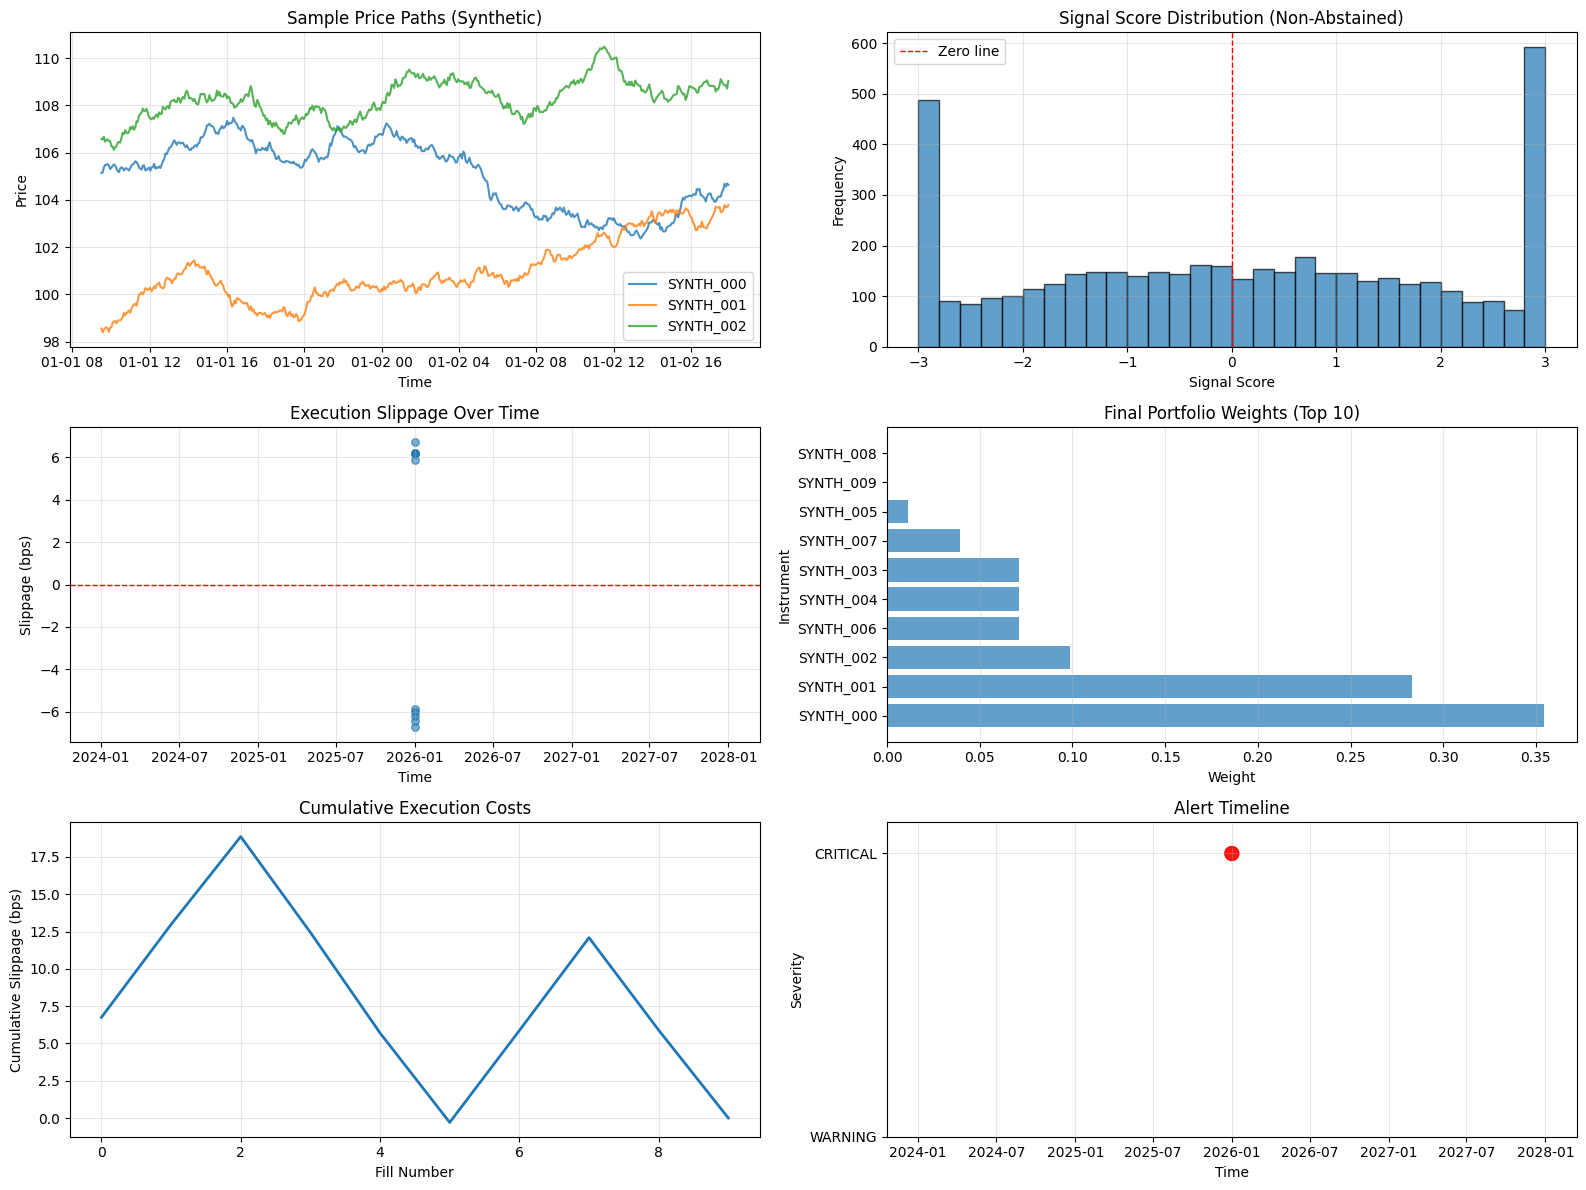

In [26]:
# Cell 17 — Visualizations

"""
VISUALIZATIONS:
Production-quality plots for monitoring and analysis.

PLOTS:
1. Sample price paths
2. Signal score distribution
3. Slippage over time
4. Portfolio exposure evolution
5. Alert timeline
"""

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("=" * 80)
print("VISUALIZATIONS")
print("=" * 80)

# Prepare data for plotting
# 1. Price paths (sample 3 instruments)
sample_instruments = market_gen.instruments[:3]
price_data = {inst: {"times": [], "prices": []} for inst in sample_instruments}

for event in clean_events:
    if event["instrument_id"] in sample_instruments:
        price_data[event["instrument_id"]]["times"].append(event["event_time"])
        price_data[event["instrument_id"]]["prices"].append(event["payload"]["close"])

# 2. Signal distribution
signal_scores = [s["payload"]["score"] for s in signals if not s["payload"]["abstain"]]

# 3. Slippage over time
slippage_times = [f["fill_time"] for f in execution_service.fills]
slippage_values = [f["slippage_bps"] for f in execution_service.fills]

# 4. Portfolio weights over time (simplified - take snapshots)
# For demo, just show final weights

# 5. Alert timeline
alert_times = [datetime.fromisoformat(a["timestamp"]) for a in monitoring_service.alerts]
alert_severities = [1 if a["severity"] == "WARNING" else 2 for a in monitoring_service.alerts]

# Create plots
fig = plt.figure(figsize=(16, 12))

# Plot 1: Price paths
ax1 = plt.subplot(3, 2, 1)
for inst in sample_instruments:
    if price_data[inst]["times"]:
        ax1.plot(price_data[inst]["times"], price_data[inst]["prices"],
                label=inst, linewidth=1.5, alpha=0.8)
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title("Sample Price Paths (Synthetic)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Signal distribution
ax2 = plt.subplot(3, 2, 2)
if signal_scores:
    ax2.hist(signal_scores, bins=30, alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero line')
    ax2.set_xlabel("Signal Score")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Signal Score Distribution (Non-Abstained)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Plot 3: Slippage over time
ax3 = plt.subplot(3, 2, 3)
if slippage_times:
    ax3.scatter(slippage_times, slippage_values, alpha=0.6, s=30)
    ax3.axhline(0, color='red', linestyle='--', linewidth=1)
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Slippage (bps)")
    ax3.set_title("Execution Slippage Over Time")
    ax3.grid(True, alpha=0.3)

# Plot 4: Final portfolio weights
ax4 = plt.subplot(3, 2, 4)
if portfolio_service.current_weights:
    sorted_weights = sorted(portfolio_service.current_weights.items(), key=lambda x: -x[1])
    instruments_plot = [x[0] for x in sorted_weights[:10]]
    weights_plot = [x[1] for x in sorted_weights[:10]]
    ax4.barh(instruments_plot, weights_plot, alpha=0.7)
    ax4.set_xlabel("Weight")
    ax4.set_ylabel("Instrument")
    ax4.set_title("Final Portfolio Weights (Top 10)")
    ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Cumulative slippage cost
ax5 = plt.subplot(3, 2, 5)
if slippage_values:
    cumulative_slippage = np.cumsum(slippage_values)
    ax5.plot(range(len(cumulative_slippage)), cumulative_slippage, linewidth=2)
    ax5.set_xlabel("Fill Number")
    ax5.set_ylabel("Cumulative Slippage (bps)")
    ax5.set_title("Cumulative Execution Costs")
    ax5.grid(True, alpha=0.3)

# Plot 6: Alert timeline
ax6 = plt.subplot(3, 2, 6)
if alert_times:
    colors = ['orange' if s == 1 else 'red' for s in alert_severities]
    ax6.scatter(alert_times, alert_severities, c=colors, s=100, alpha=0.7)
    ax6.set_xlabel("Time")
    ax6.set_ylabel("Severity")
    ax6.set_yticks([1, 2])
    ax6.set_yticklabels(["WARNING", "CRITICAL"])
    ax6.set_title("Alert Timeline")
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, "No alerts triggered",
            ha='center', va='center', fontsize=12)
    ax6.set_title("Alert Timeline")

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "monitoring_dashboard.png", dpi=150, bbox_inches='tight')
print(f"✓ Dashboard saved: {ARTIFACTS_DIR / 'monitoring_dashboard.png'}")
plt.show()

##18.MODULE FOR EXTENSION TO REAL DATA

###18.1.OVERVIEW



**Objective and Context**

This section demonstrates how to replace the synthetic market generator with adapters that fetch real market data from external providers. Throughout the notebook, we have deliberately used synthetic data with controlled properties and injected quality issues to enable deterministic testing, reproducible results, and educational clarity without requiring paid data subscriptions or vendor credentials. However, the ultimate goal of any trading platform is to operate on actual market data. This section provides the bridge from educational simulation to production deployment by showing exactly how real data sources integrate into the existing pipeline. Critically, this integration is designed as an optional drop-in replacement—all upstream services (ingestion, features, signals, portfolio, execution) remain completely unchanged because they depend only on standardized event schemas, not on specific data sources. This architectural separation between data acquisition and data processing is fundamental to professional system design.

**The Adapter Pattern**

Real data integration uses the adapter design pattern:

- **Interface Standardization**: The adapter translates provider-specific APIs and data formats into the standardized event schema that the rest of the system expects. This translation happens at the system boundary, isolating the majority of the codebase from provider peculiarities.

- **Drop-In Replacement**: Replacing synthetic data with real data requires changing only the data source while leaving all downstream processing unchanged. The ingestion service, feature service, and all subsequent components cannot tell whether events originated from synthetic generation or real market feeds.

- **Multiple Provider Support**: The adapter pattern naturally extends to multiple providers. Each provider gets its own adapter translating to the common schema, enabling the system to consume data from multiple sources simultaneously or switch between providers without affecting processing logic.

- **Provider Isolation**: When providers change APIs, experience outages, or introduce bugs, only the specific adapter needs modification. The rest of the system remains unaffected, limiting the blast radius of provider issues.

**YFinance Integration Example**

The section demonstrates integration with yfinance, a popular open-source library for fetching Yahoo Finance data:

- **Historical Data Access**: YFinance provides free access to historical daily and intraday bar data for thousands of instruments without requiring authentication or paid subscriptions.

- **Modern API Patterns**: The implementation uses current yfinance syntax (Ticker objects and history method) rather than deprecated approaches, ensuring the code remains functional as the library evolves.

- **Pedagogical Accessibility**: YFinance requires only a pip install, making it accessible to students without institutional data access or financial resources for paid feeds.

- **Production Limitations**: While suitable for education and backtesting, YFinance has limitations for production use including rate limiting, occasional outages, limited historical depth, and no support for real-time streaming. Production systems use institutional providers like Bloomberg, Refinitiv, or exchange direct feeds.

**Data Transformation and Schema Mapping**

The adapter implements careful transformation from provider format to system schema:

- **Timestamp Conversion**: YFinance returns pandas DatetimeIndex which must be converted to Python datetime objects. The to_pydatetime() method performs this conversion correctly preserving timezone information.

- **OHLCV Field Mapping**: Provider field names (Open, High, Low, Close, Volume) are mapped to the system's expected payload structure. This explicit mapping makes provider dependencies visible and modifiable.

- **Type Coercion**: Numeric values are explicitly converted to float and int types ensuring consistent types regardless of provider implementation details or pandas dtype choices.

- **Event Metadata Addition**: Beyond the OHLCV data itself, the adapter adds source identification, generates unique event identifiers, and captures processing timestamps—all metadata required by the downstream system.

**Optional Execution and Error Handling**

The section implements sophisticated optional execution patterns:

- **Try-Except Isolation**: All real data fetching is wrapped in try-except blocks ensuring that failures to import yfinance or fetch data do not break the notebook execution.

- **Graceful Degradation**: If yfinance is unavailable or data fetching fails, the section prints informative messages but continues execution, allowing the notebook to complete successfully with synthetic data.

- **Installation Instructions**: Clear instructions guide users on how to install yfinance if they want to enable real data, but emphasize that it is optional for completing the educational objectives.

- **Network Dependency Awareness**: The section acknowledges that real data fetching requires network connectivity and external service availability, dependencies that synthetic data avoids.

**DataFrame to Event Stream Conversion**

The adapter transforms pandas DataFrames into event streams matching synthetic generator output:

- **Row-by-Row Iteration**: Each DataFrame row becomes a separate event preserving temporal ordering and per-timestamp granularity.

- **Index Access Pattern**: Using iloc[i] for positional access avoids deprecated iterrows() patterns and performs efficiently even for large datasets.

- **Schema Compliance**: Each generated event follows the exact schema established earlier, ensuring downstream services receive familiar, validated inputs.

- **Batching Considerations**: Production adapters often batch events for efficiency, but educational implementations process row-by-row for clarity.

**Multi-Instrument Universe Management**

The adapter demonstrates handling multiple instruments:

- **Sequential Fetching**: Instruments are fetched sequentially in the simple implementation. Production systems fetch in parallel to reduce latency.

- **Per-Instrument Error Handling**: Failures fetching one instrument do not prevent fetching others. Each instrument's data is fetched independently with separate error handling.

- **Event Interleaving**: Events from multiple instruments are interleaved in the output stream, mimicking how market data actually arrives with events from different instruments interspersed.

- **Temporal Alignment**: When events from different instruments share timestamps (like daily bars all at market close), the adapter preserves this alignment for correct feature calculation.

**Production Data Integration Considerations**

While yfinance suffices for education, production systems require more sophisticated approaches:

- **Institutional Providers**: Bloomberg Terminal, Refinitiv Eikon, FactSet, or direct exchange feeds provide enterprise-grade reliability, support, and legal clarity around data rights.

- **Real-Time Streaming**: Production systems consume real-time tick data or sub-second bars rather than daily historical data, requiring WebSocket connections, message queuing, and stream processing.

- **Multiple Data Types**: Beyond OHLCV bars, production systems consume trades, quotes, order book depth, corporate actions, fundamental data, and alternative data requiring multiple specialized adapters.

- **Redundancy and Failover**: Critical systems maintain connections to multiple data providers simultaneously, automatically failing over when primary providers experience outages.

- **Data Quality Monitoring**: Production adapters implement sophisticated quality monitoring detecting issues like missing ticks, timestamp reversals, or impossible values and alerting operations teams.

**Adapter Testing and Validation**

Real data adapters require comprehensive testing:

- **Schema Compliance Tests**: Automated tests verify that adapter outputs strictly conform to expected schemas regardless of provider API changes.

- **Historical Replay**: Saved historical provider responses are replayed through adapters to verify behavior remains consistent across code changes.

- **Failure Mode Testing**: Tests deliberately inject provider errors (network timeouts, malformed responses, rate limit errors) to verify adapter error handling.

- **Performance Benchmarking**: Adapters are benchmarked to ensure they can process data at required throughput without becoming bottlenecks.

**When to Use Real Data vs Synthetic**

The section provides guidance on appropriate data source choices:

- **Strategy Development**: Synthetic data with controlled properties enables rapid iteration and deterministic testing during initial development.

- **Backtesting Validation**: Real historical data validates that strategies work on actual market characteristics not just idealized synthetic patterns.

- **Paper Trading**: Real-time data enables paper trading where the system runs on live data but does not submit actual orders, the final validation stage before live deployment.

- **Live Trading**: Only live trading uses real-time data with actual order submission. This final stage requires all prior stages to pass successfully.

**Pedagogical Insights**

This section teaches several fundamental lessons about production data integration:

- **Abstraction Enables Flexibility**: By standardizing on event schemas and adapter patterns, systems gain flexibility to swap data sources without rewriting core logic.

- **Optional Dependencies**: Not all users need all features. Making expensive or complex dependencies optional increases accessibility while maintaining advanced capabilities for users who need them.

- **Provider Isolation**: Isolating provider-specific logic in adapters limits the impact of provider changes, outages, or migrations to small well-defined code sections.

- **Graceful Degradation**: Systems should degrade gracefully when optional components are unavailable rather than failing catastrophically.

- **Testing Across Data Sources**: Systems that work on synthetic data must also be validated on real data to catch assumptions that hold in synthetic environments but fail in production.

Students who understand adapter patterns and optional dependency management will build systems that are simultaneously accessible for learning and evolution-ready for production deployment with institutional data providers.

###18.2.CODE AND IMPLEMENTATION

In [27]:
# Cell 18 — OPTIONAL Real-Data Adapter (Isolated, Not Required)

"""
OPTIONAL: Real-Data Adapter
This cell demonstrates how to swap synthetic market with real data.
This is OPTIONAL and the notebook runs without it.
"""

print("=" * 80)
print("OPTIONAL: REAL-DATA ADAPTER")
print("=" * 80)

# Try to import yfinance (optional)
try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
    print("✓ yfinance available")
except ImportError:
    YFINANCE_AVAILABLE = False
    print("⚠ yfinance not installed (this is optional)")

if YFINANCE_AVAILABLE:
    print("\nReal-data adapter example:")
    print("To use real market data, replace SyntheticMarketGenerator with:")
    print("""
    class RealDataAdapter:
        def __init__(self, tickers, start_date, end_date):
            self.tickers = tickers
            self.start_date = start_date
            self.end_date = end_date

        def fetch_data(self):
            events = []
            for ticker in self.tickers:
                # Fetch data using yfinance
                ticker_obj = yf.Ticker(ticker)
                df = ticker_obj.history(start=self.start_date, end=self.end_date)

                # Convert to events using vectorized operations
                for i in range(len(df)):
                    timestamp = df.index[i].to_pydatetime()

                    event = EventSchema.create_event(
                        event_type="bar",
                        source="yfinance",
                        instrument_id=ticker,
                        event_time=timestamp,
                        payload={
                            "open": float(df.iloc[i]["Open"]),
                            "high": float(df.iloc[i]["High"]),
                            "low": float(df.iloc[i]["Low"]),
                            "close": float(df.iloc[i]["Close"]),
                            "volume": int(df.iloc[i]["Volume"])
                        }
                    )
                    events.append(event)

            return events

    # Usage:
    # adapter = RealDataAdapter(["AAPL", "MSFT", "GOOGL"], "2024-01-01", "2024-12-31")
    # real_events = adapter.fetch_data()
    # clean_events = ingestion.ingest_batch(real_events)
    # ... continue pipeline ...
    """)

    # Small demo (optional, won't break if fails)
    try:
        print("\nFetching sample data for AAPL (last 5 days)...")
        ticker = yf.Ticker("AAPL")
        df = ticker.history(period="5d")
        if not df.empty:
            print(f"✓ Fetched {len(df)} bars")
            print(df.head())
        else:
            print("⚠ No data returned (this is optional)")
    except Exception as e:
        print(f"⚠ Sample fetch failed: {e} (this is optional)")
else:
    print("\nTo enable real data:")
    print("  !pip install yfinance")
    print("\nThen replace synthetic market generator with RealDataAdapter as shown above.")

print("\n" + "=" * 80)
print("NOTE: This notebook is fully functional with synthetic data only.")
print("Real data integration is optional and for demonstration purposes.")
print("=" * 80)

OPTIONAL: REAL-DATA ADAPTER
✓ yfinance available

Real-data adapter example:
To use real market data, replace SyntheticMarketGenerator with:

    class RealDataAdapter:
        def __init__(self, tickers, start_date, end_date):
            self.tickers = tickers
            self.start_date = start_date
            self.end_date = end_date
        
        def fetch_data(self):
            events = []
            for ticker in self.tickers:
                # Fetch data using yfinance
                ticker_obj = yf.Ticker(ticker)
                df = ticker_obj.history(start=self.start_date, end=self.end_date)
                
                # Convert to events using vectorized operations
                for i in range(len(df)):
                    timestamp = df.index[i].to_pydatetime()
                    
                    event = EventSchema.create_event(
                        event_type="bar",
                        source="yfinance",
                        instrument_id=tic

##19.CONCLUSIONS


**FROM RESEARCH TO PRODUCTION-GRADE INFRASTRUCTURE**

**A. OVERVIEW**

This notebook represents a comprehensive journey from theoretical concepts to production-ready infrastructure for algorithmic trading systems. Unlike typical academic exercises that focus on backtesting returns or optimizing signals in isolation, this implementation tackles the unglamorous but absolutely critical challenge that separates hobbyist traders from institutional operations: building a robust, governable, observable, and auditable trading platform that can operate safely in live markets.

The gap between research and production in quantitative finance is vast and treacherous. A strategy that looks promising in a Jupyter notebook with perfect hindsight often fails catastrophically when confronted with real-world complexities like data latency, partial order fills, reconciliation breaks, schema evolution, and operational incidents. This notebook deliberately focuses on these production concerns rather than alpha generation, because in the real world, a mediocre strategy running on excellent infrastructure will outperform a brilliant strategy running on fragile systems every single time.

We have constructed a minimal but complete trading platform runtime simulation that demonstrates service decomposition, event-driven architecture, time semantics enforcement, execution microstructure, reconciliation as primary truth, comprehensive monitoring and alerting, governance-native artifact management, and a full testing harness including chaos engineering. Every design decision reflects hard-won lessons from production trading systems, condensed into an educational framework that students can understand, modify, and build upon.

**B. OBJECTIVE**

The primary objective of this notebook is to provide MBA and Master of Finance students with a realistic, hands-on laboratory for understanding how algorithmic trading strategies actually operate in production environments. This goes far beyond the typical coursework focus on portfolio theory, factor models, or backtesting frameworks. Instead, we address the question that every quantitative finance professional must eventually answer: how do you take a trading idea from research to a system that can manage real capital, execute real orders, handle real failures, and satisfy real regulatory requirements?

The notebook is designed to be pedagogically rigorous while remaining practically relevant. We deliberately avoid external dependencies like pandas and instead use only NumPy and Python standard library, forcing students to understand the underlying mechanics rather than relying on convenience abstractions. This constraint also ensures the code is portable, transparent, and auditable—qualities essential for production systems where debugging a third-party library at three in the morning during a market incident is not an option.

Our secondary objective is to demonstrate governance-native design from the ground up. Every event carries a schema version and quality flags. Every decision links to a decision identifier that propagates through orders and fills, creating a complete audit trail. Every configuration change is hashed and recorded. Every run produces a manifest documenting exactly what was executed, when, by whom, and with what results. This is not bureaucratic overhead—this is the minimum viable infrastructure for operating a trading system that manages other people's money or that must satisfy regulatory examination.

Finally, we aim to instill a mindset of paranoid operational discipline. Production trading systems operate in an adversarial environment where everything that can go wrong eventually will: data feeds fail, brokers reject orders, networks partition, clocks drift, schemas break, and humans make mistakes. The notebook systematically demonstrates how to design for these failure modes through pre-trade checks, staleness rejection, abstention logic, reconciliation gates, monitoring thresholds, runbook automation, and deterministic replay. Students who internalize these patterns will build more robust systems throughout their careers, whether in finance or any other domain where reliability matters.

**C. WHAT WAS ACHIEVED: A COMPREHENSIVE LABORATORY FOR OPERATIONAL ALGO STRATEGIES**

From a student perspective, this notebook provides an unprecedented window into the operational reality of algorithmic trading. Most educational materials stop at signal generation or portfolio optimization, leaving an enormous gap between "here is the optimal weight vector" and "here is how we safely execute that in live markets while monitoring for failures and maintaining an audit trail." This notebook fills that gap completely.

Students see, perhaps for the first time, that a trading system is not a monolithic script but rather a carefully orchestrated pipeline of services, each with clear responsibilities and contracts. The ingestion service does not trust incoming data—it validates schemas, enforces time semantics, rejects stale events, and quarantines malformed inputs. The feature service maintains explicit lags to prevent look-ahead bias and uses incremental computation with ring buffers rather than reprocessing entire histories. The signal service includes confidence scoring and abstention logic, acknowledging that sometimes the correct action is to do nothing. The portfolio service enforces hard constraints on weights and turnover, because violating risk limits is a firing offense regardless of subsequent returns. The execution service models realistic microstructure with partial fills and slippage, because perfect execution only exists in backtests. The reconciliation service acts as the ultimate source of truth, because your internal accounting and the broker's accounting will eventually diverge and you must detect and resolve this immediately.

Each service produces structured events and logs, creating a complete data lineage from market tick to filled order. Students can trace any decision backward through the decision identifier to see exactly what features were used, what signals were generated, what portfolio construction logic was applied, and what execution outcomes resulted. This is not just good engineering—this is essential for debugging production issues, satisfying regulatory inquiries, and conducting post-incident reviews. When a compliance officer asks "why did you buy this security on this date," you must be able to produce the complete chain of reasoning within minutes, not days.

The testing framework demonstrates multiple layers of verification that production systems require. Unit tests check invariants like schema compliance and time monotonicity. Parity tests verify deterministic reproducibility by replaying saved event streams and asserting identical outputs. Integration tests run end-to-end scenarios with known market paths and verify causality throughout the pipeline. Chaos tests inject realistic failures—feed outages, latency spikes, schema corruption, broker rejections, reconciliation breaks—and verify that the system degrades safely rather than amplifying risk. Students learn that testing is not an afterthought but rather a core competency that distinguishes professional engineering from amateur hacking.

The monitoring and alerting system shows students how production operators actually maintain awareness of system health. We compute KPIs across multiple dimensions: data freshness, feature coverage, signal quality, execution performance, and risk utilization. We implement threshold-based alerting with hysteresis to avoid notification fatigue. Most importantly, we provide runbook actions for each alert type, because detecting a problem is only half the battle—you must also know how to respond. Should you degrade gracefully, halt trading, force reconciliation, or escalate to human review? These decisions cannot be made in the heat of an incident; they must be encoded in advance based on scenario analysis and risk tolerance.

The artifact registry and run manifest demonstrate governance-native design in practice. Every run produces a complete record of what was executed: configuration hash, code hash, environment metadata, universe definition, decision schedule, and pointers to all logs and outputs. This manifest serves multiple purposes simultaneously: it enables deterministic reproduction for debugging, provides evidence for regulatory examination, supports post-mortem analysis after incidents, and creates institutional memory as team members change over time. Students see that documentation is not separate from the system—it is automatically generated as a byproduct of disciplined engineering.

The notebook also demonstrates the importance of time semantics, a topic often glossed over in academic settings but absolutely critical in production. We explicitly model three clocks: event time when something happened in the market, processing time when we received and processed it, and decision time when we made a trading decision. We enforce monotonicity, reject stale data, and use explicit lags to prevent look-ahead bias. Students learn that time is not a simple incrementing counter but rather a complex concept with multiple interpretations, and getting time semantics wrong leads to subtle bugs that only manifest in production and can be devastatingly expensive.

Perhaps most importantly, students experience the full lifecycle of an order through a realistic state machine. Orders are not instantaneously filled at the mid-quote—they are created, submitted, acknowledged, worked, potentially partially filled, and sometimes rejected. Each state transition has timing implications and operational consequences. Slippage is not a constant but rather a function of volatility, spread, order size, and market impact. Students learn to model execution costs realistically and understand that transaction cost analysis is not academic pedantry but rather a major determinant of net returns, especially at higher frequencies or larger scales.

**D. STEP-BY-STEP PIPELINE: THE ANATOMY OF A PRODUCTION TRADING SYSTEM**

The pipeline begins with synthetic market generation, deliberately designed to include realistic data quality issues. We generate geometric Brownian motion price paths for a small universe of synthetic instruments, but we also inject late-arriving events, missing fields, and schema violations at controlled rates. This is not gratuitous complexity—this is the reality of production data feeds. Students must internalize that real market data is messy, incomplete, sometimes duplicated, occasionally corrupted, and always subject to vendor-specific quirks. A system that assumes perfect data will fail immediately in production.

The ingestion service acts as the first line of defense, implementing multiple validation gates. Schema validation ensures all required fields are present and have sensible values. Time semantics checks enforce that processing time is not before event time and flag events that arrive too stale to be useful. Duplicate detection prevents the same event from being processed twice. Range checks catch obvious errors like negative prices or inverted high-low values. Rejected events are logged with clear reasons, creating a audit trail for operational review. The ingestion service embodies a fundamental principle: trust nothing that comes from outside your system boundary, and validate everything explicitly.

The feature service transforms raw market events into computable features using incremental algorithms with explicit lags. Rather than loading entire price histories and computing features with vectorized pandas operations, we maintain ring buffers per instrument and update features as new events arrive. This design choice reflects production reality: you cannot recompute all features from scratch for every tick, especially with thousands of instruments. The explicit lag enforcement—features at time t use only data from time t minus lag—prevents look-ahead bias that would artificially inflate backtest performance but guarantee production losses. Students learn that feature engineering is not just about finding predictive signals but also about computing them in a causality-preserving, computationally efficient manner.

The signal service converts features to trading signals while acknowledging uncertainty. A simple momentum-volatility score provides directionality, but we also compute a confidence measure based on recent volatility. Crucially, we implement abstention logic: when confidence falls below a threshold or volatility spikes, we explicitly choose not to trade. This is a sophisticated concept rarely taught in academic settings, where the implicit assumption is that the model always produces an actionable signal. In production, knowing when not to trade is often more valuable than knowing when to trade, because the worst losses frequently come from taking aggressive positions during periods of high uncertainty or market stress.

The portfolio service translates signals into target weights while enforcing multiple hard constraints. We implement a simplified ranking-based approach where signal scores weighted by confidence determine relative positions, but we also apply maximum instrument weight constraints, turnover limits, and gross exposure caps. These constraints are not optimizations to be solved—they are regulatory requirements and risk management policies that must be satisfied unconditionally. Students see that portfolio construction in production is not about finding the mathematically optimal portfolio but rather about finding the best portfolio that satisfies all operational constraints. We also demonstrate the concept of dry-run mode, where the portfolio service computes target weights but does not actually submit orders, allowing for safe testing of logic changes without market impact.

The execution service manages the complete order lifecycle through a finite state machine, from order creation through submission, acknowledgment, working status, potential partial fills, and final state of filled, canceled, or rejected. We implement pre-trade risk checks that can reject orders before they reach the market, including price band validation, notional caps, rate limiting, and exposure checks. We simulate realistic microstructure with slippage that scales with volatility, partial fills that occur probabilistically, and market rejections that model broker-side risk controls. Students learn that execution is not instantaneous or frictionless, and that modeling execution costs and risks accurately is essential for realistic performance projection and risk management.

The reconciliation service implements a fundamental operational principle: never trust your internal accounting as the sole source of truth. We maintain both an internal ledger of positions and cash based on our execution records, and a simulated broker ledger representing the counterparty view. We periodically reconcile these two ledgers, comparing positions and cash balances within a small tolerance. Any discrepancy triggers an alert and, in a production system, would halt further trading until the break is investigated and resolved. Students learn that reconciliation breaks are not rare edge cases but rather routine operational issues that arise from timing differences, communication failures, or system bugs, and that having a robust reconciliation process is non-negotiable for any system managing real capital.

The monitoring service computes a comprehensive set of key performance indicators spanning data quality, feature health, signal performance, execution quality, and risk utilization. We implement threshold-based alerting with hysteresis to avoid alert fatigue from transient spikes. Each alert type maps to a specific runbook action: degrade gracefully by widening risk limits, halt trading entirely, force reconciliation, or escalate for manual investigation. Students see that monitoring is not about collecting metrics for dashboards but rather about detecting operational issues early and responding appropriately. The post-incident review template demonstrates how production teams document and learn from failures, turning incidents into institutional knowledge rather than letting lessons evaporate when team members leave.

The artifact registry and run manifest provide complete governance coverage. Every decision is logged with a decision identifier that propagates through orders and fills. Every configuration is hashed and recorded. Every run produces a manifest documenting code version, configuration state, environment details, universe composition, and execution summary. All events, orders, and fills are serialized to JSONL files for offline analysis. The reconciliation report, monitoring snapshot, and incident review are saved as structured artifacts. Students learn that governance is not bureaucratic overhead imposed by compliance departments but rather essential infrastructure that enables debugging, auditability, reproducibility, and institutional continuity.

The testing framework demonstrates multiple layers of verification. Unit tests check basic invariants like schema compliance and monotonic time. Parity tests verify deterministic reproducibility by replaying saved event streams and asserting bit-identical outputs. Integration tests run end-to-end with known synthetic market paths and verify causality at every stage. Chaos tests inject realistic failures and verify safe degradation. This multi-layered approach reflects production reality: comprehensive testing catches more bugs than any single technique, and different test types serve different purposes. Students learn that testing is not about achieving coverage metrics but rather about building confidence that the system will behave correctly under both normal and adversarial conditions.

**E. FROM NOTEBOOK TO BOARDROOM: THE PATH TO PRODUCTION**

For students contemplating a presentation to a board of directors or potential investors, this notebook provides the foundational architecture and operational discipline required for a credible pitch. Boards and investors do not fund ideas—they fund execution capability. A sophisticated trading strategy is worthless if you cannot operate it reliably, monitor it effectively, and govern it transparently. This notebook demonstrates all three.

The first question any sophisticated investor will ask is not about your Sharpe ratio but about your operational infrastructure. How do you prevent look-ahead bias? How do you handle data feed outages? What happens when your broker rejects orders? How do you reconcile positions? What is your incident response process? Can you reproduce any historical decision deterministically? Do you have audit trails for regulatory examination? This notebook provides concrete answers to all these questions, demonstrating that you understand production operations at a level that most competitors do not.

The service decomposition architecture scales naturally from this single-notebook simulation to a distributed production system. Each service—ingestion, features, signals, portfolio, execution, reconciliation, monitoring—can be deployed independently as a microservice with well-defined contracts and event-driven communication. The message bus that is currently an in-memory queue can be replaced with Kafka or RabbitMQ without changing service logic. The artifact registry that currently writes to local disk can write to S3 or a document database. The monitoring service that currently logs alerts can integrate with PagerDuty or Slack. Students learn to think in terms of service boundaries and contracts rather than monolithic scripts, which is essential for building systems that can scale to institutional size and complexity.

The governance artifacts demonstrate regulatory readiness from day one. Every major regulator—SEC, FINRA, FCA, MiFID—requires trading firms to maintain detailed records of trading decisions and execution outcomes. The decision identifiers, event logs, order logs, fill logs, reconciliation reports, and run manifests that this notebook generates automatically satisfy many of these requirements. Students learn that regulatory compliance is not something to bolt on later but rather something to design into the system architecture from the beginning. A trading firm that cannot produce a complete audit trail for any historical trade within minutes is not fundable, full stop.

The testing framework demonstrates engineering maturity that investors look for. Most algorithmic trading startups fail not because their strategies stop working but because their systems break under operational stress and the team lacks the discipline to prevent or recover from failures. The combination of unit tests, parity tests, integration tests, and chaos tests shows that you understand how to build reliable systems. The post-incident review template shows that you have a process for learning from failures. The runbook automation shows that you have thought through failure scenarios in advance rather than improvising during crises. These operational capabilities are often more important than strategy performance in determining which startups succeed.

For students planning to start a quantitative trading firm, this notebook provides a roadmap for minimum viable infrastructure. You do not need to build everything from scratch—you can use cloud services for compute and storage, third-party vendors for market data and execution, and open-source tools for monitoring and alerting. But you absolutely must have the architectural patterns demonstrated here: service decomposition, event-driven communication, time semantics enforcement, explicit lags, confidence scoring, abstention logic, hard constraints, realistic execution modeling, reconciliation as primary truth, comprehensive monitoring, governance artifacts, and multi-layered testing. These are not nice-to-haves—these are table stakes for operating a professional trading operation.

The path from this notebook to a fundable pitch involves three major steps. First, validate the strategy performance using the existing infrastructure with real historical data rather than synthetic data, demonstrating that the pipeline works end-to-end with actual market complexity. Second, conduct operational stress testing by running the system in paper trading mode for several months, collecting metrics on data quality issues, execution surprises, reconciliation breaks, and incident frequency. Third, prepare a comprehensive operational readiness assessment documenting your infrastructure capabilities, risk controls, monitoring processes, incident response procedures, disaster recovery plans, and regulatory compliance measures. Investors fund teams that demonstrate both strategy edge and operational excellence—this notebook gives you the foundation for the latter.

The notebook also serves as a living blueprint for team scaling. As you hire additional developers, risk managers, and operations staff, this codebase provides a concrete reference implementation of your architectural principles and operational standards. New team members can read the code, run the notebook, modify components, and immediately understand how the system works and why it is designed this way. The extensive comments and clear structure make knowledge transfer efficient, which is critical for maintaining institutional continuity as the team grows. Documentation is built into the code itself rather than maintained separately, ensuring it stays current and accurate.

Finally, this notebook positions you to speak credibly with potential partners and service providers. When you discuss market data feeds with vendors, you can explain exactly what schema validation, staleness thresholds, and quality flags you need. When you negotiate with brokers, you can discuss order lifecycle management, partial fills, reject handling, and reconciliation protocols with technical precision. When you evaluate cloud providers, you can specify exactly what deployment patterns, message bus capabilities, and artifact storage you require. This level of operational sophistication separates amateur enthusiasts from professional operators, and vendors respond accordingly.

In summary, this notebook is not just an educational exercise but rather a comprehensive blueprint for building production-grade algorithmic trading infrastructure. It demonstrates service decomposition, event-driven architecture, time semantics, execution microstructure, reconciliation discipline, monitoring rigor, governance completeness, and testing comprehensiveness. For students, it provides unprecedented visibility into how trading systems actually operate in production. For aspiring entrepreneurs, it provides the foundational architecture required to build a credible, fundable, scalable trading operation. The gap between research and production is vast, but this notebook provides a bridge that can be crossed with disciplined engineering, paranoid operational thinking, and systematic attention to the unglamorous details that determine whether a trading system succeeds or fails in the real world.
